<img src="images\GRU_formulas.jpg" width=800>
<img src="images\GRU_shapes.jpg" width=200>
<img src="images\GRU_derivatives.jpg" width=800>

In [139]:
import random, math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=16,5


def load_data_txt(filename, dimensions, max_len=None):
    f = open(filename, "r")
    data = []
    print("loading data")
    for line in f:
        for c in line:
            if ord(c)-ord('A') > 0 and ord(c)-ord('A') < dimensions:
                new_data = []
                for i in range(0, dimensions):
                    new_data.append([0])
                    
                new_data[ord(c)-ord('A')] = [1]
                data.append(new_data)
                if max_len != None:
                    if len(data) >= max_len:
                        print("all loaded")    
                        return data
                    
    print("all loaded")    
    return data
            
def sigmoid(x):
    return 1/(1+np.exp(-np.clip(x, -500, 500)))

def swish(x):
    return x*sigmoid(x)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    p = np.exp(x - np.max(x))
    return p/np.sum(p)

def MSE(target, x):
    return np.power(target - x, 2)

def activation_function(z, act, derivative=False, activated_value=None):
    if derivative == False:
        if act=="sigmoid":
            return sigmoid(z)
        elif act == "swish":
            return swish(z)
        elif act == "relu":
            return relu(z)
        elif act=="tanh":
            return np.tanh(z)
        elif act=="softmax":
            return softmax(z)
    else:
        if act=="sigmoid":
            return activated_value * (1 - activated_value)
        elif act == "swish":
            return activated_value + sigmoid(z) * (1 - activated_value)
        elif act == "relu":  
            x = activated_value
            x[x<=0] = 0
            x[x>0] = 1
            return x
        
        elif act=="tanh":
            return 1 - np.power(activated_value, 2)
        elif act=="softmax":
            return activated_value

class RNN():
    
    def __init__(self, l_rate):
        self.layers = []
        self.learning_rate = l_rate
        
    def add_layer(self, input_size, output_size, last_activation=None):
        new_layer = Layer(input_size, output_size, last_activation)
        self.layers.append(new_layer)
        
    def forward_pass(self, input_data):
        self.layers[0].forward_pass(input_data)
        for i in range(1, len(self.layers)):
            prev_layer_out = self.layers[i-1].h[-1]        # Takes in the output of the previous layer. h[-1] is the hidden state of the last timestep of the layer
            self.layers[i].forward_pass(prev_layer_out)
            
        return self.layers[-1].h[-1]
            
    def clear_memory(self):
        for i in range(0, len(self.layers)):
            self.layers[i].clear_memory()
            
    def backpropagation_through_time(self, input_data, target, max_steps):
        gradient, loss = self.layers[-1].der_MSE(target)
        #print("MSE gradient: " + str(gradient))
        for i in range(1, len(self.layers)):
            inputs = self.layers[-i-1].h
            gradient = self.layers[-i].descent(gradient, inputs, self.learning_rate, max_steps)
        self.layers[0].descent(gradient, input_data, self.learning_rate, max_steps)
        return loss
    
    def predict(self, input_data):
        next_letter = []
        out_letter = []
        for i in range(0, len(input_data)):
            next_letter = self.forward_pass(input_data[i])
            
        out_letter = next_letter
        print_output = ""
        for i in range(500, 700):
            maximum = 0;
            max_index = 0;
            for k in range(0, self.layers[0].input_size):
                if next_letter[k][0] > maximum:
                    maximum = next_letter[k][0]
                    max_index = k
            out_letter = np.empty(next_letter.shape)
            out_letter.fill(0)
            out_letter[max_index,0] = 1
            print_output += chr(ord('A')+max_index)
            next_letter = self.forward_pass(out_letter)
        print(print_output)
    
class Layer():
    
    def __init__(self, input_size, output_size, last_activation=None):
        self.input_size = input_size # M
        self.output_size = output_size # N
        self.last_activation = last_activation
        
        self.Wz = self.weights_init(output_size, input_size) # NxM
        self.Wr = self.weights_init(output_size, input_size) # NxM
        self.Wh = self.weights_init(output_size, input_size) # NxM
        
        self.Uz = self.weights_init(output_size, output_size) # NxN
        self.Ur = self.weights_init(output_size, output_size) # NxN
        self.Uh = self.weights_init(output_size, output_size) # NxN
        
        self.bz = self.weights_init(output_size, 1, bias=True) # Nx1
        self.br = self.weights_init(output_size, 1, bias=True) # Nx1
        self.bh = self.weights_init(output_size, 1, bias=True) # Nx1
        
        # T = time steps, starts with 0
        
        self.z       = np.empty((0,output_size,1)) # TxNx1, z(t) = Nx1
        self.r       = np.empty((0,output_size,1)) # TxNx1, r(t) = Nx1
        self.h_tilde = np.empty((0,output_size,1)) # TxNx1, h_tilde(t) = Nx1
        self.h       = np.empty((0,output_size,1)) # TxNx1, h(t) = Nx1
        self.inputs  = np.empty((0,input_size,1))  # TxMx1, inputs(t) = Mx1
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
    def weights_init(self, rows, cols, bias=False):
        variance = math.sqrt(1/self.input_size)
        if bias:
            return np.random.uniform(0,0.01,(rows, cols))
        return np.random.uniform(-variance,variance,(rows, cols))
    
    
    def forward_pass(self, input_data):
        
        self.inputs = np.append(self.inputs, [input_data])
        prev_h = []
        if len(self.h) > 0:
            prev_h = self.h[-1]
        else:
            prev_h = np.zeros((self.h.shape[1], self.h.shape[2]))
        
        new_z = self.Wz @ input_data + self.Uz @ prev_h + self.bz      #Nx1
        new_z = activation_function(new_z, "sigmoid")
        #print("=======")
        #print("io : ", self.input_size, self.output_size)
        #print("shapes: ", self.Wz.shape,' @ ',len(input_data),'+',self.Uz.shape,' @ ',prev_h.shape,'+',self.bz.shape)
        #print("new_z: ",new_z.shape)
        #print("z: ", self.z)
        #print("=======")
        #print("new_z: ", new_z)
        #print("=======")
        #print("z and new z -> ",self.z.shape, new_z.shape)
        #print("=======")
        if(self.z.shape[0]>=1):
            #self.z = np.append(self.z, [new_z], axis=0)
            self.z = np.vstack((self.z,new_z[None]))
        else:
            new_z = new_z.reshape((1,new_z.shape[0], new_z.shape[1]))
            self.z = new_z
        #print("Finally : ", self.z)
        
        new_r = self.Wr @ input_data + self.Ur @ prev_h + self.br
        new_r = activation_function(new_r, "sigmoid")
        self.r = np.append(self.r, [new_r], axis=0)
        
        new_h_tilde = self.Wh @ input_data + self.r[-1] * (self.Uh @ prev_h) + self.bh
        new_h_tilde = activation_function(new_h_tilde, "tanh")
        self.h_tilde = np.append(self.h_tilde, [new_h_tilde], axis=0)
        
        new_h = self.z[-1] * self.h_tilde[-1] + (1 - self.z[-1]) * prev_h
        if self.last_activation != None:
            new_h = activation_function(new_h, self.last_activation)
        self.h = np.append(self.h, [new_h], axis=0)
        
        
        if len(self.z) > 30:
            self.z = np.delete(self.z, 0, 0)
        if len(self.r) > 30:
            self.r = np.delete(self.r, 0, 0)
        if len(self.h_tilde) > 30:
            self.h_tilde = np.delete(self.h_tilde, 0, 0)
        if len(self.h) > 30:
            self.h = np.delete(self.h, 0, 0)
            
        
    def clear_memory(self):
        self.z       = np.empty((0,self.output_size,1))
        self.r       = np.empty((0,self.output_size,1))
        self.h_tilde = np.empty((0,self.output_size,1))
        self.h       = np.empty((0,self.output_size,1))
        
        self.v_Wy = 0
        self.v_Wh = 0
        self.v_B = 0
        self.v_Wx = 0
        
        
    def der_MSE(self, target):
        if self.last_activation != None:
            return 2*(target - self.h[-1]) * activation_function(self.h[-1], self.last_activation, derivative=True, activated_value=self.h[-1]), np.power(target - self.h[-1], 2)
        return 2*(target - self.h[-1]), np.power(target - self.h[-1], 2)
     
    
    def descent(self, gradient, input_data, learning_rate, max_steps):
        input_matrix = np.array(input_data)
        first_index = max(len(self.h) - max_steps, 0)
        
        step = 0
        """-----------------INPUTS RESHAPED------------------"""
        
        inputs_reshaped = np.array(input_data[0])
        inputs_reshaped_here = inputs_reshaped.T
        
        """------------------Wr t=0 checked------------------"""
        
        dr_Wr = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        dr_Wr = np.tile(dr_Wr, (1, self.input_size))
        dr_Wr = dr_Wr * inputs_reshaped_here
        
        dz_Wr = np.zeros((self.output_size, self.input_size))
        dhtilde_Wr = np.zeros((self.output_size, self.input_size))
        dh_Wr = np.zeros((self.output_size, self.input_size))
        
        """------------------Wz t=0 checked------------------"""
        
        dr_Wz = np.zeros((self.output_size, self.input_size))
        
        dz_Wz = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        dz_Wz = np.tile(dz_Wz, (1, self.input_size))
        dz_Wz = dz_Wz * inputs_reshaped_here
        
        dhtilde_Wz = np.zeros((self.output_size, self.input_size))
        dh_Wz = dz_Wz * (-self.h_tilde[first_index])
        
        """------------------Uz t=0 checked------------------"""
        
        dz_Uz = np.zeros((self.output_size, self.output_size))
        
        dr_Uz = np.zeros((self.output_size, self.output_size))
        
        dhtilde_Uz = np.zeros((self.output_size, self.output_size))
        
        dh_Uz = np.zeros((self.output_size, self.output_size))
        
        """------------------bz t=0 checked------------------"""
        
        dz_bz = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        
        dr_bz = np.zeros((self.output_size, 1))
        
        dhtilde_bz = np.zeros((self.output_size, 1))
        
        dh_bz = dz_bz * (-self.h_tilde[first_index])
        
        """------------------br t=0 checked------------------"""
        
        dz_br = np.zeros((self.output_size, 1))
        
        dr_br = activation_function(self.r[first_index], "sigmoid", derivative=True, activated_value=self.r[first_index])
        
        dhtilde_br = np.zeros((self.output_size, 1))
        
        dh_br = np.zeros((self.output_size, 1))
        
        """------------------bh t=0 checked------------------"""
        
        dz_bh = np.zeros((self.output_size, 1))
        
        dr_bh = np.zeros((self.output_size, 1))
        
        dhtilde_bh = activation_function(self.h_tilde[first_index], "tanh", derivative=True, activated_value=self.h_tilde[first_index])
        
        dh_bh = (1 - self.z[first_index]) * dhtilde_bh
        
        """x t=0"""
        
        dr_x = activation_function(self.r[-1], "sigmoid", derivative=True, activated_value=self.r[-1])
        dr_x = dr_x * self.Wr
        dr_x = np.sum(dr_x, axis=0, keepdims=True).T
        
        dz_x = activation_function(self.z[-1], "sigmoid", derivative=True, activated_value=self.z[-1])
        dz_x = dz_x * self.Wz
        dz_x = np.sum(dz_x, axis=0, keepdims=True).T
        
        dhtilde_x = activation_function(self.h_tilde[-1], "tanh", derivative=True, activated_value=self.h_tilde[-1])
        prev_h = np.zeros((self.output_size, 1)) if len(self.h) < 2 else self.h[-2]
        dhtilde_x = np.sum(dhtilde_x, axis=0, keepdims=True) * (np.sum(self.Wh, axis=0, keepdims=True).T + dr_x * np.sum(self.Uh @ prev_h, axis=0, keepdims=True))
        
        h_subtract = np.tile(prev_h - self.h_tilde[-1], (1, self.input_size))
        h_subtract = np.sum(h_subtract, axis=0, keepdims=True).T
        one_minus = np.tile((1 - self.z[-1]), (1, self.input_size))
        one_minus = np.sum(one_minus, axis=0, keepdims=True).T
        dh_x = dz_x * h_subtract + dhtilde_x * one_minus
        
        #dz_Wh = activation_function(self.z[first_index], "sigmoid", derivative=True, activated_value=self.z[first_index])
        dz_Wh = np.zeros((self.output_size, self.input_size))
        #print("=====")
        #print(self.Ur.shape, dz_Wh.shape)
        #print("=====")
        dz_Wh = self.Uz @ dz_Wh
        dh_Wh = -(dz_Wh)*(self.h_tilde[first_index])
        
        dr_Wh = 0
        
    
    
        dz_Ur = np.zeros((self.output_size, 1))
        dr_Ur = np.zeros((self.output_size, 1))
        dhtilde_Ur = np.zeros((self.output_size, 1))
        dh_Ur = np.zeros((self.output_size, 1))
        
        dz_Uh = np.zeros((self.output_size, 1))
        dr_Uh = np.zeros((self.output_size, 1))
        dhtilde_Uh = np.zeros((self.output_size, 1))
        dh_Uh = np.zeros((self.output_size, 1))
        
        
        
        step = 1
        
        
        while step + first_index < len(self.h): 
            
            #inputs_reshaped = np.sum(self.inputs[first_index+step], axis=0, keepdims=True)
            #inputs_reshaped = np.tile(inputs_reshaped, (self.output_size, 1)) # X goes from Mx1 to Nx1
            inputs_reshaped = self.inputs[first_index+step]
            #print("first_index: " + str(first_index))
            """Wr gradient steps"""

            dr_Wr = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            dr_Wr = dr_Wr*(inputs_reshaped.T + self.Ur @ dh_Wr)
            
            dz_Wr = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            dz_Wr = dz_Wr*(self.Uz @ dh_Wr)
            
            dhtilde_Wr = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            dhtilde_Wr = dhtilde_Wr * (dr_Wr * (self.Uh @ self.h[first_index+step-1]) + dh_Wr * (self.Uh @ self.r[first_index+step]))
            
            dh_Wr = dz_Wr * (self.h[first_index+step-1] - self.h_tilde[first_index+step]) \
            + dh_Wr * self.z[first_index+step] + dhtilde_Wr * (1 - self.z[first_index+step])
            
            
            #"""Wz gradient steps"""
            #
            #dr_Wz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Wz = dr_Wz * (self.Ur @ dh_Wz)
            #
            #dz_Wz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Wz = dz_Wz * (inputs_reshaped + self.Uz @ dh_Wz)
            #
            #dhtilde_Wz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Wz = dhtilde_Wz * (dr_Wz * (self.Uh @ self.h[first_index+step-1]) + dh_Wz * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Wz = dz_Wz * (self.h[first_index+step-1] - self.h_tilde[first_index+step]) \
            #+ dh_Wz * self.z[first_index+step] + dhtilde_Wz * (1 - self.z[first_index+step])
            #
            #"""Uz gradient steps"""
            #
            #dz_Uz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Uz = dz_Uz * (self.h[first_index-1+step] + self.Uz @ dh_Uz)
            #
            #dr_Uz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Uz = dr_Uz * (self.Ur @ dh_Uz)
            #
            #dhtilde_Uz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Uz = dhtilde_Uz *((self.Uh @ self.h[first_index-1+step]) * dr_Uz + dh_Uz * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Uz = dz_Uz * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Uz * self.z[first_index+step] + dhtilde_Uz * (1 - self.z[first_index+step])
            #
            #"""Ur gradient steps"""
            #
            #dz_Ur = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Ur = dz_Ur * (self.Uz @ dh_Ur)
            #
            #dr_Ur = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Ur = dr_Ur * (self.h[first_index-1+step] + self.Ur @ dh_Ur)
            #
            #dhtilde_Ur = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Ur = dhtilde_Ur *((self.Uh @ self.h[first_index-1+step]) * dr_Ur + dh_Ur * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Ur = dz_Ur * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Ur * self.z[first_index+step] + dhtilde_Uz * (1 - self.z[first_index+step])
            #
            #"""Uh gradient steps"""
            #
            #dz_Uh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Uh = dz_Uh * (self.Uz @ dh_Uh)
            #
            #dr_Uh = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_Uh = dr_Uh * (self.Ur @ dh_Uh)
            #
            #dhtilde_Uh = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_Uh = dhtilde_Uh *((self.Uh @ self.h[first_index-1+step]) * dr_Uh + self.r[first_index+step] * np.sum(self.h[first_index+step-1], axis=0, keepdims=True) + dh_Uh * (self.Uh @ self.r[first_index+step]))
            #
            #dh_Uh = dz_Uh * (self.h[first_index-1+step]-self.h_tilde[first_index+step]) + dh_Uh * self.z[first_index+step] + dhtilde_Uh * (1 - self.z[first_index+step])
            #
            #
            #
            #"""bz gradient steps"""
            #
            #dz_bz = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_bz = dz_bz *(self.Uz @ dh_bz + 1)
            #
            #dr_bz = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_bz = dr_bz *(self.Ur @ dh_bz)
            #
            #dhtilde_bz = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_bz = dhtilde_bz *(dr_bz * (self.Uh @ self.h[first_index+step-1]) + dh_bz * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_bz = dz_bz * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_bz * self.z[first_index+step] + dhtilde_bz * (1 - self.z[first_index+step])
            #
            #
            #"""br gradient steps"""
            #
            #dz_br = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_br = dz_br *(self.Uz @ dh_br)
            #
            #dr_br = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_br = dr_br *(self.Ur @ dh_br + 1)
            #
            #dhtilde_br = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_br = dhtilde_br *(dr_br * (self.Uh @ self.h[first_index+step-1]) + dh_br * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_br = dz_br * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_br * self.z[first_index+step] + dhtilde_br * (1 - self.z[first_index+step])
            #
            #"""bh gradient steps"""
            #
            #dz_bh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_bh = dz_bh *(self.Uz @ dh_bh)
            #
            #dr_bh = activation_function(self.r[first_index+step], "sigmoid", derivative=True, activated_value=self.r[first_index+step])
            #dr_bh = dr_bh *(self.Ur @ dh_bh)
            #
            #dhtilde_bh = activation_function(self.h_tilde[first_index+step], "tanh", derivative=True, activated_value=self.h_tilde[first_index+step])
            #dhtilde_bh = dhtilde_bh *(dr_bh * (self.Uh @ self.h[first_index+step-1]) + dh_bh * (self.Uh @ self.r[first_index+step-1]))
            #
            #dh_bh = dz_bh * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + dh_bh * self.z[first_index+step] + dhtilde_bh * (1 - self.z[first_index+step])
            #
            #
            #"""Wh gradient steps"""
            #
            #dz_Wh = activation_function(self.z[first_index+step], "sigmoid", derivative=True, activated_value=self.z[first_index+step])
            #dz_Wh = dz_Wh *(self.Uz @ dh_Wh)
            #
            #dr_Wh = activation_function(self.r[first_index], "sigmoid",derivative=True, activated_value = self.r[first_index])
            #dr_Wh = dr_Wh *(self.Ur @ dh_Wh)
            ##print('(',self.h_tilde[first_index].shape,'@', self.h_tilde[first_index].shape,') * (',len(inputs_reshaped_here),'+ [ ',self.Uh.shape,'@',self.h[first_index+step-1].shape,'] * int + [',self.Uh.shape,'@',dh_Wh.shape,'] *', self.r[first_index+step].shape,')')
            #
            #dhtilde_Wh = (1-self.h_tilde[first_index] * self.h_tilde[first_index]) * (inputs_reshaped_here + (self.Uh @ (self.h[first_index+step-1])) * dr_Wh + (self.Uh @ dh_Wh ) * self.r[first_index+step])
            #                                                                            #dh_Wh is dht-1_Wh 
            #
            #dh_Wh = dz_Wh * (self.h[first_index+step-1]-self.h_tilde[first_index+step]) + (1-self.z[first_index+step])*dhtilde_Wh + dh_Wh * self.z[first_index+step]
                                                                                        #dh_Wh is now dht_Wh
                
            step+=1
                    
        dh_Wr = dh_Wr * gradient
        #dh_Wz = dh_Wz * gradient
        #dh_Uz = dh_Uz * gradient
        #dh_Ur = dh_Ur * gradient
        #dh_Uh = dh_Uh * gradient
        #dh_bz = dh_bz * gradient
        #dh_br = dh_br * gradient
        #dh_bh = dh_bh * gradient
        #dh_Wh = dh_Wh * gradient
        dh_x = dh_x * np.sum(gradient, axis=0, keepdims=True)

        
        #dh_Uz = np.tile(dh_Uz, (1, self.output_size))
        
        
        
        self.Wr = self.Wr - learning_rate * dh_Wr
        ##self.Wz = self.Wz - learning_rate * dh_Wz
        ##self.Wh = self.Wh - learning_rate * dh_Wh
        ##self.Uz = self.Uz - learning_rate * dh_Uz
        #self.Ur = self.Ur - learning_rate * dh_Ur
        #self.Uh = self.Uh - learning_rate * dh_Uh
        #self.bz = self.bz - learning_rate * dh_bz
        #self.br = self.br - learning_rate * dh_br
        #self.bh = self.bh - learning_rate * dh_bh
        
        print("gradient" + str(gradient))
        
        return dh_x
    

In [140]:
network = RNN(0.02)
network.add_layer(2, 4)
network.add_layer(4, 2,"softmax")

In [141]:
#input_data = load_data_txt("FinalText.txt", 5, 150)


input_data = [
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
    [[0], [1]],
    [[1], [0]],
]


---------------
epoch 0
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
---------------
epoch 0
learning rate: 0.019995001249687578
sample 0
output: 
[[0.51209204]
 [0.48790796]]
target: 
[[1], [0]]
gradient[[-0.41738949]
 [ 0.49627291]]
gradient[[-0.02799463]
 [ 0.05935234]
 [ 0.01207468]
 [-0.01947717]]
gradient[[ 0.49924291]
 [-0.53966952]]
gradient[[ 0.01501181]
 [-0.0316574 ]
 [-0.00589328]
 [ 0.00957946]]
gradient[[-0.41233853]
 [ 0.49577879]]
gradient[[-0.02962031]
 [ 0.06282464]
 [ 0.01248127]
 [-0.02074773]]
gradient[[ 0.49933455]
 [-0.53714701]]
gradient[[ 0.01403882]
 [-0.02960063]
 [-0.00548982]
 [ 0.00893878]]
gradient[[-0.41404569]
 [ 0.49594957]]
gradient[[-0.02908651]
 [ 0.06168462]
 [ 0.0122558 ]
 [-0.02033687]]
gradient[[ 0.49936387]
 [-0.53630502]]
gradient[[ 0.01371625]
 [-0.02891765]
 [-0.00536498]
 [ 0.00872526]]
gradient[[-0.41445984]
 [ 0.49599042]]
gradient[[-0.02895708]
 [ 0.06140847]
 [ 0.01220212]
 

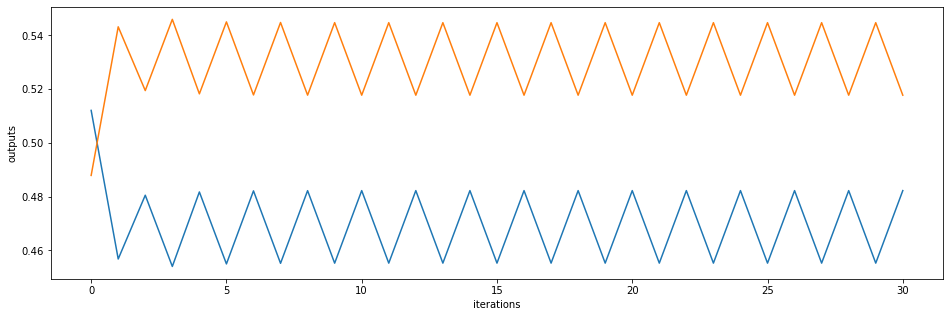

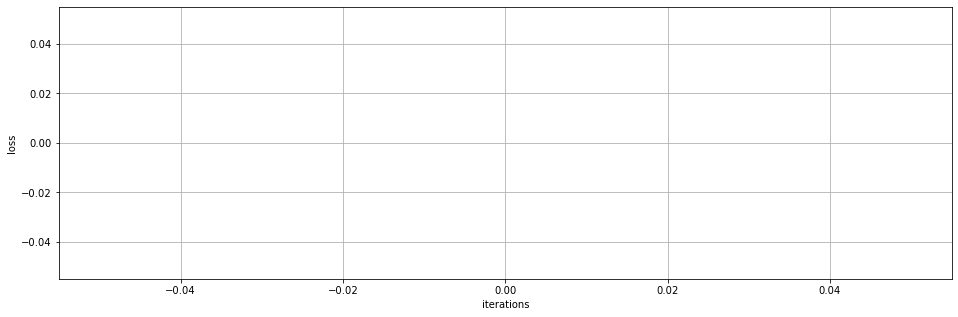

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 1
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41738651]
 [ 0.49627263]]
gradient[[-0.02799783]
 [ 0.05935197]
 [ 0.0120728 ]
 [-0.01948017]]
gradient[[ 0.49924254]
 [-0.53967943]]
gradient[[ 0.01501719]
 [-0.03166372]
 [-0.0058932 ]
 [ 0.0095836 ]]
gradient[[-0.41233415]
 [ 0.49577834]]
gradient[[-0.02962456]
 [ 0.06282458]
 [ 0.01247891]
 [-0.0207517 ]]
gradient[[ 0.4993342 ]
 [-0.53715697]]
gradient[[ 0.01404413]
 [-0.02960708]
 [-0.00548981]
 [ 0.00894283]]
gradient[[-0.41404131]
 [ 0.49594914]]
gradient[[-0.0290907 ]
 [ 0.06168464]
 [ 0.01225351]
 [-0.02034076]]
gradient[[ 0.49936352]
 [-0.53631495]]
gradient[[ 0.0137215 ]
 [-0.02892411]
 [-0.00536501]
 [ 0.00872925]]
gradient[[-0.414455

 [-0.53613262]]
gradient[[ 0.01365521]
 [-0.02877302]
 [-0.00533498]
 [ 0.00868625]]
gradient[[-0.4145706 ]
 [ 0.49600131]]
gradient[[-0.02893273]
 [ 0.06132462]
 [ 0.01217732]
 [-0.02021956]]
gradient[[ 0.49936973]
 [-0.53613436]]
gradient[[ 0.01365615]
 [-0.02877412]
 [-0.00533496]
 [ 0.00868697]]
gradient[[-0.41457029]
 [ 0.49600128]]
gradient[[-0.0289327 ]
 [ 0.06132495]
 [ 0.01217748]
 [-0.02021951]]
gradient[[ 0.49936971]
 [-0.53613505]]
gradient[[ 0.01365652]
 [-0.02877457]
 [-0.00533496]
 [ 0.00868725]]
gradient[[-0.41456988]
 [ 0.49600124]]
gradient[[-0.02893333]
 [ 0.06132472]
 [ 0.01217703]
 [-0.02022011]]
gradient[[ 0.49936972]
 [-0.53613461]]
gradient[[ 0.01365626]
 [-0.02877431]
 [-0.00533499]
 [ 0.00868704]]
gradient[[-0.41456973]
 [ 0.49600122]]
gradient[[-0.02893348]
 [ 0.06132471]
 [ 0.01217695]
 [-0.02022025]]
gradient[[ 0.4993697 ]
 [-0.53613535]]
gradient[[ 0.01365665]
 [-0.0287748 ]
 [-0.005335  ]
 [ 0.00868734]]
gradient[[-0.41456944]
 [ 0.49600119]]
gradient[[-0

 [ 0.00870933]]
gradient[[-0.41452693]
 [ 0.49599702]]
gradient[[-0.02895352]
 [ 0.0613462 ]
 [ 0.01217576]
 [-0.02023742]]
gradient[[ 0.49936846]
 [-0.53617139]]
gradient[[ 0.01367387]
 [-0.02880021]
 [-0.00533691]
 [ 0.00869999]]
gradient[[-0.41455056]
 [ 0.49599934]]
gradient[[-0.0289463 ]
 [ 0.06133041]
 [ 0.01217252]
 [-0.02023179]]
gradient[[ 0.49936876]
 [-0.53616277]]
gradient[[ 0.01367068]
 [-0.02879315]
 [-0.00533555]
 [ 0.00869788]]
gradient[[-0.41455651]
 [ 0.49599992]]
gradient[[-0.02894474]
 [ 0.06132619]
 [ 0.01217145]
 [-0.02023062]]
gradient[[ 0.49936878]
 [-0.53616213]]
gradient[[ 0.01367072]
 [-0.02879233]
 [-0.00533518]
 [ 0.00869801]]
gradient[[-0.41455781]
 [ 0.49600005]]
gradient[[-0.02894423]
 [ 0.06132546]
 [ 0.01217138]
 [-0.02023019]]
gradient[[ 0.49936877]
 [-0.5361622 ]]
gradient[[ 0.01367085]
 [-0.02879228]
 [-0.00533509]
 [ 0.00869812]]
gradient[[-0.4145578 ]
 [ 0.49600005]]
gradient[[-0.02894472]
 [ 0.06132496]
 [ 0.01217088]
 [-0.02023069]]
gradient[[ 0

 [ 0.49599913]]
gradient[[-0.02895351]
 [ 0.06132519]
 [ 0.01216617]
 [-0.02023884]]
gradient[[ 0.49936801]
 [-0.53618455]]
gradient[[ 0.0136827 ]
 [-0.02880681]
 [-0.00533515]
 [ 0.00870713]]
gradient[[-0.41454804]
 [ 0.49599909]]
gradient[[-0.02895413]
 [ 0.06132496]
 [ 0.01216572]
 [-0.02023944]]
gradient[[ 0.49936802]
 [-0.53618412]]
gradient[[ 0.01368244]
 [-0.02880656]
 [-0.00533517]
 [ 0.00870693]]
gradient[[-0.41454788]
 [ 0.49599908]]
gradient[[-0.02895428]
 [ 0.06132495]
 [ 0.01216564]
 [-0.02023958]]
gradient[[ 0.499368  ]
 [-0.53618486]]
gradient[[ 0.01368283]
 [-0.02880704]
 [-0.00533518]
 [ 0.00870722]]
gradient[[-0.4145476 ]
 [ 0.49599905]]
gradient[[-0.02895465]
 [ 0.06132485]
 [ 0.01216539]
 [-0.02023993]]
gradient[[ 0.49936794]
 [-0.53618659]]
gradient[[ 0.01368377]
 [-0.02880814]
 [-0.00533516]
 [ 0.00870794]]
---------------
epoch 9
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41736267]
 [ 0

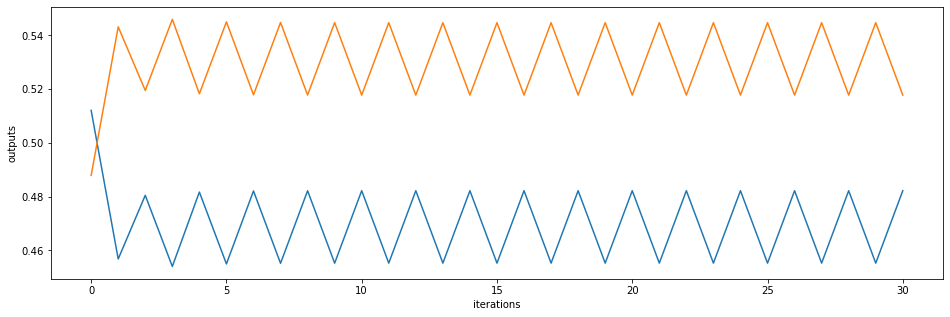

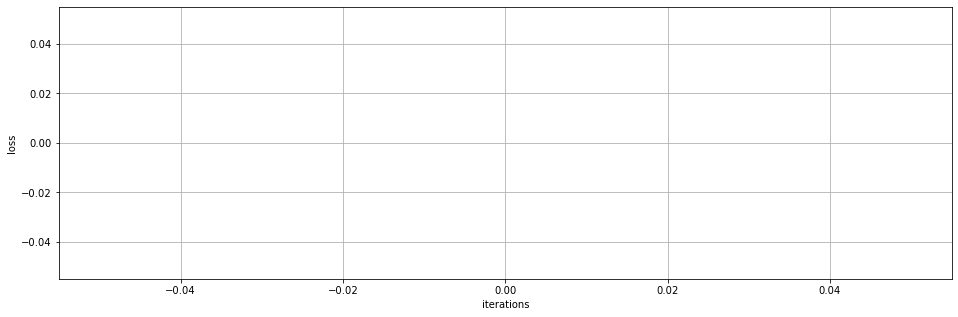

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 11
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41735672]
 [ 0.49626981]]
gradient[[-0.02802978]
 [ 0.05934821]
 [ 0.01205403]
 [-0.01951016]]
gradient[[ 0.49923883]
 [-0.53977829]]
gradient[[ 0.01507087]
 [-0.03172679]
 [-0.00589234]
 [ 0.0096249 ]]
gradient[[-0.41229041]
 [ 0.49577392]]
gradient[[-0.02966702]
 [ 0.06282394]
 [ 0.01245532]
 [-0.02079131]]
gradient[[ 0.49933069]
 [-0.53725637]]
gradient[[ 0.01409717]
 [-0.02967138]
 [-0.00548973]
 [ 0.00898328]]
gradient[[-0.41399762]
 [ 0.49594482]]
gradient[[-0.02913252]
 [ 0.06168483]
 [ 0.01223064]
 [-0.02037966]]
gradient[[ 0.49936011]
 [-0.53641399]]
gradient[[ 0.01377399]
 [-0.02898852]
 [-0.00536528]
 [ 0.00876914]]
gradient[[-0.41441

 [ 0.49599702]]
gradient[[-0.02897432]
 [ 0.0613251 ]
 [ 0.01215471]
 [-0.0202582 ]]
gradient[[ 0.49936633]
 [-0.53623329]]
gradient[[ 0.0137085 ]
 [-0.02883853]
 [-0.00533531]
 [ 0.00872672]]
gradient[[-0.41452663]
 [ 0.49599699]]
gradient[[-0.0289743 ]
 [ 0.06132543]
 [ 0.01215487]
 [-0.02025815]]
gradient[[ 0.49936631]
 [-0.53623398]]
gradient[[ 0.01370886]
 [-0.02883898]
 [-0.00533531]
 [ 0.008727  ]]
gradient[[-0.41452622]
 [ 0.49599695]]
gradient[[-0.02897492]
 [ 0.06132519]
 [ 0.01215442]
 [-0.02025875]]
gradient[[ 0.49936632]
 [-0.53623354]]
gradient[[ 0.0137086 ]
 [-0.02883872]
 [-0.00533534]
 [ 0.00872679]]
gradient[[-0.41452606]
 [ 0.49599693]]
gradient[[-0.02897507]
 [ 0.06132519]
 [ 0.01215434]
 [-0.02025889]]
gradient[[ 0.4993663 ]
 [-0.53623428]]
gradient[[ 0.01370899]
 [-0.02883921]
 [-0.00533535]
 [ 0.00872709]]
gradient[[-0.41452578]
 [ 0.49599691]]
gradient[[-0.02897544]
 [ 0.06132509]
 [ 0.01215409]
 [-0.02025924]]
gradient[[ 0.49936624]
 [-0.536236  ]]
gradient[[ 0

gradient[[ 0.49932894]
 [-0.53730593]]
gradient[[ 0.01412364]
 [-0.0297034 ]
 [-0.00548967]
 [ 0.00900348]]
gradient[[-0.41397582]
 [ 0.49594266]]
gradient[[-0.0291534 ]
 [ 0.06168491]
 [ 0.01221922]
 [-0.02039908]]
gradient[[ 0.4993584 ]
 [-0.53646338]]
gradient[[ 0.01380019]
 [-0.0290206 ]
 [-0.00536538]
 [ 0.00878906]]
gradient[[-0.41439004]
 [ 0.49598355]]
gradient[[-0.02902368]
 [ 0.06140908]
 [ 0.01216585]
 [-0.02029827]]
gradient[[ 0.49936381]
 [-0.53630651]]
gradient[[ 0.01374015]
 [-0.02889373]
 [-0.00534245]
 [ 0.00874908]]
gradient[[-0.41448333]
 [ 0.49599273]]
gradient[[-0.0289951 ]
 [ 0.06134663]
 [ 0.01215314]
 [-0.02027605]]
gradient[[ 0.49936506]
 [-0.53627022]]
gradient[[ 0.01372619]
 [-0.02886453]
 [-0.00533723]
 [ 0.00873973]]
gradient[[-0.41450694]
 [ 0.49599505]]
gradient[[-0.02898787]
 [ 0.06133087]
 [ 0.01214991]
 [-0.02027042]]
gradient[[ 0.49936536]
 [-0.53626161]]
gradient[[ 0.01372299]
 [-0.02885748]
 [-0.00533588]
 [ 0.00873762]]
gradient[[-0.41451289]
 [ 0.

gradient[[-0.41450484]
 [ 0.49599485]]
gradient[[-0.02899506]
 [ 0.06132565]
 [ 0.01214357]
 [-0.02027745]]
gradient[[ 0.49936461]
 [-0.53628331]]
gradient[[ 0.01373499]
 [-0.02887106]
 [-0.00533546]
 [ 0.00874685]]
gradient[[-0.41450443]
 [ 0.49599481]]
gradient[[-0.02899568]
 [ 0.06132541]
 [ 0.01214313]
 [-0.02027804]]
gradient[[ 0.49936463]
 [-0.53628287]]
gradient[[ 0.01373473]
 [-0.02887081]
 [-0.00533548]
 [ 0.00874665]]
gradient[[-0.41450428]
 [ 0.49599479]]
gradient[[-0.02899583]
 [ 0.06132541]
 [ 0.01214304]
 [-0.02027818]]
gradient[[ 0.4993646 ]
 [-0.53628361]]
gradient[[ 0.01373512]
 [-0.02887129]
 [-0.00533549]
 [ 0.00874694]]
gradient[[-0.41450399]
 [ 0.49599476]]
gradient[[-0.0289962 ]
 [ 0.06132531]
 [ 0.0121428 ]
 [-0.02027854]]
gradient[[ 0.49936454]
 [-0.53628533]]
gradient[[ 0.01373606]
 [-0.02887239]
 [-0.00533547]
 [ 0.00874766]]
---------------
epoch 19
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gra

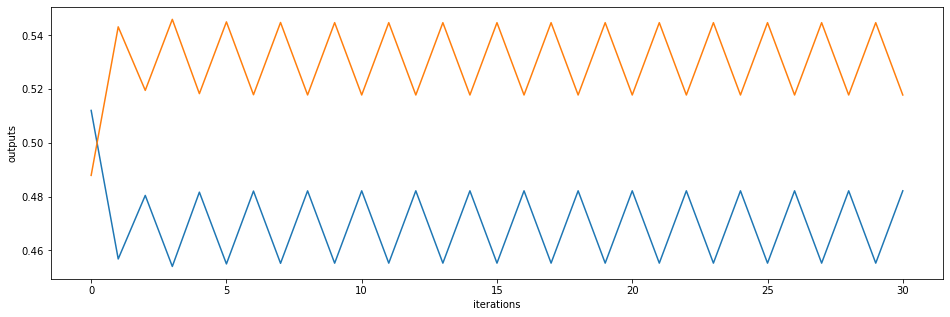

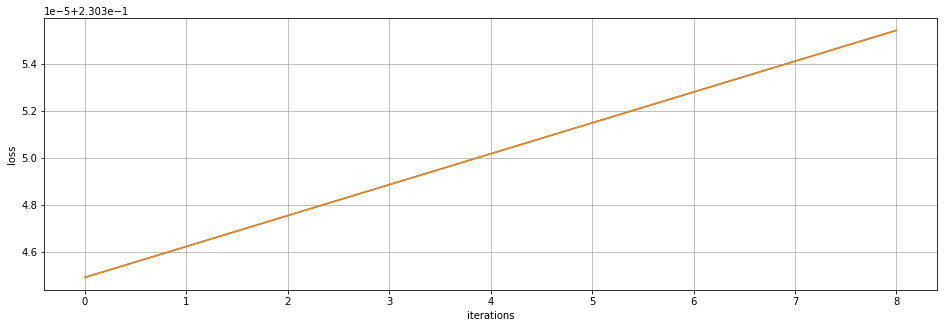

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 21
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41732701]
 [ 0.496267  ]]
gradient[[-0.02806165]
 [ 0.05934447]
 [ 0.01203529]
 [-0.01954007]]
gradient[[ 0.49923513]
 [-0.5398768 ]]
gradient[[ 0.01512443]
 [-0.03178956]
 [-0.00589142]
 [ 0.00966612]]
gradient[[-0.4122468]
 [ 0.4957695]]
gradient[[-0.02970938]
 [ 0.06282326]
 [ 0.01243177]
 [-0.02083084]]
gradient[[ 0.49932719]
 [-0.5373554 ]]
gradient[[ 0.01415009]
 [-0.02973535]
 [-0.00548958]
 [ 0.00902366]]
gradient[[-0.41395405]
 [ 0.4959405 ]]
gradient[[-0.02917425]
 [ 0.06168498]
 [ 0.01220781]
 [-0.02041848]]
gradient[[ 0.49935669]
 [-0.53651268]]
gradient[[ 0.01382637]
 [-0.02905261]
 [-0.00536547]
 [ 0.00880897]]
gradient[[-0.4143682

 [-0.53633186]]
gradient[[ 0.01376073]
 [-0.02890263]
 [-0.00533559]
 [ 0.00876641]]
gradient[[-0.41448309]
 [ 0.49599271]]
gradient[[-0.02901581]
 [ 0.06132586]
 [ 0.01213228]
 [-0.02029672]]
gradient[[ 0.49936292]
 [-0.53633255]]
gradient[[ 0.01376109]
 [-0.02890307]
 [-0.00533559]
 [ 0.00876668]]
gradient[[-0.41448268]
 [ 0.49599267]]
gradient[[-0.02901643]
 [ 0.06132563]
 [ 0.01213184]
 [-0.02029732]]
gradient[[ 0.49936293]
 [-0.53633211]]
gradient[[ 0.01376083]
 [-0.02890282]
 [-0.00533561]
 [ 0.00876648]]
gradient[[-0.41448252]
 [ 0.49599265]]
gradient[[-0.02901658]
 [ 0.06132562]
 [ 0.01213176]
 [-0.02029746]]
gradient[[ 0.49936291]
 [-0.53633285]]
gradient[[ 0.01376122]
 [-0.0289033 ]
 [-0.00533562]
 [ 0.00876677]]
gradient[[-0.41448224]
 [ 0.49599262]]
gradient[[-0.02901695]
 [ 0.06132553]
 [ 0.01213151]
 [-0.02029781]]
gradient[[ 0.49936285]
 [-0.53633457]]
gradient[[ 0.01376216]
 [-0.02890439]
 [-0.0053356 ]
 [ 0.00876749]]
---------------
epoch 24
gradient[[ 0.49970757]
 [-

 [ 0.00878522]]
gradient[[-0.41446192]
 [ 0.49599063]]
gradient[[-0.02903619]
 [ 0.06132586]
 [ 0.0121211 ]
 [-0.02031568]]
gradient[[ 0.4993613 ]
 [-0.53637929]]
gradient[[ 0.01378586]
 [-0.02893347]
 [-0.00533572]
 [ 0.0087855 ]]
gradient[[-0.41446166]
 [ 0.4959906 ]]
gradient[[-0.02903655]
 [ 0.06132574]
 [ 0.01212085]
 [-0.02031602]]
gradient[[ 0.49936125]
 [-0.53638101]]
gradient[[ 0.0137868 ]
 [-0.02893456]
 [-0.0053357 ]
 [ 0.00878622]]
gradient[[-0.41446136]
 [ 0.49599057]]
gradient[[-0.02903653]
 [ 0.06132607]
 [ 0.012121  ]
 [-0.02031598]]
gradient[[ 0.49936122]
 [-0.5363817 ]]
gradient[[ 0.01378717]
 [-0.028935  ]
 [-0.0053357 ]
 [ 0.0087865 ]]
gradient[[-0.41446095]
 [ 0.49599053]]
gradient[[-0.02903715]
 [ 0.06132583]
 [ 0.01212056]
 [-0.02031657]]
gradient[[ 0.49936124]
 [-0.53638126]]
gradient[[ 0.01378691]
 [-0.02893475]
 [-0.00533572]
 [ 0.0087863 ]]
gradient[[-0.4144608 ]
 [ 0.49599052]]
gradient[[-0.0290373 ]
 [ 0.06132583]
 [ 0.01212048]
 [-0.02031671]]
gradient[[ 0

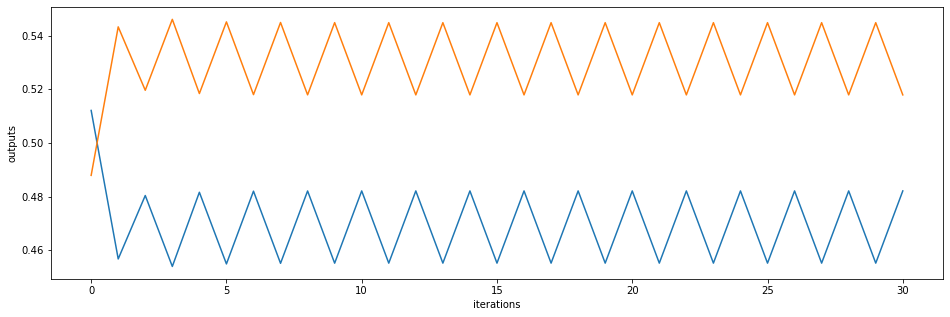

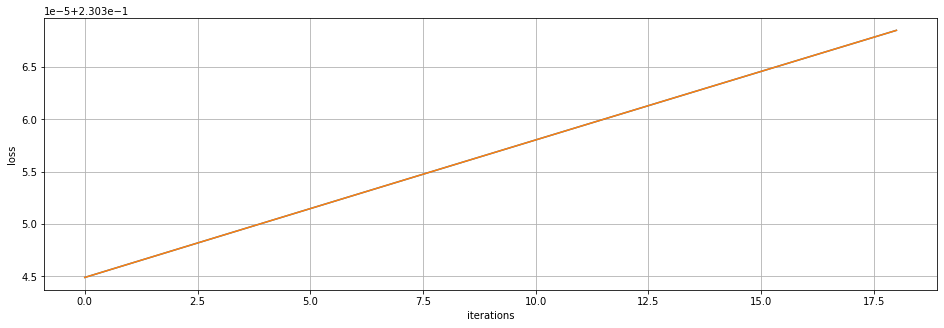

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 31
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41729736]
 [ 0.4962642 ]]
gradient[[-0.02809344]
 [ 0.05934073]
 [ 0.01201661]
 [-0.01956992]]
gradient[[ 0.49923143]
 [-0.53997495]]
gradient[[ 0.01517787]
 [-0.03185201]
 [-0.00589043]
 [ 0.00970727]]
gradient[[-0.41220331]
 [ 0.49576509]]
gradient[[-0.02975166]
 [ 0.06282255]
 [ 0.01240825]
 [-0.0208703 ]]
gradient[[ 0.4993237 ]
 [-0.53745407]]
gradient[[ 0.0142029 ]
 [-0.02979902]
 [-0.00548936]
 [ 0.00906398]]
gradient[[-0.4139106]
 [ 0.4959362]]
gradient[[-0.02921591]
 [ 0.06168509]
 [ 0.012185  ]
 [-0.02045723]]
gradient[[ 0.49935328]
 [-0.53661101]]
gradient[[ 0.01387862]
 [-0.02911639]
 [-0.0053656 ]
 [ 0.00884873]]
gradient[[-0.4143248

gradient[[ 0.49935955]
 [-0.53643007]]
gradient[[ 0.01381285]
 [-0.02896641]
 [-0.00533579]
 [ 0.00880603]]
gradient[[-0.41443966]
 [ 0.49598844]]
gradient[[-0.02905723]
 [ 0.06132626]
 [ 0.01210973]
 [-0.02033522]]
gradient[[ 0.49935953]
 [-0.53643076]]
gradient[[ 0.01381321]
 [-0.02896686]
 [-0.00533579]
 [ 0.0088063 ]]
gradient[[-0.41443926]
 [ 0.4959884 ]]
gradient[[-0.02905785]
 [ 0.06132603]
 [ 0.01210929]
 [-0.02033581]]
gradient[[ 0.49935954]
 [-0.53643032]]
gradient[[ 0.01381295]
 [-0.0289666 ]
 [-0.00533582]
 [ 0.0088061 ]]
gradient[[-0.4144391 ]
 [ 0.49598838]]
gradient[[-0.029058  ]
 [ 0.06132602]
 [ 0.01210921]
 [-0.02033595]]
gradient[[ 0.49935952]
 [-0.53643106]]
gradient[[ 0.01381334]
 [-0.02896708]
 [-0.00533582]
 [ 0.0088064 ]]
gradient[[-0.41443882]
 [ 0.49598835]]
gradient[[-0.02905837]
 [ 0.06132593]
 [ 0.01210896]
 [-0.0203363 ]]
gradient[[ 0.49935946]
 [-0.53643277]]
gradient[[ 0.01381427]
 [-0.02896817]
 [-0.0053358 ]
 [ 0.00880711]]
---------------
epoch 34
gra

gradient[[ 0.49935858]
 [-0.5364582 ]]
gradient[[ 0.01382729]
 [-0.02898519]
 [-0.00533632]
 [ 0.0088169 ]]
gradient[[-0.41442599]
 [ 0.49598709]]
gradient[[-0.0290692 ]
 [ 0.06132747]
 [ 0.01210373]
 [-0.02034626]]
gradient[[ 0.4993586 ]
 [-0.53645755]]
gradient[[ 0.01382733]
 [-0.02898437]
 [-0.00533595]
 [ 0.00881701]]
gradient[[-0.41442728]
 [ 0.49598722]]
gradient[[-0.02906869]
 [ 0.06132674]
 [ 0.01210366]
 [-0.02034584]]
gradient[[ 0.4993586 ]
 [-0.53645762]]
gradient[[ 0.01382745]
 [-0.02898431]
 [-0.00533586]
 [ 0.00881713]]
gradient[[-0.41442728]
 [ 0.49598722]]
gradient[[-0.02906918]
 [ 0.06132624]
 [ 0.01210317]
 [-0.02034633]]
gradient[[ 0.49935862]
 [-0.53645705]]
gradient[[ 0.01382715]
 [-0.02898395]
 [-0.00533586]
 [ 0.0088169 ]]
gradient[[-0.41442722]
 [ 0.49598721]]
gradient[[-0.02906931]
 [ 0.06132617]
 [ 0.01210307]
 [-0.02034645]]
gradient[[ 0.49935859]
 [-0.53645776]]
gradient[[ 0.01382752]
 [-0.02898441]
 [-0.00533586]
 [ 0.00881718]]
gradient[[-0.41442696]
 [ 0.

 [ 0.00882618]]
gradient[[-0.41441715]
 [ 0.49598622]]
gradient[[-0.02907905]
 [ 0.06132611]
 [ 0.0120977 ]
 [-0.02035552]]
gradient[[ 0.49935776]
 [-0.53648174]]
gradient[[ 0.01384029]
 [-0.02899994]
 [-0.00533588]
 [ 0.0088269 ]]
---------------
epoch 39
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41727369]
 [ 0.49626196]]
gradient[[-0.02811882]
 [ 0.05933775]
 [ 0.01200169]
 [-0.01959374]]
gradient[[ 0.49922847]
 [-0.54005321]]
gradient[[ 0.01522053]
 [-0.03190176]
 [-0.00588959]
 [ 0.00974014]]
gradient[[-0.41216861]
 [ 0.49576157]]
gradient[[-0.02978543]
 [ 0.06282195]
 [ 0.01238946]
 [-0.0209018 ]]
gradient[[ 0.4993209 ]
 [-0.53753274]]
gradient[[ 0.01424506]
 [-0.02984972]
 [-0.00548913]
 [ 0.00909618]]
gradient[[-0.41387593]
 [ 0.49593276]]
gradient[[-0.02924917]
 [ 0.06168516]
 [ 0.01216678]
 [-0.02048818]]
gradient[[ 0.49935056]
 [-0.53668941]]
gradient[[ 0.01392035]
 [-0.02916719]
 [-0.00536564]
 [ 

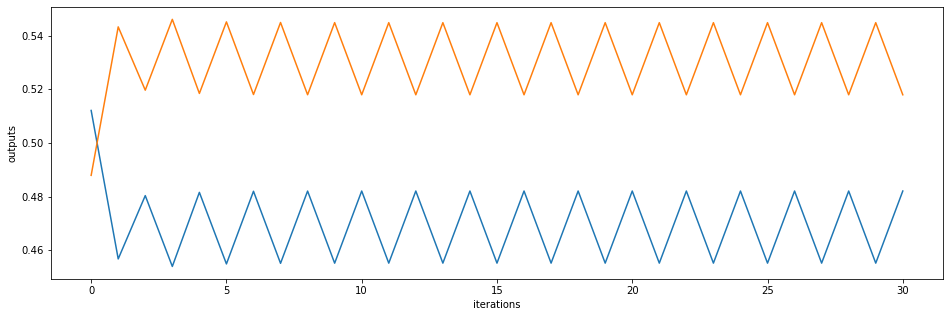

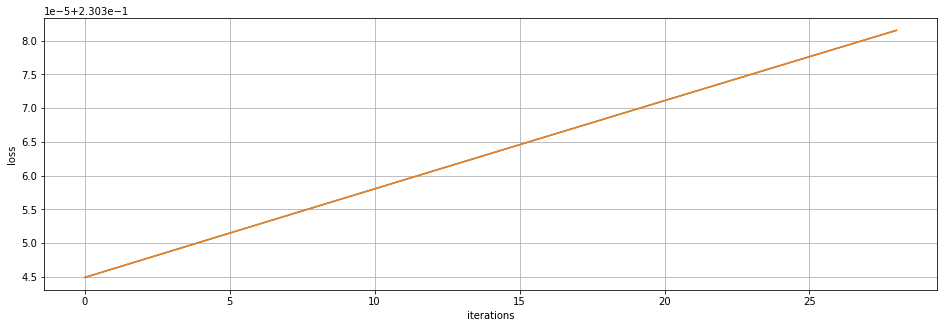

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 41
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41726778]
 [ 0.4962614 ]]
gradient[[-0.02812516]
 [ 0.059337  ]
 [ 0.01199796]
 [-0.01959969]]
gradient[[ 0.49922774]
 [-0.54007273]]
gradient[[ 0.01523118]
 [-0.03191416]
 [-0.00588938]
 [ 0.00974835]]
gradient[[-0.41215995]
 [ 0.4957607 ]]
gradient[[-0.02979386]
 [ 0.0628218 ]
 [ 0.01238477]
 [-0.02090967]]
gradient[[ 0.49932021]
 [-0.53755237]]
gradient[[ 0.01425559]
 [-0.02986237]
 [-0.00548907]
 [ 0.00910423]]
gradient[[-0.41386728]
 [ 0.49593191]]
gradient[[-0.02925747]
 [ 0.06168517]
 [ 0.01216223]
 [-0.0204959 ]]
gradient[[ 0.49934988]
 [-0.53670897]]
gradient[[ 0.01393077]
 [-0.02917986]
 [-0.00536565]
 [ 0.00888842]]
gradient[[-0.41428

 [ 0.00884458]]
gradient[[-0.41439692]
 [ 0.49598423]]
gradient[[-0.02909824]
 [ 0.06132642]
 [ 0.01208731]
 [-0.02037334]]
gradient[[ 0.49935623]
 [-0.53652622]]
gradient[[ 0.01386391]
 [-0.02902881]
 [-0.00533595]
 [ 0.00884486]]
gradient[[-0.41439666]
 [ 0.49598421]]
gradient[[-0.0290986 ]
 [ 0.0613263 ]
 [ 0.01208706]
 [-0.02037368]]
gradient[[ 0.49935617]
 [-0.53652793]]
gradient[[ 0.01386485]
 [-0.02902989]
 [-0.00533593]
 [ 0.00884558]]
gradient[[-0.41439636]
 [ 0.49598418]]
gradient[[-0.02909857]
 [ 0.06132663]
 [ 0.01208721]
 [-0.02037364]]
gradient[[ 0.49935614]
 [-0.53652861]]
gradient[[ 0.01386521]
 [-0.02903033]
 [-0.00533592]
 [ 0.00884586]]
gradient[[-0.41439595]
 [ 0.49598414]]
gradient[[-0.02909919]
 [ 0.06132639]
 [ 0.01208677]
 [-0.02037423]]
gradient[[ 0.49935616]
 [-0.53652817]]
gradient[[ 0.01386495]
 [-0.02903008]
 [-0.00533595]
 [ 0.00884566]]
gradient[[-0.4143958 ]
 [ 0.49598412]]
gradient[[-0.02909934]
 [ 0.06132639]
 [ 0.01208669]
 [-0.02037437]]
gradient[[ 0

gradient[[-0.41426   ]
 [ 0.49597074]]
gradient[[-0.02914799]
 [ 0.06140996]
 [ 0.01209804]
 [-0.02041382]]
gradient[[ 0.49935364]
 [-0.53660083]]
gradient[[ 0.01389647]
 [-0.02908474]
 [-0.00534293]
 [ 0.00886797]]
gradient[[-0.41435322]
 [ 0.49597993]]
gradient[[-0.02911932]
 [ 0.06134771]
 [ 0.01208546]
 [-0.02039149]]
gradient[[ 0.4993549 ]
 [-0.53656457]]
gradient[[ 0.01388246]
 [-0.02905561]
 [-0.00533777]
 [ 0.00885856]]
gradient[[-0.41437679]
 [ 0.49598225]]
gradient[[-0.02911208]
 [ 0.06133201]
 [ 0.01208227]
 [-0.02038584]]
gradient[[ 0.49935519]
 [-0.53655596]]
gradient[[ 0.01387926]
 [-0.02904858]
 [-0.00533643]
 [ 0.00885644]]
gradient[[-0.41438272]
 [ 0.49598283]]
gradient[[-0.02911051]
 [ 0.06132782]
 [ 0.01208121]
 [-0.02038466]]
gradient[[ 0.49935522]
 [-0.53655531]]
gradient[[ 0.0138793 ]
 [-0.02904775]
 [-0.00533606]
 [ 0.00885655]]
gradient[[-0.41438401]
 [ 0.49598296]]
gradient[[-0.02911001]
 [ 0.06132709]
 [ 0.01208115]
 [-0.02038424]]
gradient[[ 0.49935521]
 [-0.

gradient[[ 0.49935445]
 [-0.5365774 ]]
gradient[[ 0.01389117]
 [-0.02906195]
 [-0.00533596]
 [ 0.00886561]]
gradient[[-0.41437435]
 [ 0.49598201]]
gradient[[-0.02911983]
 [ 0.06132656]
 [ 0.01207552]
 [-0.02039341]]
gradient[[ 0.49935447]
 [-0.53657697]]
gradient[[ 0.01389091]
 [-0.0290617 ]
 [-0.00533599]
 [ 0.00886541]]
gradient[[-0.41437419]
 [ 0.49598199]]
gradient[[-0.02911998]
 [ 0.06132655]
 [ 0.01207544]
 [-0.02039355]]
gradient[[ 0.49935444]
 [-0.5365777 ]]
gradient[[ 0.0138913 ]
 [-0.02906218]
 [-0.005336  ]
 [ 0.0088657 ]]
gradient[[-0.41437391]
 [ 0.49598197]]
gradient[[-0.02912035]
 [ 0.06132646]
 [ 0.01207519]
 [-0.0203939 ]]
gradient[[ 0.49935438]
 [-0.5365794 ]]
gradient[[ 0.01389223]
 [-0.02906325]
 [-0.00533597]
 [ 0.00886642]]
---------------
epoch 49
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41724417]
 [ 0.49625916]]
gradient[[-0.02815047]
 [ 0.05933403]
 [ 0.01198308]
 [-0.01962346]]
gra

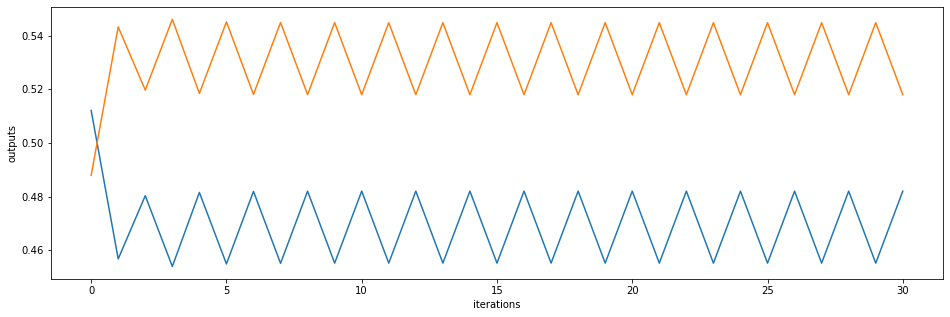

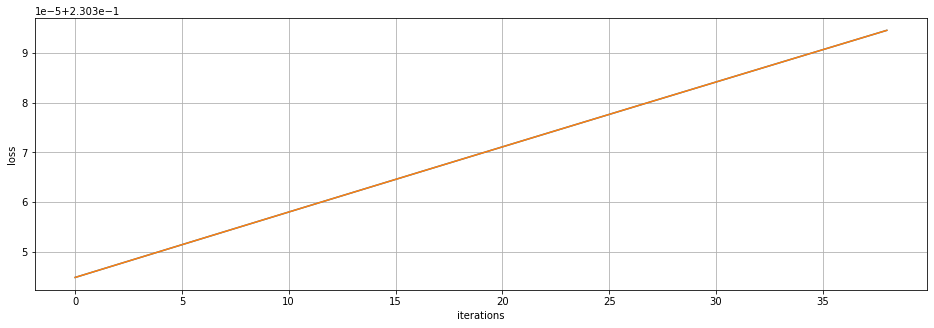

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 51
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41723828]
 [ 0.49625861]]
gradient[[-0.0281568 ]
 [ 0.05933328]
 [ 0.01197936]
 [-0.01962939]]
gradient[[ 0.49922405]
 [-0.54017016]]
gradient[[ 0.01528437]
 [-0.03197601]
 [-0.00588826]
 [ 0.00978935]]
gradient[[-0.41211671]
 [ 0.49575631]]
gradient[[-0.02983596]
 [ 0.06282101]
 [ 0.01236131]
 [-0.02094897]]
gradient[[ 0.49931672]
 [-0.53765031]]
gradient[[ 0.01430816]
 [-0.0299254 ]
 [-0.00548871]
 [ 0.0091444 ]]
gradient[[-0.41382408]
 [ 0.49592762]]
gradient[[-0.02929895]
 [ 0.06168521]
 [ 0.01213948]
 [-0.0205345 ]]
gradient[[ 0.49934648]
 [-0.53680658]]
gradient[[ 0.01398279]
 [-0.02924302]
 [-0.00536563]
 [ 0.00892805]]
gradient[[-0.41423

 [ 0.49597998]]
gradient[[-0.02913888]
 [ 0.06132731]
 [ 0.01206541]
 [-0.02041107]]
gradient[[ 0.49935285]
 [-0.53662359]]
gradient[[ 0.01391574]
 [-0.02909189]
 [-0.00533601]
 [ 0.0088843 ]]
gradient[[-0.41435379]
 [ 0.49597998]]
gradient[[-0.02913937]
 [ 0.06132682]
 [ 0.01206491]
 [-0.02041156]]
gradient[[ 0.49935287]
 [-0.53662302]]
gradient[[ 0.01391543]
 [-0.02909153]
 [-0.00533602]
 [ 0.00888407]]
gradient[[-0.41435373]
 [ 0.49597998]]
gradient[[-0.02913949]
 [ 0.06132674]
 [ 0.01206482]
 [-0.02041168]]
gradient[[ 0.49935284]
 [-0.53662372]]
gradient[[ 0.0139158 ]
 [-0.02909198]
 [-0.00533602]
 [ 0.00888435]]
gradient[[-0.41435348]
 [ 0.49597995]]
gradient[[-0.02913985]
 [ 0.06132663]
 [ 0.01206457]
 [-0.02041202]]
gradient[[ 0.49935278]
 [-0.53662542]]
gradient[[ 0.01391674]
 [-0.02909305]
 [-0.00533599]
 [ 0.00888507]]
gradient[[-0.41435318]
 [ 0.49597992]]
gradient[[-0.02913983]
 [ 0.06132695]
 [ 0.01206472]
 [-0.02041198]]
gradient[[ 0.49935276]
 [-0.5366261 ]]
gradient[[ 0

gradient[[-0.41209514]
 [ 0.49575412]]
gradient[[-0.02985698]
 [ 0.06282061]
 [ 0.0123496 ]
 [-0.02096859]]
gradient[[ 0.49931498]
 [-0.53769915]]
gradient[[ 0.0143344 ]
 [-0.0299568 ]
 [-0.0054885 ]
 [ 0.00916447]]
gradient[[-0.41380252]
 [ 0.49592548]]
gradient[[-0.02931966]
 [ 0.06168521]
 [ 0.01212812]
 [-0.02055377]]
gradient[[ 0.49934478]
 [-0.53685524]]
gradient[[ 0.01400876]
 [-0.02927448]
 [-0.0053656 ]
 [ 0.00894784]]
gradient[[-0.4142169 ]
 [ 0.49596649]]
gradient[[-0.02918925]
 [ 0.06141018]
 [ 0.01207549]
 [-0.02045218]]
gradient[[ 0.49935025]
 [-0.53669822]]
gradient[[ 0.01394835]
 [-0.02914779]
 [-0.00534295]
 [ 0.00890746]]
gradient[[-0.4143101 ]
 [ 0.49597568]]
gradient[[-0.02916056]
 [ 0.06134799]
 [ 0.01206296]
 [-0.02042982]]
gradient[[ 0.49935151]
 [-0.53666196]]
gradient[[ 0.01393432]
 [-0.02911869]
 [-0.00533781]
 [ 0.00889803]]
gradient[[-0.41433365]
 [ 0.495978  ]]
gradient[[-0.02915332]
 [ 0.06133232]
 [ 0.01205978]
 [-0.02042417]]
gradient[[ 0.49935181]
 [-0.

 [-0.02043117]]
gradient[[ 0.49935109]
 [-0.53667404]]
gradient[[ 0.01394264]
 [-0.02912452]
 [-0.005336  ]
 [ 0.00890479]]
gradient[[-0.41433163]
 [ 0.4959778 ]]
gradient[[-0.02916043]
 [ 0.0613271 ]
 [ 0.01205349]
 [-0.02043112]]
gradient[[ 0.49935107]
 [-0.53667471]]
gradient[[ 0.013943  ]
 [-0.02912496]
 [-0.00533599]
 [ 0.00890507]]
gradient[[-0.41433123]
 [ 0.49597776]]
gradient[[-0.02916104]
 [ 0.06132687]
 [ 0.01205304]
 [-0.02043171]]
gradient[[ 0.49935109]
 [-0.53667428]]
gradient[[ 0.01394274]
 [-0.0291247 ]
 [-0.00533602]
 [ 0.00890486]]
gradient[[-0.41433107]
 [ 0.49597775]]
gradient[[-0.02916119]
 [ 0.06132686]
 [ 0.01205296]
 [-0.02043185]]
gradient[[ 0.49935106]
 [-0.53667501]]
gradient[[ 0.01394312]
 [-0.02912518]
 [-0.00533603]
 [ 0.00890516]]
gradient[[-0.4143308 ]
 [ 0.49597772]]
gradient[[-0.02916156]
 [ 0.06132676]
 [ 0.01205272]
 [-0.0204322 ]]
gradient[[ 0.499351  ]
 [-0.53667671]]
gradient[[ 0.01394406]
 [-0.02912625]
 [-0.005336  ]
 [ 0.00890587]]
------------

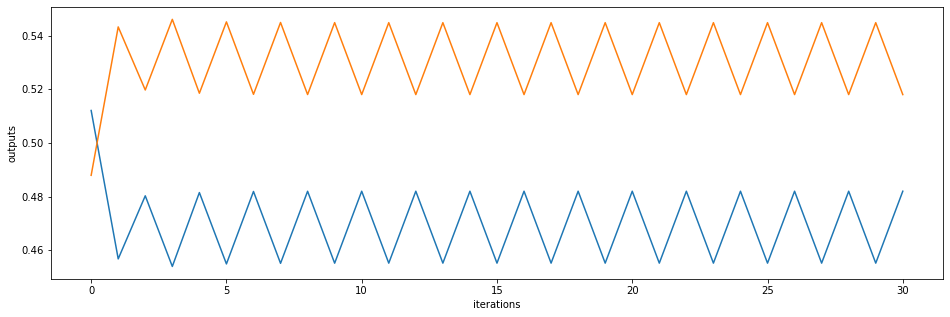

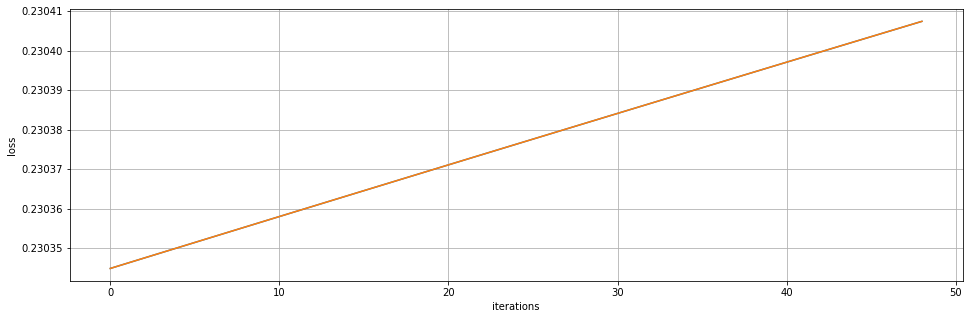

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 61
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41720884]
 [ 0.49625582]]
gradient[[-0.02818836]
 [ 0.05932957]
 [ 0.01196081]
 [-0.01965902]]
gradient[[ 0.49922037]
 [-0.54026722]]
gradient[[ 0.01533744]
 [-0.03203754]
 [-0.00588709]
 [ 0.00983028]]
gradient[[-0.4120736 ]
 [ 0.49575193]]
gradient[[-0.02987798]
 [ 0.06282019]
 [ 0.01233789]
 [-0.02098819]]
gradient[[ 0.49931324]
 [-0.53774789]]
gradient[[ 0.01436061]
 [-0.02998813]
 [-0.00548828]
 [ 0.00918451]]
gradient[[-0.413781  ]
 [ 0.49592335]]
gradient[[-0.02934035]
 [ 0.06168521]
 [ 0.01211677]
 [-0.02057302]]
gradient[[ 0.49934308]
 [-0.53690382]]
gradient[[ 0.0140347 ]
 [-0.02930586]
 [-0.00536555]
 [ 0.00896761]]
gradient[[-0.41419

 [ 0.49597571]]
gradient[[-0.02918102]
 [ 0.06132692]
 [ 0.01204211]
 [-0.02045029]]
gradient[[ 0.49934941]
 [-0.53672256]]
gradient[[ 0.01396851]
 [-0.02915591]
 [-0.00533599]
 [ 0.00892449]]
gradient[[-0.41431012]
 [ 0.49597568]]
gradient[[-0.029181  ]
 [ 0.06132724]
 [ 0.01204226]
 [-0.02045025]]
gradient[[ 0.49934938]
 [-0.53672324]]
gradient[[ 0.01396887]
 [-0.02915634]
 [-0.00533598]
 [ 0.00892477]]
gradient[[-0.41430971]
 [ 0.49597564]]
gradient[[-0.02918162]
 [ 0.06132701]
 [ 0.01204182]
 [-0.02045084]]
gradient[[ 0.4993494]
 [-0.5367228]]
gradient[[ 0.01396861]
 [-0.02915609]
 [-0.00533601]
 [ 0.00892457]]
gradient[[-0.41430956]
 [ 0.49597563]]
gradient[[-0.02918177]
 [ 0.061327  ]
 [ 0.01204174]
 [-0.02045098]]
gradient[[ 0.49934937]
 [-0.53672353]]
gradient[[ 0.01396899]
 [-0.02915657]
 [-0.00533602]
 [ 0.00892486]]
gradient[[-0.41430928]
 [ 0.4959756 ]]
gradient[[-0.02918213]
 [ 0.0613269 ]
 [ 0.01204149]
 [-0.02045132]]
gradient[[ 0.49934931]
 [-0.53672523]]
gradient[[ 0.0

 [-0.02046808]]
gradient[[ 0.49934814]
 [-0.536759  ]]
gradient[[ 0.01398607]
 [-0.02918145]
 [-0.00533779]
 [ 0.00893744]]
gradient[[-0.41429063]
 [ 0.49597376]]
gradient[[-0.02919447]
 [ 0.06133259]
 [ 0.01203732]
 [-0.02046241]]
gradient[[ 0.49934844]
 [-0.5367504 ]]
gradient[[ 0.01398286]
 [-0.02917444]
 [-0.00533646]
 [ 0.00893531]]
gradient[[-0.41429655]
 [ 0.49597434]]
gradient[[-0.02919289]
 [ 0.06132841]
 [ 0.01203628]
 [-0.02046123]]
gradient[[ 0.49934846]
 [-0.53674974]]
gradient[[ 0.01398289]
 [-0.0291736 ]
 [-0.00533608]
 [ 0.00893542]]
gradient[[-0.41429784]
 [ 0.49597447]]
gradient[[-0.02919239]
 [ 0.06132768]
 [ 0.01203622]
 [-0.02046081]]
gradient[[ 0.49934846]
 [-0.5367498 ]]
gradient[[ 0.01398302]
 [-0.02917355]
 [-0.00533599]
 [ 0.00893554]]
gradient[[-0.41429783]
 [ 0.49597447]]
gradient[[-0.02919288]
 [ 0.06132719]
 [ 0.01203572]
 [-0.0204613 ]]
gradient[[ 0.49934848]
 [-0.53674924]]
gradient[[ 0.01398271]
 [-0.02917319]
 [-0.005336  ]
 [ 0.00893531]]
gradient[[-0

 [-0.53677196]]
gradient[[ 0.01399483]
 [-0.02918788]
 [-0.00533599]
 [ 0.00894454]]
gradient[[-0.4142878 ]
 [ 0.49597348]]
gradient[[-0.02920269]
 [ 0.06132704]
 [ 0.01203028]
 [-0.02047043]]
gradient[[ 0.49934763]
 [-0.53677366]]
gradient[[ 0.01399576]
 [-0.02918895]
 [-0.00533596]
 [ 0.00894526]]
---------------
epoch 69
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41718535]
 [ 0.49625359]]
gradient[[-0.02821355]
 [ 0.0593266 ]
 [ 0.011946  ]
 [-0.01968267]]
gradient[[ 0.49921742]
 [-0.54034461]]
gradient[[ 0.0153798 ]
 [-0.03208656]
 [-0.00588611]
 [ 0.00986296]]
gradient[[-0.4120392 ]
 [ 0.49574844]]
gradient[[-0.02991153]
 [ 0.06281951]
 [ 0.01231918]
 [-0.0210195 ]]
gradient[[ 0.49931045]
 [-0.53782569]]
gradient[[ 0.01440248]
 [-0.03003808]
 [-0.00548789]
 [ 0.00921655]]
gradient[[-0.41374662]
 [ 0.49591993]]
gradient[[-0.0293734 ]
 [ 0.06168518]
 [ 0.01209862]
 [-0.02060378]]
gradient[[ 0.49934037]
 [-

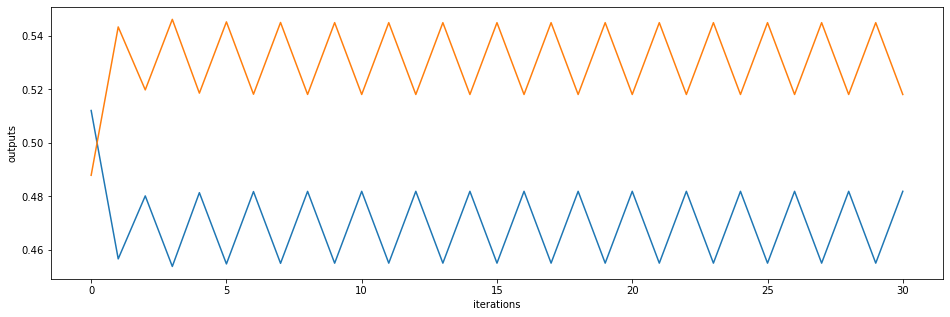

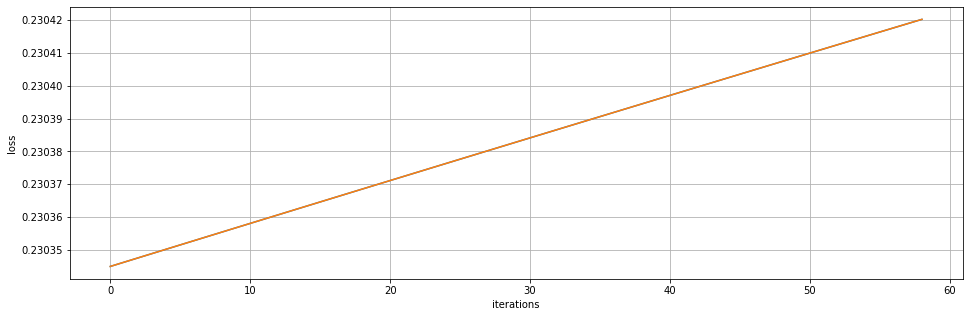

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 71
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41717948]
 [ 0.49625304]]
gradient[[-0.02821984]
 [ 0.05932586]
 [ 0.0119423 ]
 [-0.01968858]]
gradient[[ 0.49921669]
 [-0.54036392]]
gradient[[ 0.01539037]
 [-0.03209878]
 [-0.00588585]
 [ 0.00987113]]
gradient[[-0.41203061]
 [ 0.49574757]]
gradient[[-0.0299199 ]
 [ 0.06281933]
 [ 0.0123145 ]
 [-0.02102732]]
gradient[[ 0.49930976]
 [-0.5378451 ]]
gradient[[ 0.01441293]
 [-0.03005054]
 [-0.00548778]
 [ 0.00922455]]
gradient[[-0.41373804]
 [ 0.49591908]]
gradient[[-0.02938165]
 [ 0.06168517]
 [ 0.01209409]
 [-0.02061146]]
gradient[[ 0.49933969]
 [-0.5370007 ]]
gradient[[ 0.01408649]
 [-0.0293684 ]
 [-0.0053654 ]
 [ 0.0090071 ]]
gradient[[-0.41415

 [ 0.49597151]]
gradient[[-0.02922114]
 [ 0.06132786]
 [ 0.01202052]
 [-0.02048753]]
gradient[[ 0.4993461 ]
 [-0.53681751]]
gradient[[ 0.01401916]
 [-0.0292173 ]
 [-0.00533594]
 [ 0.00896308]]
gradient[[-0.41426779]
 [ 0.49597151]]
gradient[[-0.02922163]
 [ 0.06132736]
 [ 0.01202003]
 [-0.02048802]]
gradient[[ 0.49934612]
 [-0.53681695]]
gradient[[ 0.01401886]
 [-0.02921695]
 [-0.00533595]
 [ 0.00896285]]
gradient[[-0.41426773]
 [ 0.4959715 ]]
gradient[[-0.02922175]
 [ 0.06132729]
 [ 0.01201993]
 [-0.02048814]]
gradient[[ 0.49934609]
 [-0.53681765]]
gradient[[ 0.01401923]
 [-0.02921739]
 [-0.00533595]
 [ 0.00896313]]
gradient[[-0.41426747]
 [ 0.49597148]]
gradient[[-0.02922211]
 [ 0.06132717]
 [ 0.01201968]
 [-0.02048848]]
gradient[[ 0.49934603]
 [-0.53681934]]
gradient[[ 0.01402016]
 [-0.02921846]
 [-0.00533592]
 [ 0.00896384]]
gradient[[-0.41426718]
 [ 0.49597145]]
gradient[[-0.02922209]
 [ 0.0613275 ]
 [ 0.01201983]
 [-0.02048844]]
gradient[[ 0.49934601]
 [-0.53682001]]
gradient[[ 0

 [ 0.49625165]]
gradient[[-0.02823556]
 [ 0.05932401]
 [ 0.01193306]
 [-0.01970333]]
gradient[[ 0.49921485]
 [-0.54041214]]
gradient[[ 0.0154168 ]
 [-0.03212928]
 [-0.00588521]
 [ 0.00989152]]
gradient[[-0.41200916]
 [ 0.49574539]]
gradient[[-0.02994083]
 [ 0.06281889]
 [ 0.01230282]
 [-0.02104686]]
gradient[[ 0.49930802]
 [-0.53789357]]
gradient[[ 0.01443905]
 [-0.03008163]
 [-0.00548751]
 [ 0.00924454]]
gradient[[-0.41371661]
 [ 0.49591695]]
gradient[[-0.02940227]
 [ 0.06168514]
 [ 0.01208276]
 [-0.02063065]]
gradient[[ 0.49933799]
 [-0.53704901]]
gradient[[ 0.01411234]
 [-0.02939955]
 [-0.0053653 ]
 [ 0.00902682]]
gradient[[-0.41413105]
 [ 0.49595801]]
gradient[[-0.02927153]
 [ 0.06141051]
 [ 0.0120305 ]
 [-0.02052868]]
gradient[[ 0.4993435 ]
 [-0.53689191]]
gradient[[ 0.01405174]
 [-0.02927296]
 [-0.00534279]
 [ 0.00898625]]
gradient[[-0.41422421]
 [ 0.49596721]]
gradient[[-0.02924278]
 [ 0.06134845]
 [ 0.01201805]
 [-0.02050626]]
gradient[[ 0.49934476]
 [-0.53685568]]
gradient[[ 0

gradient[[-0.41424605]
 [ 0.49596936]]
gradient[[-0.02924262]
 [ 0.06132729]
 [ 0.01200848]
 [-0.02050755]]
gradient[[ 0.49934435]
 [-0.53686759]]
gradient[[ 0.01404594]
 [-0.02924962]
 [-0.00533586]
 [ 0.00898349]]
gradient[[-0.41424575]
 [ 0.49596933]]
gradient[[-0.0292426 ]
 [ 0.06132761]
 [ 0.01200863]
 [-0.02050751]]
gradient[[ 0.49934432]
 [-0.53686826]]
gradient[[ 0.0140463 ]
 [-0.02925005]
 [-0.00533585]
 [ 0.00898377]]
gradient[[-0.41424535]
 [ 0.4959693 ]]
gradient[[-0.02924321]
 [ 0.06132737]
 [ 0.01200819]
 [-0.02050809]]
gradient[[ 0.49934434]
 [-0.53686783]]
gradient[[ 0.01404604]
 [-0.0292498 ]
 [-0.00533588]
 [ 0.00898357]]
gradient[[-0.4142452 ]
 [ 0.49596928]]
gradient[[-0.02924336]
 [ 0.06132737]
 [ 0.01200811]
 [-0.02050823]]
gradient[[ 0.49934431]
 [-0.53686856]]
gradient[[ 0.01404643]
 [-0.02925027]
 [-0.00533589]
 [ 0.00898386]]
gradient[[-0.41424492]
 [ 0.49596925]]
gradient[[-0.02924373]
 [ 0.06132727]
 [ 0.01200786]
 [-0.02050858]]
gradient[[ 0.49934426]
 [-0.

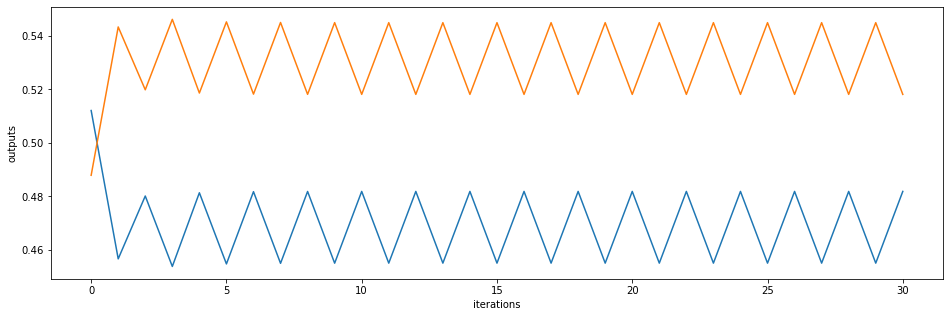

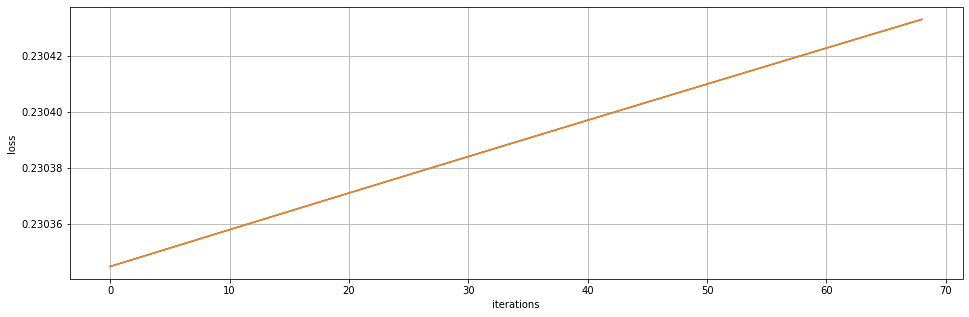

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 81
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41715019]
 [ 0.49625026]]
gradient[[-0.02825125]
 [ 0.05932216]
 [ 0.01192384]
 [-0.01971806]]
gradient[[ 0.49921302]
 [-0.54046026]]
gradient[[ 0.01544319]
 [-0.03215971]
 [-0.00588456]
 [ 0.00991189]]
gradient[[-0.41198775]
 [ 0.49574321]]
gradient[[-0.02996174]
 [ 0.06281844]
 [ 0.01229115]
 [-0.02106638]]
gradient[[ 0.49930628]
 [-0.53794195]]
gradient[[ 0.01446514]
 [-0.03011264]
 [-0.00548722]
 [ 0.00926451]]
gradient[[-0.41369521]
 [ 0.49591483]]
gradient[[-0.02942287]
 [ 0.0616851 ]
 [ 0.01207144]
 [-0.02064982]]
gradient[[ 0.4993363 ]
 [-0.53709723]]
gradient[[ 0.01413817]
 [-0.02943063]
 [-0.00536518]
 [ 0.00904652]]
gradient[[-0.41410

 [ 0.00900225]]
gradient[[-0.41422497]
 [ 0.49596728]]
gradient[[-0.02926215]
 [ 0.06132807]
 [ 0.01199812]
 [-0.02052565]]
gradient[[ 0.49934273]
 [-0.53691394]]
gradient[[ 0.0140707 ]
 [-0.02927955]
 [-0.0053358 ]
 [ 0.00900236]]
gradient[[-0.41422497]
 [ 0.49596728]]
gradient[[-0.02926263]
 [ 0.06132758]
 [ 0.01199763]
 [-0.02052614]]
gradient[[ 0.49934275]
 [-0.53691338]]
gradient[[ 0.01407039]
 [-0.0292792 ]
 [-0.00533581]
 [ 0.00900213]]
gradient[[-0.41422491]
 [ 0.49596728]]
gradient[[-0.02926276]
 [ 0.06132751]
 [ 0.01199753]
 [-0.02052626]]
gradient[[ 0.49934272]
 [-0.53691407]]
gradient[[ 0.01407076]
 [-0.02927964]
 [-0.00533581]
 [ 0.00900241]]
gradient[[-0.41422465]
 [ 0.49596725]]
gradient[[-0.02926311]
 [ 0.06132739]
 [ 0.01199729]
 [-0.0205266 ]]
gradient[[ 0.49934266]
 [-0.53691575]]
gradient[[ 0.01407169]
 [-0.0292807 ]
 [-0.00533578]
 [ 0.00900313]]
gradient[[-0.41422436]
 [ 0.49596722]]
gradient[[-0.02926309]
 [ 0.06132771]
 [ 0.01199743]
 [-0.02052655]]
gradient[[ 0

gradient[[-0.41196636]
 [ 0.49574104]]
gradient[[-0.02998263]
 [ 0.06281798]
 [ 0.01227949]
 [-0.02108588]]
gradient[[ 0.49930455]
 [-0.53799024]]
gradient[[ 0.0144912 ]
 [-0.03014358]
 [-0.00548692]
 [ 0.00928447]]
gradient[[-0.41367383]
 [ 0.4959127 ]]
gradient[[-0.02944345]
 [ 0.06168505]
 [ 0.01206013]
 [-0.02066897]]
gradient[[ 0.49933461]
 [-0.53714535]]
gradient[[ 0.01416396]
 [-0.02946163]
 [-0.00536505]
 [ 0.0090662 ]]
gradient[[-0.41408831]
 [ 0.49595379]]
gradient[[-0.02931254]
 [ 0.06141062]
 [ 0.01200805]
 [-0.02056682]]
gradient[[ 0.49934013]
 [-0.53698822]]
gradient[[ 0.01410326]
 [-0.02933509]
 [-0.00534261]
 [ 0.00902553]]
gradient[[-0.41418145]
 [ 0.49596299]]
gradient[[-0.02928376]
 [ 0.06134863]
 [ 0.01199565]
 [-0.02054436]]
gradient[[ 0.49934139]
 [-0.536952  ]]
gradient[[ 0.0140892 ]
 [-0.02930606]
 [-0.00533753]
 [ 0.00901605]]
gradient[[-0.41420495]
 [ 0.49596531]]
gradient[[-0.02927651]
 [ 0.06133302]
 [ 0.0119925 ]
 [-0.02053868]]
gradient[[ 0.4993417 ]
 [-0.

 [-0.53696215]]
gradient[[ 0.01409649]
 [-0.02931065]
 [-0.00533572]
 [ 0.00902203]]
gradient[[-0.41420329]
 [ 0.49596514]]
gradient[[-0.02928358]
 [ 0.06132749]
 [ 0.0119861 ]
 [-0.02054563]]
gradient[[ 0.49934098]
 [-0.53696383]]
gradient[[ 0.01409741]
 [-0.0293117 ]
 [-0.00533569]
 [ 0.00902274]]
gradient[[-0.41420299]
 [ 0.49596512]]
gradient[[-0.02928356]
 [ 0.06132781]
 [ 0.01198625]
 [-0.02054558]]
gradient[[ 0.49934096]
 [-0.5369645 ]]
gradient[[ 0.01409778]
 [-0.02931213]
 [-0.00533568]
 [ 0.00902302]]
gradient[[-0.41420259]
 [ 0.49596508]]
gradient[[-0.02928417]
 [ 0.06132757]
 [ 0.01198581]
 [-0.02054617]]
gradient[[ 0.49934097]
 [-0.53696407]]
gradient[[ 0.01409752]
 [-0.02931189]
 [-0.00533571]
 [ 0.00902281]]
gradient[[-0.41420244]
 [ 0.49596506]]
gradient[[-0.02928432]
 [ 0.06132757]
 [ 0.01198573]
 [-0.02054631]]
gradient[[ 0.49934095]
 [-0.53696479]]
gradient[[ 0.0140979 ]
 [-0.02931236]
 [-0.00533572]
 [ 0.00902311]]
gradient[[-0.41420216]
 [ 0.49596503]]
gradient[[-0

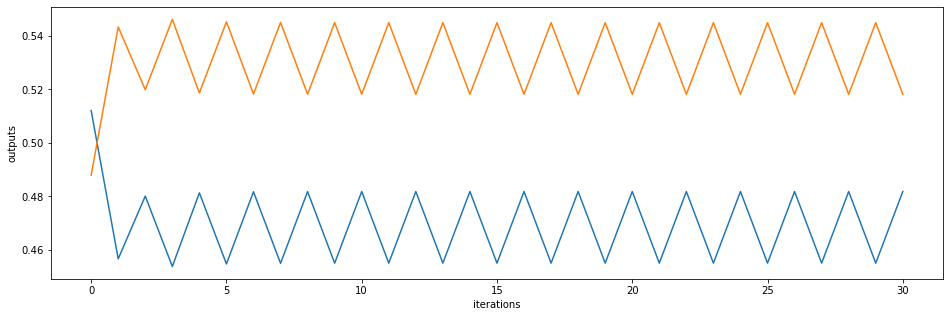

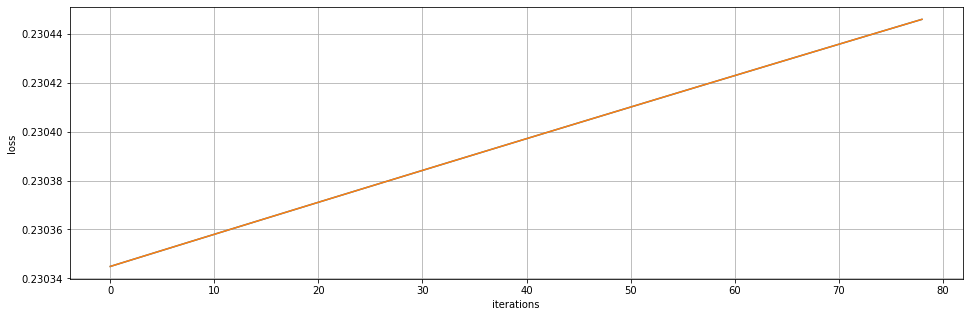

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 91
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41712096]
 [ 0.49624749]]
gradient[[-0.02828259]
 [ 0.05931847]
 [ 0.01190542]
 [-0.01974748]]
gradient[[ 0.49920935]
 [-0.54055624]]
gradient[[ 0.01549587]
 [-0.03222035]
 [-0.0058832 ]
 [ 0.00995258]]
gradient[[-0.41194501]
 [ 0.49573887]]
gradient[[-0.03000349]
 [ 0.06281751]
 [ 0.01226783]
 [-0.02110536]]
gradient[[ 0.49930282]
 [-0.53803844]]
gradient[[ 0.01451722]
 [-0.03017444]
 [-0.0054866 ]
 [ 0.0093044 ]]
gradient[[-0.41365249]
 [ 0.49591058]]
gradient[[-0.02946401]
 [ 0.06168499]
 [ 0.01204882]
 [-0.02068811]]
gradient[[ 0.49933291]
 [-0.53719339]]
gradient[[ 0.01418972]
 [-0.02949255]
 [-0.0053649 ]
 [ 0.00908587]]
gradient[[-0.41406

 [-0.53700995]]
gradient[[ 0.01412199]
 [-0.02934155]
 [-0.00533569]
 [ 0.00904146]]
gradient[[-0.41418227]
 [ 0.49596307]]
gradient[[-0.02930306]
 [ 0.06132826]
 [ 0.01197575]
 [-0.02056369]]
gradient[[ 0.49933936]
 [-0.53701001]]
gradient[[ 0.01412211]
 [-0.02934149]
 [-0.0053356 ]
 [ 0.00904157]]
gradient[[-0.41418227]
 [ 0.49596307]]
gradient[[-0.02930355]
 [ 0.06132776]
 [ 0.01197526]
 [-0.02056418]]
gradient[[ 0.49933938]
 [-0.53700945]]
gradient[[ 0.01412181]
 [-0.02934114]
 [-0.00533561]
 [ 0.00904134]]
gradient[[-0.41418221]
 [ 0.49596306]]
gradient[[-0.02930367]
 [ 0.06132769]
 [ 0.01197517]
 [-0.0205643 ]]
gradient[[ 0.49933936]
 [-0.53701013]]
gradient[[ 0.01412218]
 [-0.02934158]
 [-0.00533561]
 [ 0.00904163]]
gradient[[-0.41418195]
 [ 0.49596304]]
gradient[[-0.02930403]
 [ 0.06132758]
 [ 0.01197492]
 [-0.02056464]]
gradient[[ 0.4993393 ]
 [-0.53701181]]
gradient[[ 0.01412311]
 [-0.02934263]
 [-0.00533558]
 [ 0.00904234]]
gradient[[-0.41418166]
 [ 0.49596301]]
gradient[[-0

gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41710638]
 [ 0.4962461 ]]
gradient[[-0.02829822]
 [ 0.05931663]
 [ 0.01189622]
 [-0.01976215]]
gradient[[ 0.49920752]
 [-0.5406041 ]]
gradient[[ 0.01552216]
 [-0.03225055]
 [-0.0058825 ]
 [ 0.0099729 ]]
gradient[[-0.41192369]
 [ 0.4957367 ]]
gradient[[-0.03002433]
 [ 0.06281703]
 [ 0.01225618]
 [-0.02112482]]
gradient[[ 0.49930108]
 [-0.53808654]]
gradient[[ 0.01454322]
 [-0.03020522]
 [-0.00548626]
 [ 0.00932432]]
gradient[[-0.41363118]
 [ 0.49590846]]
gradient[[-0.02948454]
 [ 0.06168493]
 [ 0.01203753]
 [-0.02070722]]
gradient[[ 0.49933122]
 [-0.53724133]]
gradient[[ 0.01421545]
 [-0.0295234 ]
 [-0.00536474]
 [ 0.00910552]]
gradient[[-0.41404569]
 [ 0.49594957]]
gradient[[-0.02935346]
 [ 0.0614107 ]
 [ 0.01198563]
 [-0.02060488]]
gradient[[ 0.49933676]
 [-0.53708417]]
gradient[[ 0.01415466]
 [-0.02939691]
 [-0.00534237]
 [ 0.00906475]]
gradient[[-0.41413881]
 [ 0.

 [-0.02058268]]
gradient[[ 0.49933768]
 [-0.5370579 ]]
gradient[[ 0.01414778]
 [-0.02937235]
 [-0.00533548]
 [ 0.00906115]]
gradient[[-0.41416096]
 [ 0.49596097]]
gradient[[-0.02932397]
 [ 0.06132784]
 [ 0.01196409]
 [-0.02058317]]
gradient[[ 0.4993377 ]
 [-0.53705735]]
gradient[[ 0.01414747]
 [-0.029372  ]
 [-0.00533549]
 [ 0.00906092]]
gradient[[-0.4141609 ]
 [ 0.49596096]]
gradient[[-0.0293241 ]
 [ 0.06132777]
 [ 0.011964  ]
 [-0.02058329]]
gradient[[ 0.49933768]
 [-0.53705803]]
gradient[[ 0.01414784]
 [-0.02937244]
 [-0.00533548]
 [ 0.0090612 ]]
gradient[[-0.41416065]
 [ 0.49596094]]
gradient[[-0.02932445]
 [ 0.06132765]
 [ 0.01196375]
 [-0.02058363]]
gradient[[ 0.49933762]
 [-0.53705971]]
gradient[[ 0.01414877]
 [-0.02937349]
 [-0.00533545]
 [ 0.00906192]]
gradient[[-0.41416036]
 [ 0.49596091]]
gradient[[-0.02932443]
 [ 0.06132797]
 [ 0.0119639 ]
 [-0.02058358]]
gradient[[ 0.49933759]
 [-0.53706038]]
gradient[[ 0.01414913]
 [-0.02937392]
 [-0.00533545]
 [ 0.00906219]]
gradient[[-0

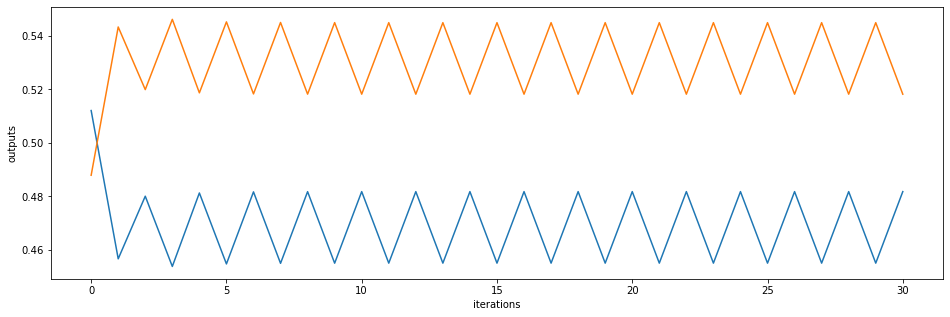

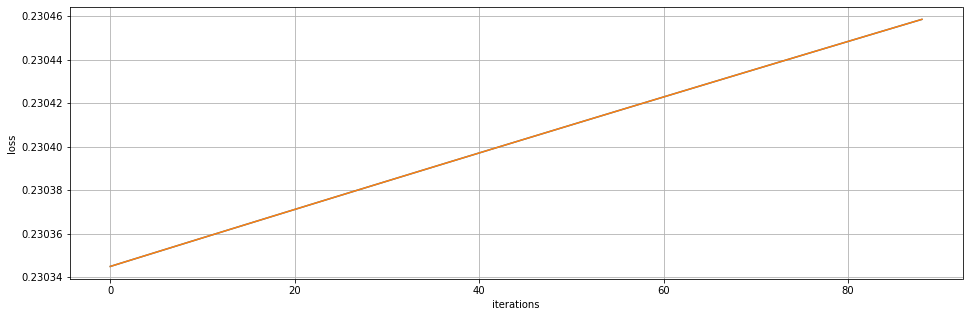

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 101
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41709181]
 [ 0.49624472]]
gradient[[-0.02831384]
 [ 0.05931479]
 [ 0.01188704]
 [-0.01977682]]
gradient[[ 0.49920569]
 [-0.54065186]]
gradient[[ 0.01554842]
 [-0.03228068]
 [-0.00588179]
 [ 0.00999319]]
gradient[[-0.41190239]
 [ 0.49573453]]
gradient[[-0.03004515]
 [ 0.06281655]
 [ 0.01224454]
 [-0.02114426]]
gradient[[ 0.49929935]
 [-0.53813456]]
gradient[[ 0.01456918]
 [-0.03023593]
 [-0.00548591]
 [ 0.00934422]]
gradient[[-0.4136099 ]
 [ 0.49590635]]
gradient[[-0.02950505]
 [ 0.06168485]
 [ 0.01202624]
 [-0.02072632]]
gradient[[ 0.49932953]
 [-0.53728919]]
gradient[[ 0.01424114]
 [-0.02955417]
 [-0.00536455]
 [ 0.00912514]]
gradient[[-0.4140

 [-0.53710571]]
gradient[[ 0.01417341]
 [-0.02940313]
 [-0.00533534]
 [ 0.00908072]]
gradient[[-0.41413969]
 [ 0.49595886]]
gradient[[-0.02934438]
 [ 0.06132791]
 [ 0.01195293]
 [-0.02060214]]
gradient[[ 0.49933602]
 [-0.53710516]]
gradient[[ 0.01417311]
 [-0.02940278]
 [-0.00533535]
 [ 0.00908048]]
gradient[[-0.41413963]
 [ 0.49595886]]
gradient[[-0.0293445 ]
 [ 0.06132784]
 [ 0.01195283]
 [-0.02060226]]
gradient[[ 0.499336  ]
 [-0.53710584]]
gradient[[ 0.01417347]
 [-0.02940322]
 [-0.00533534]
 [ 0.00908077]]
gradient[[-0.41413938]
 [ 0.49595883]]
gradient[[-0.02934485]
 [ 0.06132772]
 [ 0.01195259]
 [-0.0206026 ]]
gradient[[ 0.49933594]
 [-0.53710751]]
gradient[[ 0.0141744 ]
 [-0.02940426]
 [-0.00533531]
 [ 0.00908148]]
gradient[[-0.41413908]
 [ 0.49595881]]
gradient[[-0.02934483]
 [ 0.06132804]
 [ 0.01195273]
 [-0.02060256]]
gradient[[ 0.49933591]
 [-0.53710818]]
gradient[[ 0.01417476]
 [-0.02940469]
 [-0.00533531]
 [ 0.00908175]]
gradient[[-0.41413868]
 [ 0.49595877]]
gradient[[-0

gradient[[-0.41188113]
 [ 0.49573237]]
gradient[[-0.03006594]
 [ 0.06281605]
 [ 0.01223291]
 [-0.02116367]]
gradient[[ 0.49929762]
 [-0.53818248]]
gradient[[ 0.01459512]
 [-0.03026656]
 [-0.00548554]
 [ 0.0093641 ]]
gradient[[-0.41358866]
 [ 0.49590423]]
gradient[[-0.02952555]
 [ 0.06168477]
 [ 0.01201496]
 [-0.02074539]]
gradient[[ 0.49932785]
 [-0.53733696]]
gradient[[ 0.01426681]
 [-0.02958486]
 [-0.00536436]
 [ 0.00914476]]
gradient[[-0.41400319]
 [ 0.49594537]]
gradient[[-0.02939429]
 [ 0.06141074]
 [ 0.01196325]
 [-0.02064286]]
gradient[[ 0.49933339]
 [-0.53717976]]
gradient[[ 0.01420594]
 [-0.02945843]
 [-0.00534206]
 [ 0.00910389]]
gradient[[-0.41409628]
 [ 0.49595458]]
gradient[[-0.02936546]
 [ 0.06134887]
 [ 0.01195093]
 [-0.02062033]]
gradient[[ 0.49933467]
 [-0.53714356]]
gradient[[ 0.01419185]
 [-0.02942945]
 [-0.00533702]
 [ 0.00909437]]
gradient[[-0.41411976]
 [ 0.4959569 ]]
gradient[[-0.02935821]
 [ 0.06133331]
 [ 0.01194781]
 [-0.02061464]]
gradient[[ 0.49933497]
 [-0.

 [ 0.49595674]]
gradient[[-0.02936524]
 [ 0.06132778]
 [ 0.01194143]
 [-0.02062155]]
gradient[[ 0.49933426]
 [-0.53715523]]
gradient[[ 0.0142    ]
 [-0.02943497]
 [-0.00533515]
 [ 0.00910102]]
gradient[[-0.41411784]
 [ 0.49595671]]
gradient[[-0.02936522]
 [ 0.0613281 ]
 [ 0.01194158]
 [-0.02062151]]
gradient[[ 0.49933424]
 [-0.53715589]]
gradient[[ 0.01420036]
 [-0.02943539]
 [-0.00533515]
 [ 0.00910129]]
gradient[[-0.41411744]
 [ 0.49595667]]
gradient[[-0.02936583]
 [ 0.06132787]
 [ 0.01194114]
 [-0.02062209]]
gradient[[ 0.49933425]
 [-0.53715547]]
gradient[[ 0.0142001 ]
 [-0.02943515]
 [-0.00533518]
 [ 0.00910109]]
gradient[[-0.41411729]
 [ 0.49595665]]
gradient[[-0.02936597]
 [ 0.06132786]
 [ 0.01194106]
 [-0.02062223]]
gradient[[ 0.49933423]
 [-0.53715618]]
gradient[[ 0.01420048]
 [-0.02943561]
 [-0.00533518]
 [ 0.00910138]]
gradient[[-0.41411701]
 [ 0.49595662]]
gradient[[-0.02936634]
 [ 0.06132776]
 [ 0.01194082]
 [-0.02062257]]
gradient[[ 0.49933417]
 [-0.53715785]]
gradient[[ 0

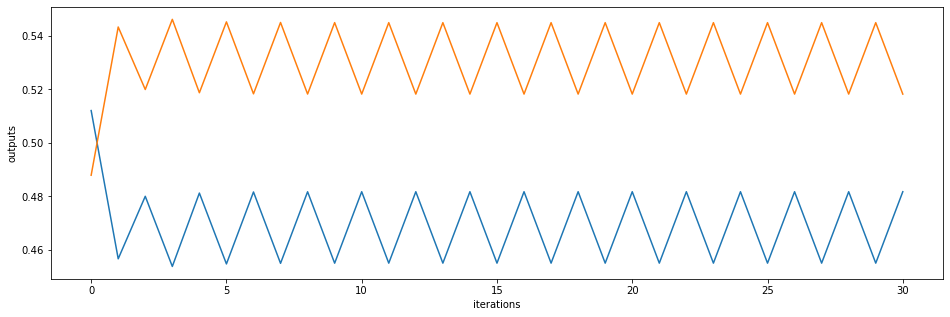

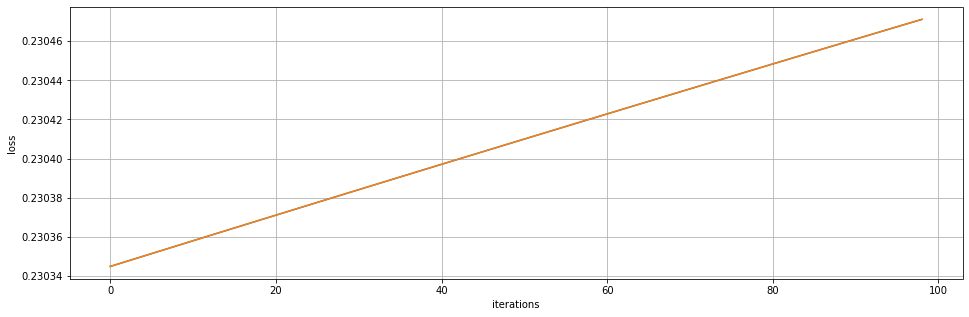

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 111
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41706273]
 [ 0.49624196]]
gradient[[-0.02834502]
 [ 0.05931111]
 [ 0.01186871]
 [-0.01980608]]
gradient[[ 0.49920203]
 [-0.54074712]]
gradient[[ 0.01560085]
 [-0.03234071]
 [-0.00588032]
 [ 0.01003372]]
gradient[[-0.4118599 ]
 [ 0.49573021]]
gradient[[-0.03008672]
 [ 0.06281555]
 [ 0.01222129]
 [-0.02118307]]
gradient[[ 0.49929589]
 [-0.53823032]]
gradient[[ 0.01462102]
 [-0.03029711]
 [-0.00548516]
 [ 0.00938396]]
gradient[[-0.41356744]
 [ 0.49590212]]
gradient[[-0.02954601]
 [ 0.06168467]
 [ 0.01200369]
 [-0.02076444]]
gradient[[ 0.49932616]
 [-0.53738463]]
gradient[[ 0.01429245]
 [-0.02961548]
 [-0.00536414]
 [ 0.00916435]]
gradient[[-0.4139

gradient[[-0.41409717]
 [ 0.49595466]]
gradient[[-0.02938524]
 [ 0.06132795]
 [ 0.01193053]
 [-0.02064015]]
gradient[[ 0.49933264]
 [-0.53720119]]
gradient[[ 0.01422465]
 [-0.02946455]
 [-0.00533502]
 [ 0.00911983]]
gradient[[-0.41409692]
 [ 0.49595464]]
gradient[[-0.0293856 ]
 [ 0.06132784]
 [ 0.01193029]
 [-0.02064048]]
gradient[[ 0.49933258]
 [-0.53720286]]
gradient[[ 0.01422557]
 [-0.02946559]
 [-0.00533498]
 [ 0.00912054]]
gradient[[-0.41409662]
 [ 0.49595461]]
gradient[[-0.02938558]
 [ 0.06132815]
 [ 0.01193043]
 [-0.02064044]]
gradient[[ 0.49933256]
 [-0.53720352]]
gradient[[ 0.01422593]
 [-0.02946602]
 [-0.00533498]
 [ 0.00912082]]
gradient[[-0.41409623]
 [ 0.49595457]]
gradient[[-0.02938619]
 [ 0.06132792]
 [ 0.01193   ]
 [-0.02064102]]
gradient[[ 0.49933257]
 [-0.53720309]]
gradient[[ 0.01422567]
 [-0.02946577]
 [-0.00533501]
 [ 0.00912062]]
gradient[[-0.41409607]
 [ 0.49595456]]
gradient[[-0.02938633]
 [ 0.06132791]
 [ 0.01192992]
 [-0.02064116]]
gradient[[ 0.49933255]
 [-0.

 [-0.53743222]]
gradient[[ 0.01431806]
 [-0.02964603]
 [-0.00536392]
 [ 0.00918392]]
gradient[[-0.41396082]
 [ 0.49594117]]
gradient[[-0.02943504]
 [ 0.06141074]
 [ 0.0119409 ]
 [-0.02068076]]
gradient[[ 0.49933004]
 [-0.537275  ]]
gradient[[ 0.0142571 ]
 [-0.02951964]
 [-0.00534169]
 [ 0.00914296]]
gradient[[-0.41405388]
 [ 0.49595038]]
gradient[[-0.02940618]
 [ 0.06134894]
 [ 0.01192862]
 [-0.0206582 ]]
gradient[[ 0.49933131]
 [-0.5372388 ]]
gradient[[ 0.01424299]
 [-0.02949069]
 [-0.00533666]
 [ 0.00913342]]
gradient[[-0.41407734]
 [ 0.4959527 ]]
gradient[[-0.02939893]
 [ 0.0613334 ]
 [ 0.01192552]
 [-0.02065251]]
gradient[[ 0.49933162]
 [-0.53723022]]
gradient[[ 0.01423977]
 [-0.02948371]
 [-0.00533536]
 [ 0.00913128]]
gradient[[-0.41408323]
 [ 0.49595329]]
gradient[[-0.02939735]
 [ 0.06132926]
 [ 0.01192449]
 [-0.02065132]]
gradient[[ 0.49933164]
 [-0.53722954]]
gradient[[ 0.01423979]
 [-0.02948287]
 [-0.00533499]
 [ 0.00913138]]
gradient[[-0.41408451]
 [ 0.49595341]]
gradient[[-0

 [ 0.00914005]]
gradient[[-0.41407544]
 [ 0.49595252]]
gradient[[-0.02940592]
 [ 0.0613282 ]
 [ 0.01191929]
 [-0.02065935]]
gradient[[ 0.49933088]
 [-0.53725105]]
gradient[[ 0.01425147]
 [-0.02949657]
 [-0.00533479]
 [ 0.00914032]]
gradient[[-0.41407504]
 [ 0.49595248]]
gradient[[-0.02940652]
 [ 0.06132796]
 [ 0.01191886]
 [-0.02065994]]
gradient[[ 0.4993309 ]
 [-0.53725063]]
gradient[[ 0.01425121]
 [-0.02949632]
 [-0.00533482]
 [ 0.00914012]]
gradient[[-0.41407489]
 [ 0.49595246]]
gradient[[-0.02940667]
 [ 0.06132796]
 [ 0.01191878]
 [-0.02066007]]
gradient[[ 0.49933087]
 [-0.53725134]]
gradient[[ 0.01425159]
 [-0.02949679]
 [-0.00533482]
 [ 0.00914041]]
gradient[[-0.41407462]
 [ 0.49595243]]
gradient[[-0.02940703]
 [ 0.06132786]
 [ 0.01191854]
 [-0.02066042]]
gradient[[ 0.49933081]
 [-0.537253  ]]
gradient[[ 0.01425251]
 [-0.02949783]
 [-0.00533479]
 [ 0.00914112]]
---------------
epoch 119
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [

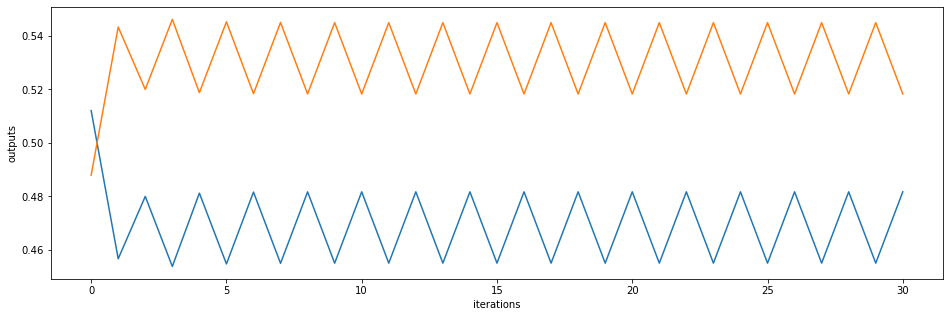

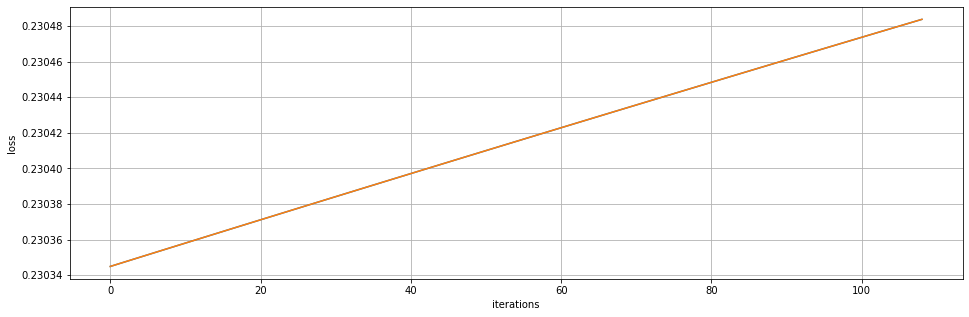

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 121
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41703372]
 [ 0.49623921]]
gradient[[-0.02837612]
 [ 0.05930745]
 [ 0.01185042]
 [-0.01983528]]
gradient[[ 0.49919838]
 [-0.54084202]]
gradient[[ 0.01565314]
 [-0.03240045]
 [-0.0058788 ]
 [ 0.01007416]]
gradient[[-0.41181754]
 [ 0.49572589]]
gradient[[-0.03012819]
 [ 0.06281451]
 [ 0.01219808]
 [-0.02122181]]
gradient[[ 0.49929244]
 [-0.53832571]]
gradient[[ 0.01467273]
 [-0.03035799]
 [-0.00548435]
 [ 0.00942362]]
gradient[[-0.41352509]
 [ 0.4958979 ]]
gradient[[-0.02958689]
 [ 0.06168446]
 [ 0.01198117]
 [-0.0208025 ]]
gradient[[ 0.49932279]
 [-0.53747972]]
gradient[[ 0.01434364]
 [-0.02967649]
 [-0.00536367]
 [ 0.00920347]]
gradient[[-0.4139

 [-0.53729605]]
gradient[[ 0.01427564]
 [-0.0295255 ]
 [-0.00533462]
 [ 0.00915878]]
gradient[[-0.41405489]
 [ 0.49595048]]
gradient[[-0.02942578]
 [ 0.0613281 ]
 [ 0.01190836]
 [-0.02067784]]
gradient[[ 0.49932931]
 [-0.5372955 ]]
gradient[[ 0.01427533]
 [-0.02952515]
 [-0.00533463]
 [ 0.00915855]]
gradient[[-0.41405483]
 [ 0.49595048]]
gradient[[-0.0294259 ]
 [ 0.06132803]
 [ 0.01190826]
 [-0.02067795]]
gradient[[ 0.49932929]
 [-0.53729618]]
gradient[[ 0.0142757 ]
 [-0.02952558]
 [-0.00533462]
 [ 0.00915883]]
gradient[[-0.41405458]
 [ 0.49595045]]
gradient[[-0.02942625]
 [ 0.06132791]
 [ 0.01190802]
 [-0.02067829]]
gradient[[ 0.49932923]
 [-0.53729784]]
gradient[[ 0.01427662]
 [-0.02952662]
 [-0.00533459]
 [ 0.00915954]]
gradient[[-0.41405429]
 [ 0.49595042]]
gradient[[-0.02942623]
 [ 0.06132823]
 [ 0.01190816]
 [-0.02067825]]
gradient[[ 0.49932921]
 [-0.5372985 ]]
gradient[[ 0.01427698]
 [-0.02952704]
 [-0.00533458]
 [ 0.00915981]]
gradient[[-0.41405389]
 [ 0.49595038]]
gradient[[-0

 [-0.53837327]]
gradient[[ 0.01469854]
 [-0.03038831]
 [-0.00548392]
 [ 0.00944342]]
gradient[[-0.41350397]
 [ 0.4958958 ]]
gradient[[-0.02960729]
 [ 0.06168434]
 [ 0.01196992]
 [-0.02082149]]
gradient[[ 0.4993211 ]
 [-0.53752712]]
gradient[[ 0.01436918]
 [-0.02970688]
 [-0.00536341]
 [ 0.00922301]]
gradient[[-0.41391856]
 [ 0.49593699]]
gradient[[-0.02947571]
 [ 0.06141071]
 [ 0.01191858]
 [-0.02071859]]
gradient[[ 0.49932668]
 [-0.53736987]]
gradient[[ 0.01430813]
 [-0.02958055]
 [-0.00534126]
 [ 0.00918196]]
gradient[[-0.4140116]
 [ 0.4959462]]
gradient[[-0.02944682]
 [ 0.06134898]
 [ 0.01190635]
 [-0.020696  ]]
gradient[[ 0.49932796]
 [-0.53733369]]
gradient[[ 0.01429401]
 [-0.02955162]
 [-0.00533625]
 [ 0.0091724 ]]
gradient[[-0.41403504]
 [ 0.49594852]]
gradient[[-0.02943956]
 [ 0.06133346]
 [ 0.01190325]
 [-0.0206903 ]]
gradient[[ 0.49932827]
 [-0.53732511]]
gradient[[ 0.01429079]
 [-0.02954465]
 [-0.00533495]
 [ 0.00917025]]
gradient[[-0.41404093]
 [ 0.4959491 ]]
gradient[[-0.0

 [ 0.49594836]]
gradient[[-0.02944655]
 [ 0.06132794]
 [ 0.0118969 ]
 [-0.02069716]]
gradient[[ 0.49932755]
 [-0.5373452 ]]
gradient[[ 0.0143021 ]
 [-0.02955702]
 [-0.00533437]
 [ 0.009179  ]]
gradient[[-0.41403316]
 [ 0.49594833]]
gradient[[-0.02944653]
 [ 0.06132826]
 [ 0.01189704]
 [-0.02069712]]
gradient[[ 0.49932753]
 [-0.53734586]]
gradient[[ 0.01430246]
 [-0.02955744]
 [-0.00533436]
 [ 0.00917928]]
gradient[[-0.41403277]
 [ 0.4959483 ]]
gradient[[-0.02944714]
 [ 0.06132802]
 [ 0.01189661]
 [-0.0206977 ]]
gradient[[ 0.49932755]
 [-0.53734543]]
gradient[[ 0.0143022 ]
 [-0.0295572 ]
 [-0.00533439]
 [ 0.00917908]]
gradient[[-0.41403261]
 [ 0.49594828]]
gradient[[-0.02944728]
 [ 0.06132802]
 [ 0.01189653]
 [-0.02069784]]
gradient[[ 0.49932752]
 [-0.53734614]]
gradient[[ 0.01430258]
 [-0.02955766]
 [-0.0053344 ]
 [ 0.00917936]]
gradient[[-0.41403234]
 [ 0.49594825]]
gradient[[-0.02944764]
 [ 0.06132792]
 [ 0.01189629]
 [-0.02069818]]
gradient[[ 0.49932746]
 [-0.5373478 ]]
gradient[[ 0

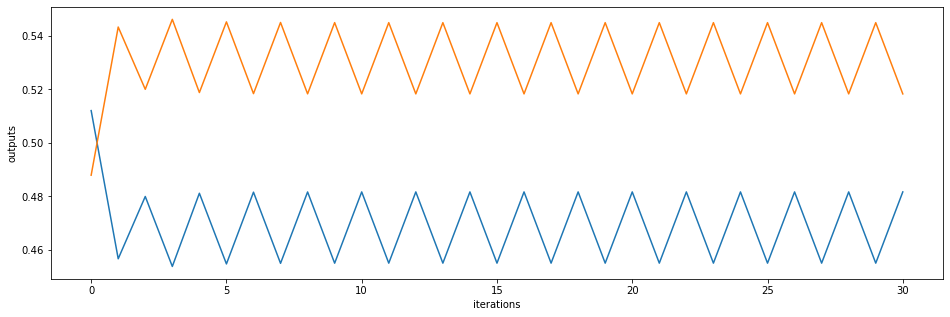

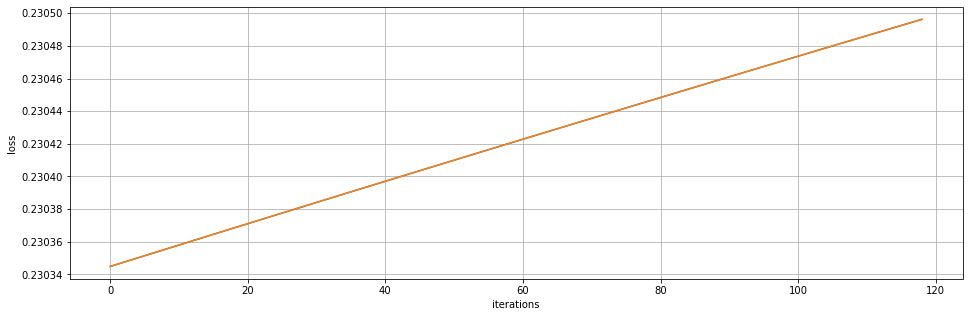

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 131
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41700478]
 [ 0.49623646]]
gradient[[-0.02840714]
 [ 0.05930379]
 [ 0.01183218]
 [-0.0198644 ]]
gradient[[ 0.49919474]
 [-0.54093656]]
gradient[[ 0.0157053 ]
 [-0.03245989]
 [-0.00587722]
 [ 0.01011452]]
gradient[[-0.4117753 ]
 [ 0.49572159]]
gradient[[-0.03016958]
 [ 0.06281345]
 [ 0.01217489]
 [-0.02126046]]
gradient[[ 0.49928899]
 [-0.53842074]]
gradient[[ 0.01472431]
 [-0.03041856]
 [-0.00548347]
 [ 0.00946321]]
gradient[[-0.41348287]
 [ 0.4958937 ]]
gradient[[-0.02962767]
 [ 0.06168421]
 [ 0.01195868]
 [-0.02084047]]
gradient[[ 0.49931942]
 [-0.53757444]]
gradient[[ 0.0143947 ]
 [-0.0297372 ]
 [-0.00536314]
 [ 0.00924253]]
gradient[[-0.4138

gradient[[ 0.49932592]
 [-0.53739132]]
gradient[[ 0.01432643]
 [-0.02958713]
 [-0.00533463]
 [ 0.00919749]]
gradient[[-0.41401139]
 [ 0.49594618]]
gradient[[-0.02946637]
 [ 0.06132935]
 [ 0.01188667]
 [-0.02071551]]
gradient[[ 0.49932595]
 [-0.53739063]]
gradient[[ 0.01432644]
 [-0.02958629]
 [-0.00533426]
 [ 0.00919759]]
gradient[[-0.41401267]
 [ 0.49594631]]
gradient[[-0.02946587]
 [ 0.06132863]
 [ 0.01188661]
 [-0.02071509]]
gradient[[ 0.49932594]
 [-0.53739068]]
gradient[[ 0.01432656]
 [-0.02958623]
 [-0.00533417]
 [ 0.0091977 ]]
gradient[[-0.41401267]
 [ 0.49594631]]
gradient[[-0.02946635]
 [ 0.06132814]
 [ 0.01188612]
 [-0.02071557]]
gradient[[ 0.49932596]
 [-0.53739013]]
gradient[[ 0.01432626]
 [-0.02958588]
 [-0.00533418]
 [ 0.00919747]]
gradient[[-0.41401261]
 [ 0.4959463 ]]
gradient[[-0.02946647]
 [ 0.06132807]
 [ 0.01188603]
 [-0.02071569]]
gradient[[ 0.49932594]
 [-0.53739081]]
gradient[[ 0.01432663]
 [-0.02958631]
 [-0.00533417]
 [ 0.00919775]]
gradient[[-0.41401236]
 [ 0.

 [-0.53743281]]
gradient[[ 0.01434927]
 [-0.02961322]
 [-0.00533393]
 [ 0.00921506]]
---------------
epoch 138
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41698457]
 [ 0.49623454]]
gradient[[-0.02842882]
 [ 0.05930123]
 [ 0.01181944]
 [-0.01988475]]
gradient[[ 0.49919219]
 [-0.54100253]]
gradient[[ 0.01574174]
 [-0.03250132]
 [-0.00587608]
 [ 0.01014272]]
gradient[[-0.41174581]
 [ 0.49571858]]
gradient[[-0.0301985 ]
 [ 0.06281268]
 [ 0.01215869]
 [-0.02128747]]
gradient[[ 0.49928658]
 [-0.53848705]]
gradient[[ 0.01476034]
 [-0.03046078]
 [-0.00548283]
 [ 0.00949087]]
gradient[[-0.41345339]
 [ 0.49589076]]
gradient[[-0.02965616]
 [ 0.06168401]
 [ 0.01194296]
 [-0.020867  ]]
gradient[[ 0.49931707]
 [-0.53764053]]
gradient[[ 0.01443036]
 [-0.02977952]
 [-0.00536273]
 [ 0.00926982]]
gradient[[-0.41386801]
 [ 0.49593198]]
gradient[[-0.02952438]
 [ 0.06141063]
 [ 0.01189183]
 [-0.02076388]]
gradient[[ 0.49932266]
 [

 [-0.53745684]]
gradient[[ 0.0143622 ]
 [-0.02962864]
 [-0.00533382]
 [ 0.00922494]]
gradient[[-0.41398288]
 [ 0.49594336]]
gradient[[-0.02949517]
 [ 0.06132797]
 [ 0.01187024]
 [-0.02074238]]
gradient[[ 0.49932354]
 [-0.53745849]]
gradient[[ 0.01436312]
 [-0.02962967]
 [-0.00533378]
 [ 0.00922565]]
gradient[[-0.41398259]
 [ 0.49594333]]
gradient[[-0.02949515]
 [ 0.06132828]
 [ 0.01187038]
 [-0.02074234]]
gradient[[ 0.49932352]
 [-0.53745915]]
gradient[[ 0.01436348]
 [-0.02963009]
 [-0.00533378]
 [ 0.00922592]]
gradient[[-0.4139822 ]
 [ 0.49594329]]
gradient[[-0.02949575]
 [ 0.06132805]
 [ 0.01186995]
 [-0.02074292]]
gradient[[ 0.49932353]
 [-0.53745872]]
gradient[[ 0.01436322]
 [-0.02962985]
 [-0.00533381]
 [ 0.00922572]]
gradient[[-0.41398204]
 [ 0.49594328]]
gradient[[-0.0294959 ]
 [ 0.06132805]
 [ 0.01186987]
 [-0.02074306]]
gradient[[ 0.49932351]
 [-0.53745943]]
gradient[[ 0.0143636 ]
 [-0.02963031]
 [-0.00533381]
 [ 0.00922601]]
gradient[[-0.41398177]
 [ 0.49594325]]
gradient[[-0

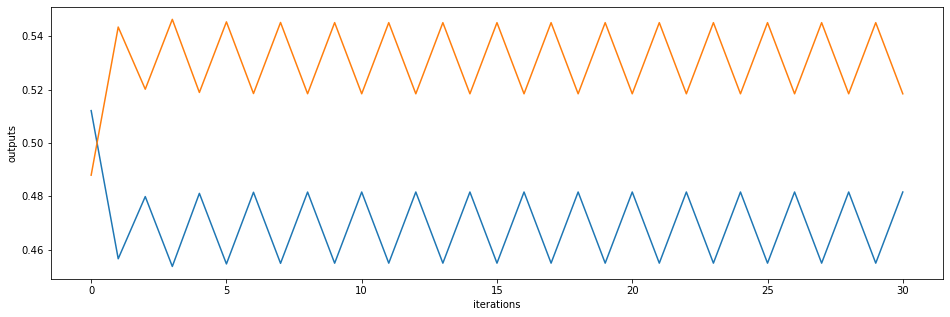

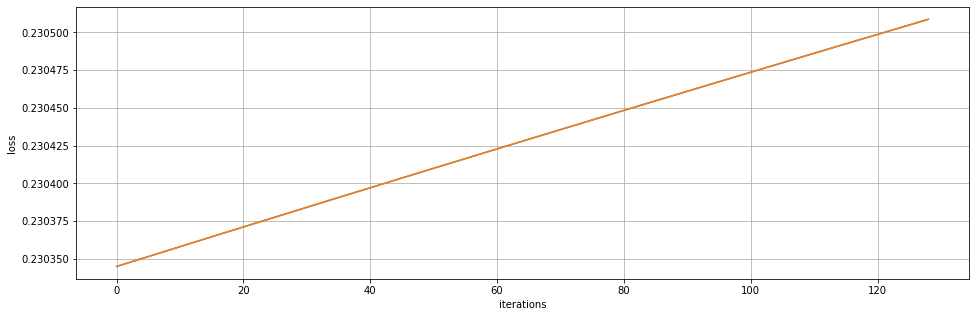

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 141
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41697591]
 [ 0.49623372]]
gradient[[-0.02843809]
 [ 0.05930013]
 [ 0.01181399]
 [-0.01989346]]
gradient[[ 0.4991911 ]
 [-0.54103075]]
gradient[[ 0.01575734]
 [-0.03251903]
 [-0.00587559]
 [ 0.0101548 ]]
gradient[[-0.41173318]
 [ 0.49571729]]
gradient[[-0.03021088]
 [ 0.06281235]
 [ 0.01215175]
 [-0.02129903]]
gradient[[ 0.49928554]
 [-0.53851541]]
gradient[[ 0.01477577]
 [-0.03047883]
 [-0.00548254]
 [ 0.00950271]]
gradient[[-0.41344077]
 [ 0.4958895 ]]
gradient[[-0.02966836]
 [ 0.06168393]
 [ 0.01193623]
 [-0.02087836]]
gradient[[ 0.49931606]
 [-0.5376688 ]]
gradient[[ 0.01444563]
 [-0.02979761]
 [-0.00536254]
 [ 0.0092815 ]]
gradient[[-0.4138

 [-0.53748496]]
gradient[[ 0.01437737]
 [-0.02964666]
 [-0.00533365]
 [ 0.00923654]]
gradient[[-0.41397057]
 [ 0.49594214]]
gradient[[-0.02950683]
 [ 0.06132815]
 [ 0.01186392]
 [-0.02075322]]
gradient[[ 0.49932262]
 [-0.53748441]]
gradient[[ 0.01437707]
 [-0.02964631]
 [-0.00533366]
 [ 0.00923631]]
gradient[[-0.41397051]
 [ 0.49594213]]
gradient[[-0.02950695]
 [ 0.06132808]
 [ 0.01186382]
 [-0.02075334]]
gradient[[ 0.4993226 ]
 [-0.53748508]]
gradient[[ 0.01437743]
 [-0.02964674]
 [-0.00533366]
 [ 0.00923659]]
gradient[[-0.41397026]
 [ 0.49594211]]
gradient[[-0.0295073 ]
 [ 0.06132797]
 [ 0.01186358]
 [-0.02075367]]
gradient[[ 0.49932254]
 [-0.53748673]]
gradient[[ 0.01437835]
 [-0.02964777]
 [-0.00533362]
 [ 0.00923729]]
gradient[[-0.41396997]
 [ 0.49594208]]
gradient[[-0.02950729]
 [ 0.06132828]
 [ 0.01186372]
 [-0.02075363]]
gradient[[ 0.49932252]
 [-0.53748739]]
gradient[[ 0.0143787 ]
 [-0.02964819]
 [-0.00533361]
 [ 0.00923757]]
gradient[[-0.41396958]
 [ 0.49594204]]
gradient[[-0

gradient[[ 0.49928382]
 [-0.53856261]]
gradient[[ 0.01480145]
 [-0.03050885]
 [-0.00548205]
 [ 0.00952244]]
gradient[[-0.41341977]
 [ 0.49588741]]
gradient[[-0.02968868]
 [ 0.06168377]
 [ 0.01192502]
 [-0.02089728]]
gradient[[ 0.49931438]
 [-0.53771585]]
gradient[[ 0.01447105]
 [-0.0298277 ]
 [-0.00536222]
 [ 0.00930096]]
gradient[[-0.41383441]
 [ 0.49592865]]
gradient[[-0.02955677]
 [ 0.06141055]
 [ 0.01187403]
 [-0.02079401]]
gradient[[ 0.49931999]
 [-0.53755854]]
gradient[[ 0.01440983]
 [-0.02970147]
 [-0.00534021]
 [ 0.00925972]]
gradient[[-0.4139274 ]
 [ 0.49593787]]
gradient[[-0.02952783]
 [ 0.06134895]
 [ 0.01186189]
 [-0.02077135]]
gradient[[ 0.49932127]
 [-0.53752238]]
gradient[[ 0.01439568]
 [-0.02967259]
 [-0.00533524]
 [ 0.00925013]]
gradient[[-0.41395081]
 [ 0.49594018]]
gradient[[-0.02952056]
 [ 0.06133347]
 [ 0.01185882]
 [-0.02076564]]
gradient[[ 0.49932158]
 [-0.53751381]]
gradient[[ 0.01439245]
 [-0.02966564]
 [-0.00533395]
 [ 0.00924797]]
gradient[[-0.41395669]
 [ 0.

gradient[[-0.41394926]
 [ 0.49594003]]
gradient[[-0.02952751]
 [ 0.06132796]
 [ 0.01185249]
 [-0.02077247]]
gradient[[ 0.49932087]
 [-0.53753373]]
gradient[[ 0.0144037 ]
 [-0.02967787]
 [-0.00533334]
 [ 0.00925669]]
gradient[[-0.41394897]
 [ 0.49594   ]]
gradient[[-0.02952749]
 [ 0.06132827]
 [ 0.01185264]
 [-0.02077243]]
gradient[[ 0.49932085]
 [-0.53753439]]
gradient[[ 0.01440406]
 [-0.02967829]
 [-0.00533333]
 [ 0.00925696]]
gradient[[-0.41394858]
 [ 0.49593996]]
gradient[[-0.0295281 ]
 [ 0.06132804]
 [ 0.0118522 ]
 [-0.02077301]]
gradient[[ 0.49932086]
 [-0.53753396]]
gradient[[ 0.0144038 ]
 [-0.02967804]
 [-0.00533337]
 [ 0.00925676]]
gradient[[-0.41394842]
 [ 0.49593995]]
gradient[[-0.02952824]
 [ 0.06132804]
 [ 0.01185212]
 [-0.02077314]]
gradient[[ 0.49932084]
 [-0.53753467]]
gradient[[ 0.01440418]
 [-0.0296785 ]
 [-0.00533337]
 [ 0.00925705]]
gradient[[-0.41394815]
 [ 0.49593992]]
gradient[[-0.0295286 ]
 [ 0.06132794]
 [ 0.01185188]
 [-0.02077348]]
gradient[[ 0.49932078]
 [-0.

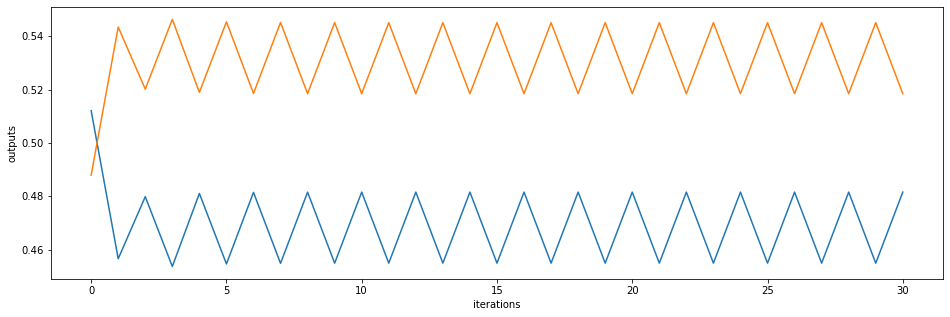

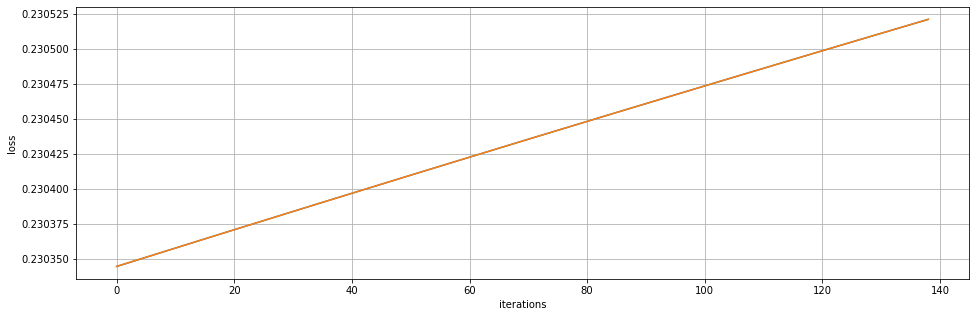

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 151
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41694711]
 [ 0.49623098]]
gradient[[-0.02846896]
 [ 0.05929649]
 [ 0.01179584]
 [-0.01992244]]
gradient[[ 0.49918747]
 [-0.54112457]]
gradient[[ 0.01580923]
 [-0.03257788]
 [-0.0058739 ]
 [ 0.01019499]]
gradient[[-0.41169119]
 [ 0.49571301]]
gradient[[-0.03025209]
 [ 0.06281122]
 [ 0.01212864]
 [-0.02133752]]
gradient[[ 0.4992821 ]
 [-0.53860972]]
gradient[[ 0.01482709]
 [-0.0305388 ]
 [-0.00548155]
 [ 0.00954214]]
gradient[[-0.4133988 ]
 [ 0.49588531]]
gradient[[-0.02970897]
 [ 0.06168361]
 [ 0.01191381]
 [-0.02091618]]
gradient[[ 0.4993127 ]
 [-0.53776281]]
gradient[[ 0.01449644]
 [-0.02985771]
 [-0.00536189]
 [ 0.0093204 ]]
gradient[[-0.4138

 [ 0.00927531]]
gradient[[-0.41392859]
 [ 0.49593798]]
gradient[[-0.02954723]
 [ 0.06132813]
 [ 0.01184175]
 [-0.02079079]]
gradient[[ 0.49931928]
 [-0.53757833]]
gradient[[ 0.01442775]
 [-0.02970644]
 [-0.00533309]
 [ 0.00927508]]
gradient[[-0.41392853]
 [ 0.49593798]]
gradient[[-0.02954735]
 [ 0.06132806]
 [ 0.01184165]
 [-0.02079091]]
gradient[[ 0.49931926]
 [-0.537579  ]]
gradient[[ 0.01442811]
 [-0.02970687]
 [-0.00533309]
 [ 0.00927535]]
gradient[[-0.41392829]
 [ 0.49593795]]
gradient[[-0.0295477 ]
 [ 0.06132794]
 [ 0.01184141]
 [-0.02079125]]
gradient[[ 0.4993192 ]
 [-0.53758064]]
gradient[[ 0.01442902]
 [-0.02970789]
 [-0.00533305]
 [ 0.00927606]]
gradient[[-0.413928  ]
 [ 0.49593792]]
gradient[[-0.02954768]
 [ 0.06132826]
 [ 0.01184156]
 [-0.0207912 ]]
gradient[[ 0.49931918]
 [-0.5375813 ]]
gradient[[ 0.01442938]
 [-0.02970831]
 [-0.00533304]
 [ 0.00927633]]
gradient[[-0.4139276 ]
 [ 0.49593789]]
gradient[[-0.02954828]
 [ 0.06132802]
 [ 0.01184112]
 [-0.02079178]]
gradient[[ 0

gradient[[ 0.49928039]
 [-0.53865674]]
gradient[[ 0.01485271]
 [-0.03056867]
 [-0.00548103]
 [ 0.00956182]]
gradient[[-0.41337785]
 [ 0.49588322]]
gradient[[-0.02972924]
 [ 0.06168344]
 [ 0.01190261]
 [-0.02093505]]
gradient[[ 0.49931103]
 [-0.53780967]]
gradient[[ 0.0145218 ]
 [-0.02988765]
 [-0.00536154]
 [ 0.00933982]]
gradient[[-0.41379252]
 [ 0.49592449]]
gradient[[-0.02959717]
 [ 0.06141042]
 [ 0.01185181]
 [-0.0208316 ]]
gradient[[ 0.49931665]
 [-0.53765234]]
gradient[[ 0.01446049]
 [-0.02976148]
 [-0.00533959]
 [ 0.00929849]]
gradient[[-0.41388549]
 [ 0.49593371]]
gradient[[-0.0295682 ]
 [ 0.06134888]
 [ 0.01183972]
 [-0.02080891]]
gradient[[ 0.49931794]
 [-0.53761619]]
gradient[[ 0.01444633]
 [-0.02973263]
 [-0.00533464]
 [ 0.00928888]]
gradient[[-0.41390888]
 [ 0.49593603]]
gradient[[-0.02956094]
 [ 0.06133343]
 [ 0.01183666]
 [-0.02080319]]
gradient[[ 0.49931824]
 [-0.53760763]]
gradient[[ 0.0144431 ]
 [-0.02972568]
 [-0.00533335]
 [ 0.00928672]]
gradient[[-0.41391475]
 [ 0.

 [ 0.00929541]]
gradient[[-0.41390706]
 [ 0.49593585]]
gradient[[-0.02956785]
 [ 0.06132823]
 [ 0.01183048]
 [-0.02080996]]
gradient[[ 0.49931751]
 [-0.53762812]]
gradient[[ 0.01445467]
 [-0.02973826]
 [-0.00533273]
 [ 0.00929569]]
gradient[[-0.41390666]
 [ 0.49593581]]
gradient[[-0.02956845]
 [ 0.061328  ]
 [ 0.01183005]
 [-0.02081054]]
gradient[[ 0.49931753]
 [-0.53762769]]
gradient[[ 0.01445441]
 [-0.02973802]
 [-0.00533276]
 [ 0.00929548]]
gradient[[-0.41390651]
 [ 0.4959358 ]]
gradient[[-0.02956859]
 [ 0.061328  ]
 [ 0.01182997]
 [-0.02081068]]
gradient[[ 0.4993175]
 [-0.5376284]]
gradient[[ 0.01445479]
 [-0.02973847]
 [-0.00533276]
 [ 0.00929577]]
gradient[[-0.41390624]
 [ 0.49593577]]
gradient[[-0.02956895]
 [ 0.0613279 ]
 [ 0.01182973]
 [-0.02081101]]
gradient[[ 0.49931744]
 [-0.53763004]]
gradient[[ 0.0144557 ]
 [-0.02973949]
 [-0.00533273]
 [ 0.00929647]]
---------------
epoch 159
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0

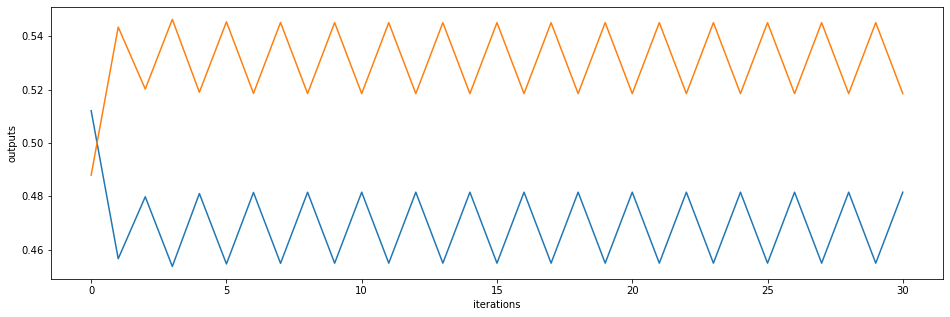

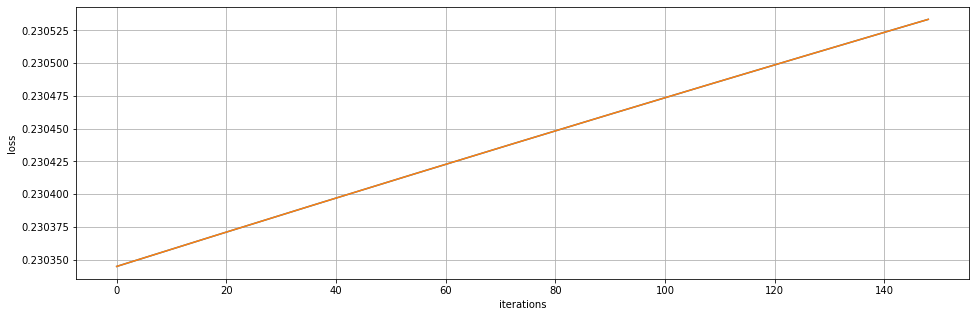

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 161
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41691839]
 [ 0.49622825]]
gradient[[-0.02849975]
 [ 0.05929286]
 [ 0.01177773]
 [-0.01995134]]
gradient[[ 0.49918384]
 [-0.54121803]]
gradient[[ 0.015861  ]
 [-0.03263644]
 [-0.00587216]
 [ 0.01023509]]
gradient[[-0.41164933]
 [ 0.49570874]]
gradient[[-0.0302932 ]
 [ 0.06281005]
 [ 0.01210556]
 [-0.02137593]]
gradient[[ 0.49927867]
 [-0.53870367]]
gradient[[ 0.01487829]
 [-0.03059847]
 [-0.0054805 ]
 [ 0.00958149]]
gradient[[-0.41335694]
 [ 0.49588114]]
gradient[[-0.02974949]
 [ 0.06168326]
 [ 0.01189143]
 [-0.02095391]]
gradient[[ 0.49930935]
 [-0.53785645]]
gradient[[ 0.01454712]
 [-0.02991752]
 [-0.00536117]
 [ 0.00935922]]
gradient[[-0.4137

gradient[[ 0.49931593]
 [-0.53767244]]
gradient[[ 0.0144786 ]
 [-0.02976662]
 [-0.00533245]
 [ 0.009314  ]]
gradient[[-0.41388674]
 [ 0.49593384]]
gradient[[-0.02958754]
 [ 0.06132807]
 [ 0.01181961]
 [-0.02082829]]
gradient[[ 0.49931595]
 [-0.53767189]]
gradient[[ 0.0144783 ]
 [-0.02976628]
 [-0.00533246]
 [ 0.00931377]]
gradient[[-0.41388668]
 [ 0.49593383]]
gradient[[-0.02958766]
 [ 0.061328  ]
 [ 0.01181952]
 [-0.02082841]]
gradient[[ 0.49931593]
 [-0.53767256]]
gradient[[ 0.01447866]
 [-0.0297667 ]
 [-0.00533245]
 [ 0.00931404]]
gradient[[-0.41388643]
 [ 0.49593381]]
gradient[[-0.02958801]
 [ 0.06132789]
 [ 0.01181927]
 [-0.02082874]]
gradient[[ 0.49931587]
 [-0.53767419]]
gradient[[ 0.01447958]
 [-0.02976772]
 [-0.00533241]
 [ 0.00931475]]
gradient[[-0.41388614]
 [ 0.49593378]]
gradient[[-0.02958799]
 [ 0.0613282 ]
 [ 0.01181942]
 [-0.0208287 ]]
gradient[[ 0.49931584]
 [-0.53767485]]
gradient[[ 0.01447993]
 [-0.02976814]
 [-0.00533241]
 [ 0.00931502]]
gradient[[-0.41388575]
 [ 0.

 [ 0.4957066 ]]
gradient[[-0.03031372]
 [ 0.06280946]
 [ 0.01209404]
 [-0.0213951 ]]
gradient[[ 0.49927696]
 [-0.53875051]]
gradient[[ 0.01490384]
 [-0.03062819]
 [-0.00547995]
 [ 0.00960113]]
gradient[[-0.41333606]
 [ 0.49587905]]
gradient[[-0.02976971]
 [ 0.06168307]
 [ 0.01188025]
 [-0.02097275]]
gradient[[ 0.49930768]
 [-0.53790314]]
gradient[[ 0.01457242]
 [-0.02994731]
 [-0.00536079]
 [ 0.0093786 ]]
gradient[[-0.41375075]
 [ 0.49592034]]
gradient[[-0.02963748]
 [ 0.06141026]
 [ 0.01182963]
 [-0.02086911]]
gradient[[ 0.49931331]
 [-0.53774578]]
gradient[[ 0.01451102]
 [-0.02982119]
 [-0.00533892]
 [ 0.00933718]]
gradient[[-0.41384369]
 [ 0.49592957]]
gradient[[-0.02960849]
 [ 0.06134878]
 [ 0.01181757]
 [-0.02084639]]
gradient[[ 0.4993146 ]
 [-0.53770964]]
gradient[[ 0.01449685]
 [-0.02979237]
 [-0.00533398]
 [ 0.00932755]]
gradient[[-0.41386706]
 [ 0.49593189]]
gradient[[-0.02960122]
 [ 0.06133335]
 [ 0.01181452]
 [-0.02084067]]
gradient[[ 0.49931491]
 [-0.53770108]]
gradient[[ 0

 [ 0.49593176]]
gradient[[-0.02960778]
 [ 0.06132796]
 [ 0.01180846]
 [-0.02084713]]
gradient[[ 0.49931426]
 [-0.5377192 ]]
gradient[[ 0.01450389]
 [-0.02979651]
 [-0.00533212]
 [ 0.00933336]]
gradient[[-0.41386555]
 [ 0.49593174]]
gradient[[-0.02960813]
 [ 0.06132785]
 [ 0.01180822]
 [-0.02084746]]
gradient[[ 0.4993142 ]
 [-0.53772084]]
gradient[[ 0.0145048 ]
 [-0.02979752]
 [-0.00533208]
 [ 0.00933406]]
gradient[[-0.41386526]
 [ 0.49593171]]
gradient[[-0.02960811]
 [ 0.06132816]
 [ 0.01180836]
 [-0.02084742]]
gradient[[ 0.49931418]
 [-0.53772149]]
gradient[[ 0.01450516]
 [-0.02979794]
 [-0.00533207]
 [ 0.00933433]]
gradient[[-0.41386487]
 [ 0.49593167]]
gradient[[-0.02960871]
 [ 0.06132793]
 [ 0.01180793]
 [-0.02084799]]
gradient[[ 0.49931419]
 [-0.53772107]]
gradient[[ 0.0145049 ]
 [-0.0297977 ]
 [-0.0053321 ]
 [ 0.00933413]]
gradient[[-0.41386472]
 [ 0.49593165]]
gradient[[-0.02960885]
 [ 0.06132792]
 [ 0.01180785]
 [-0.02084813]]
gradient[[ 0.49931417]
 [-0.53772177]]
gradient[[ 0

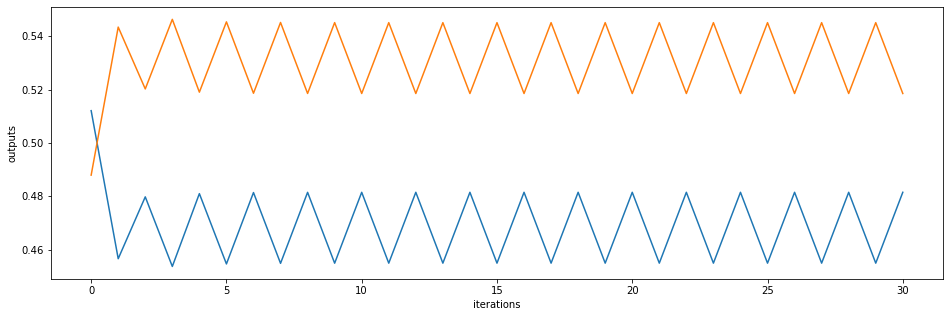

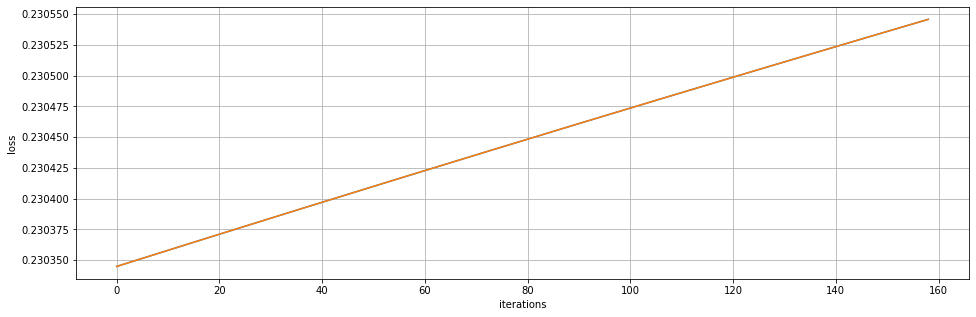

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 171
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41688973]
 [ 0.49622552]]
gradient[[-0.02853047]
 [ 0.05928923]
 [ 0.01175968]
 [-0.01998018]]
gradient[[ 0.49918022]
 [-0.54131114]]
gradient[[ 0.01591263]
 [-0.0326947 ]
 [-0.00587037]
 [ 0.01027511]]
gradient[[-0.41160758]
 [ 0.49570447]]
gradient[[-0.03033422]
 [ 0.06280885]
 [ 0.01208252]
 [-0.02141426]]
gradient[[ 0.49927524]
 [-0.53879725]]
gradient[[ 0.01492936]
 [-0.03065784]
 [-0.00547939]
 [ 0.00962075]]
gradient[[-0.41331521]
 [ 0.49587697]]
gradient[[-0.02978992]
 [ 0.06168287]
 [ 0.01186908]
 [-0.02099157]]
gradient[[ 0.499306  ]
 [-0.53794974]]
gradient[[ 0.01459768]
 [-0.02997703]
 [-0.0053604 ]
 [ 0.00939796]]
gradient[[-0.4137

 [-0.02086685]]
gradient[[ 0.49931258]
 [-0.53776629]]
gradient[[ 0.0145289 ]
 [-0.02982708]
 [-0.00533222]
 [ 0.00935241]]
gradient[[-0.41384373]
 [ 0.49592957]]
gradient[[-0.02962778]
 [ 0.06132918]
 [ 0.01179805]
 [-0.02086565]]
gradient[[ 0.4993126 ]
 [-0.53776559]]
gradient[[ 0.01452891]
 [-0.02982623]
 [-0.00533185]
 [ 0.0093525 ]]
gradient[[-0.413845 ]
 [ 0.4959297]]
gradient[[-0.02962728]
 [ 0.06132847]
 [ 0.01179799]
 [-0.02086523]]
gradient[[ 0.4993126 ]
 [-0.53776564]]
gradient[[ 0.01452903]
 [-0.02982616]
 [-0.00533176]
 [ 0.00935261]]
gradient[[-0.413845 ]
 [ 0.4959297]]
gradient[[-0.02962776]
 [ 0.06132798]
 [ 0.01179751]
 [-0.02086571]]
gradient[[ 0.49931262]
 [-0.53776509]]
gradient[[ 0.01452873]
 [-0.02982582]
 [-0.00533177]
 [ 0.00935238]]
gradient[[-0.41384494]
 [ 0.49592969]]
gradient[[-0.02962788]
 [ 0.06132791]
 [ 0.01179742]
 [-0.02086583]]
gradient[[ 0.4993126 ]
 [-0.53776576]]
gradient[[ 0.01452909]
 [-0.02982624]
 [-0.00533176]
 [ 0.00935265]]
gradient[[-0.413

 [ 0.49592877]]
gradient[[-0.02963684]
 [ 0.06132785]
 [ 0.01179247]
 [-0.02087417]]
gradient[[ 0.49931187]
 [-0.53778622]]
gradient[[ 0.01454017]
 [-0.0298393 ]
 [-0.0053316 ]
 [ 0.00936114]]
gradient[[-0.41383553]
 [ 0.49592876]]
gradient[[-0.02963699]
 [ 0.06132785]
 [ 0.01179239]
 [-0.0208743 ]]
gradient[[ 0.49931184]
 [-0.53778691]]
gradient[[ 0.01454054]
 [-0.02983975]
 [-0.0053316 ]
 [ 0.00936143]]
gradient[[-0.41383526]
 [ 0.49592873]]
gradient[[-0.02963734]
 [ 0.06132775]
 [ 0.01179215]
 [-0.02087464]]
gradient[[ 0.49931178]
 [-0.53778854]]
gradient[[ 0.01454145]
 [-0.02984076]
 [-0.00533156]
 [ 0.00936213]]
---------------
epoch 176
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41687543]
 [ 0.49622416]]
gradient[[-0.0285458 ]
 [ 0.05928742]
 [ 0.01175066]
 [-0.01999457]]
gradient[[ 0.49917842]
 [-0.54135755]]
gradient[[ 0.01593839]
 [-0.03272373]
 [-0.00586946]
 [ 0.01029509]]
gradient[[-0.41158676]
 [

 [ 0.49592692]]
gradient[[-0.02964944]
 [ 0.06133322]
 [ 0.01178801]
 [-0.02088553]]
gradient[[ 0.49931092]
 [-0.53781276]]
gradient[[ 0.01455407]
 [-0.02985674]
 [-0.00533185]
 [ 0.00937169]]
gradient[[-0.41382291]
 [ 0.49592751]]
gradient[[-0.02964786]
 [ 0.06132912]
 [ 0.01178701]
 [-0.02088433]]
gradient[[ 0.49931094]
 [-0.53781206]]
gradient[[ 0.01455408]
 [-0.02985588]
 [-0.00533148]
 [ 0.00937178]]
gradient[[-0.41382417]
 [ 0.49592763]]
gradient[[-0.02964736]
 [ 0.06132841]
 [ 0.01178695]
 [-0.02088391]]
gradient[[ 0.49931094]
 [-0.53781211]]
gradient[[ 0.0145542 ]
 [-0.02985582]
 [-0.00533139]
 [ 0.00937188]]
gradient[[-0.41382418]
 [ 0.49592763]]
gradient[[-0.02964784]
 [ 0.06132792]
 [ 0.01178647]
 [-0.02088439]]
gradient[[ 0.49931096]
 [-0.53781156]]
gradient[[ 0.0145539 ]
 [-0.02985547]
 [-0.0053314 ]
 [ 0.00937165]]
gradient[[-0.41382412]
 [ 0.49592763]]
gradient[[-0.02964796]
 [ 0.06132785]
 [ 0.01178638]
 [-0.0208845 ]]
gradient[[ 0.49931094]
 [-0.53781223]]
gradient[[ 0

 [ 0.00938061]]
gradient[[-0.41381487]
 [ 0.49592671]]
gradient[[-0.02965691]
 [ 0.06132779]
 [ 0.01178143]
 [-0.02089284]]
gradient[[ 0.4993102 ]
 [-0.53783264]]
gradient[[ 0.01456532]
 [-0.02986892]
 [-0.00533123]
 [ 0.00938041]]
gradient[[-0.41381472]
 [ 0.49592669]]
gradient[[-0.02965705]
 [ 0.06132779]
 [ 0.01178136]
 [-0.02089297]]
gradient[[ 0.49931018]
 [-0.53783334]]
gradient[[ 0.01456569]
 [-0.02986937]
 [-0.00533123]
 [ 0.00938069]]
gradient[[-0.41381445]
 [ 0.49592667]]
gradient[[-0.02965741]
 [ 0.06132769]
 [ 0.01178112]
 [-0.02089331]]
gradient[[ 0.49931012]
 [-0.53783497]]
gradient[[ 0.0145666 ]
 [-0.02987038]
 [-0.00533119]
 [ 0.00938139]]
-----------------
average loss: 
[[0.2305592]
 [0.2305592]]


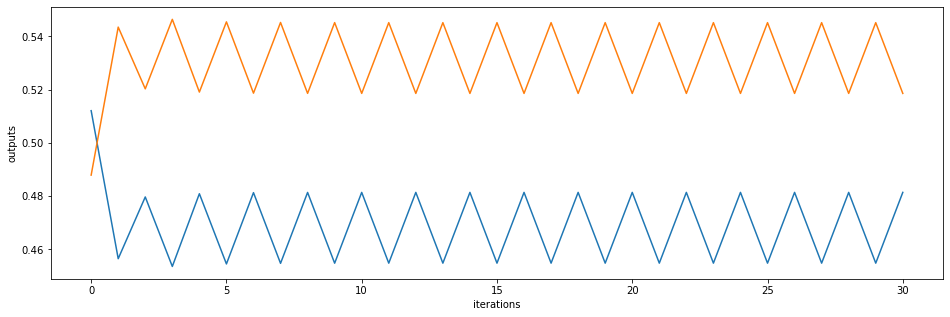

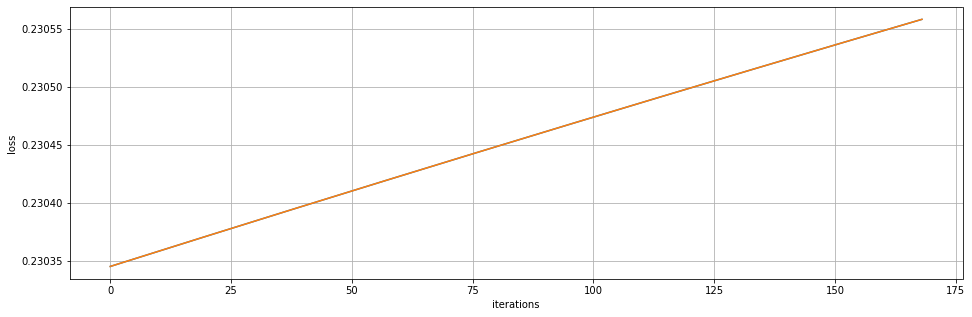

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 181
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41686114]
 [ 0.4962228 ]]
gradient[[-0.02856111]
 [ 0.05928561]
 [ 0.01174166]
 [-0.02000894]]
gradient[[ 0.49917661]
 [-0.54140388]]
gradient[[ 0.01596412]
 [-0.03275268]
 [-0.00586853]
 [ 0.01031504]]
gradient[[-0.41156596]
 [ 0.49570022]]
gradient[[-0.03037516]
 [ 0.06280762]
 [ 0.01205952]
 [-0.0214525 ]]
gradient[[ 0.49927182]
 [-0.53889048]]
gradient[[ 0.0149803 ]
 [-0.03071691]
 [-0.00547823]
 [ 0.00965994]]
gradient[[-0.4132736 ]
 [ 0.49587281]]
gradient[[-0.02983026]
 [ 0.06168245]
 [ 0.01184676]
 [-0.02102914]]
gradient[[ 0.49930266]
 [-0.53804267]]
gradient[[ 0.01464811]
 [-0.03003624]
 [-0.00535957]
 [ 0.00943663]]
gradient[[-0.4136

 [-0.53787713]]
gradient[[ 0.01458944]
 [-0.02989729]
 [-0.00533086]
 [ 0.00939888]]
gradient[[-0.41379477]
 [ 0.49592471]]
gradient[[-0.02967637]
 [ 0.06132765]
 [ 0.0117707 ]
 [-0.02091095]]
gradient[[ 0.49930855]
 [-0.53787876]]
gradient[[ 0.01459034]
 [-0.0298983 ]
 [-0.00533082]
 [ 0.00939958]]
gradient[[-0.41379448]
 [ 0.49592469]]
gradient[[-0.02967636]
 [ 0.06132795]
 [ 0.01177084]
 [-0.02091091]]
gradient[[ 0.49930853]
 [-0.5378794 ]]
gradient[[ 0.0145907 ]
 [-0.02989871]
 [-0.00533081]
 [ 0.00939985]]
gradient[[-0.41379409]
 [ 0.49592465]]
gradient[[-0.02967695]
 [ 0.06132772]
 [ 0.01177041]
 [-0.02091149]]
gradient[[ 0.49930854]
 [-0.53787898]]
gradient[[ 0.01459044]
 [-0.02989847]
 [-0.00533084]
 [ 0.00939965]]
gradient[[-0.41379394]
 [ 0.49592463]]
gradient[[-0.0296771 ]
 [ 0.06132772]
 [ 0.01177033]
 [-0.02091162]]
gradient[[ 0.49930852]
 [-0.53787968]]
gradient[[ 0.01459081]
 [-0.02989892]
 [-0.00533084]
 [ 0.00939994]]
gradient[[-0.41379368]
 [ 0.49592461]]
gradient[[-0

 [-0.53895552]]
gradient[[ 0.01501588]
 [-0.03075808]
 [-0.00547738]
 [ 0.00968732]]
gradient[[-0.41324454]
 [ 0.49586991]]
gradient[[-0.02985844]
 [ 0.06168214]
 [ 0.01183116]
 [-0.0210554 ]]
gradient[[ 0.49930033]
 [-0.53810751]]
gradient[[ 0.01468333]
 [-0.03007752]
 [-0.00535896]
 [ 0.00946364]]
gradient[[-0.41365927]
 [ 0.49591126]]
gradient[[-0.02972585]
 [ 0.06140978]
 [ 0.01178094]
 [-0.02095136]]
gradient[[ 0.49930599]
 [-0.5379501 ]]
gradient[[ 0.01462175]
 [-0.02995152]
 [-0.00533724]
 [ 0.00942201]]
gradient[[-0.41375216]
 [ 0.49592048]]
gradient[[-0.02969681]
 [ 0.06134845]
 [ 0.01176898]
 [-0.02092857]]
gradient[[ 0.49930729]
 [-0.53791399]]
gradient[[ 0.01460756]
 [-0.02992276]
 [-0.00533234]
 [ 0.00941236]]
gradient[[-0.4137755]
 [ 0.4959228]]
gradient[[-0.02968953]
 [ 0.06133307]
 [ 0.01176596]
 [-0.02092284]]
gradient[[ 0.4993076 ]
 [-0.53790544]]
gradient[[ 0.01460431]
 [-0.02991584]
 [-0.00533107]
 [ 0.00941018]]
gradient[[-0.41378135]
 [ 0.49592338]]
gradient[[-0.0

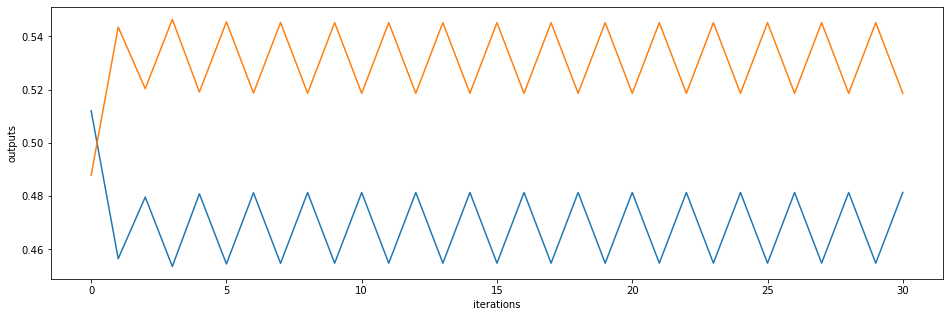

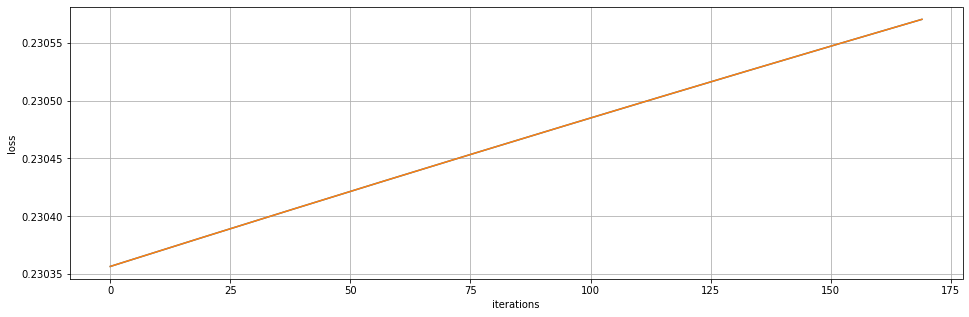

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 191
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41683263]
 [ 0.49622008]]
gradient[[-0.02859167]
 [ 0.059282  ]
 [ 0.01172369]
 [-0.02003763]]
gradient[[ 0.499173  ]
 [-0.54149627]]
gradient[[ 0.01601548]
 [-0.03281036]
 [-0.00586664]
 [ 0.01035488]]
gradient[[-0.41152447]
 [ 0.49569598]]
gradient[[-0.030416  ]
 [ 0.06280636]
 [ 0.01203656]
 [-0.02149066]]
gradient[[ 0.4992684 ]
 [-0.53898334]]
gradient[[ 0.01503111]
 [-0.03077568]
 [-0.00547701]
 [ 0.00969904]]
gradient[[-0.41323211]
 [ 0.49586867]]
gradient[[-0.02987051]
 [ 0.061682  ]
 [ 0.01182448]
 [-0.02106664]]
gradient[[ 0.49929933]
 [-0.53813524]]
gradient[[ 0.01469841]
 [-0.03009516]
 [-0.00535869]
 [ 0.00947521]]
gradient[[-0.4136

 [ 0.00942948]]
gradient[[-0.41376188]
 [ 0.49592145]]
gradient[[-0.02970746]
 [ 0.06132819]
 [ 0.01175388]
 [-0.02093983]]
gradient[[ 0.49930596]
 [-0.53795098]]
gradient[[ 0.01462951]
 [-0.02994435]
 [-0.00533021]
 [ 0.00942959]]
gradient[[-0.41376189]
 [ 0.49592145]]
gradient[[-0.02970793]
 [ 0.0613277 ]
 [ 0.01175341]
 [-0.02094031]]
gradient[[ 0.49930598]
 [-0.53795043]]
gradient[[ 0.0146292 ]
 [-0.02994401]
 [-0.00533022]
 [ 0.00942936]]
gradient[[-0.41376183]
 [ 0.49592144]]
gradient[[-0.02970805]
 [ 0.06132763]
 [ 0.01175331]
 [-0.02094042]]
gradient[[ 0.49930596]
 [-0.53795109]]
gradient[[ 0.01462956]
 [-0.02994443]
 [-0.00533021]
 [ 0.00942964]]
gradient[[-0.41376158]
 [ 0.49592142]]
gradient[[-0.0297084 ]
 [ 0.06132752]
 [ 0.01175307]
 [-0.02094075]]
gradient[[ 0.4993059 ]
 [-0.53795271]]
gradient[[ 0.01463047]
 [-0.02994543]
 [-0.00533017]
 [ 0.00943034]]
gradient[[-0.4137613 ]
 [ 0.49592139]]
gradient[[-0.02970838]
 [ 0.06132783]
 [ 0.01175321]
 [-0.02094071]]
gradient[[ 0

gradient[[ 0.49930428]
 [-0.53799775]]
gradient[[ 0.01465442]
 [-0.02997464]
 [-0.00533024]
 [ 0.00944859]]
gradient[[-0.41373992]
 [ 0.49591927]]
gradient[[-0.02972795]
 [ 0.06132881]
 [ 0.01174294]
 [-0.02095886]]
gradient[[ 0.4993043 ]
 [-0.53799705]]
gradient[[ 0.01465443]
 [-0.02997378]
 [-0.00532987]
 [ 0.00944868]]
gradient[[-0.41374118]
 [ 0.49591939]]
gradient[[-0.02972745]
 [ 0.0613281 ]
 [ 0.01174288]
 [-0.02095843]]
gradient[[ 0.4993043 ]
 [-0.53799709]]
gradient[[ 0.01465455]
 [-0.02997371]
 [-0.00532978]
 [ 0.00944879]]
gradient[[-0.41374118]
 [ 0.49591939]]
gradient[[-0.02972792]
 [ 0.06132761]
 [ 0.0117424 ]
 [-0.02095891]]
gradient[[ 0.49930432]
 [-0.53799654]]
gradient[[ 0.01465424]
 [-0.02997337]
 [-0.0053298 ]
 [ 0.00944856]]
gradient[[-0.41374112]
 [ 0.49591939]]
gradient[[-0.02972804]
 [ 0.06132754]
 [ 0.01174231]
 [-0.02095902]]
gradient[[ 0.4993043]
 [-0.5379972]]
gradient[[ 0.0146546 ]
 [-0.02997379]
 [-0.00532979]
 [ 0.00944883]]
gradient[[-0.41374088]
 [ 0.49

 [ 0.49591843]]
gradient[[-0.02973745]
 [ 0.06132736]
 [ 0.01173707]
 [-0.02096779]]
gradient[[ 0.49930349]
 [-0.53801977]]
gradient[[ 0.01466688]
 [-0.02998813]
 [-0.00532956]
 [ 0.00945826]]
-----------------
average loss: 
[[0.23058349]
 [0.23058349]]


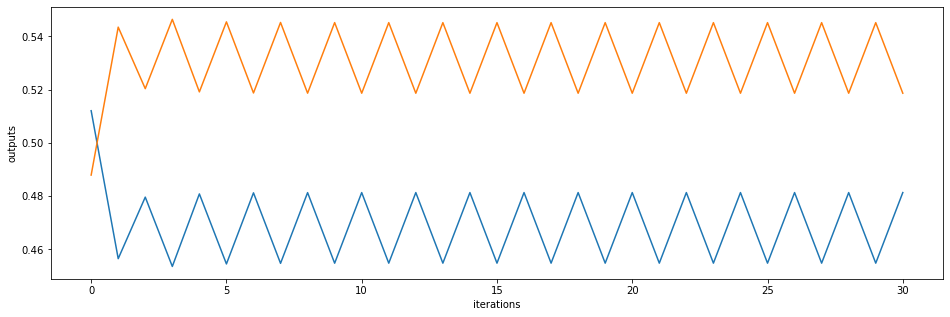

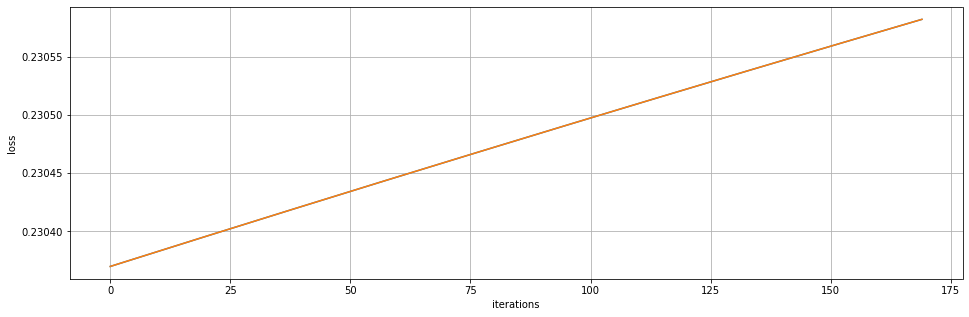

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 201
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41680418]
 [ 0.49621738]]
gradient[[-0.02862215]
 [ 0.0592784 ]
 [ 0.01170577]
 [-0.02006624]]
gradient[[ 0.4991694 ]
 [-0.54158831]]
gradient[[ 0.0160667 ]
 [-0.03286776]
 [-0.0058647 ]
 [ 0.01039463]]
gradient[[-0.4114831 ]
 [ 0.49569175]]
gradient[[-0.03045674]
 [ 0.06280507]
 [ 0.01201363]
 [-0.02152874]]
gradient[[ 0.49926499]
 [-0.53907584]]
gradient[[ 0.01508179]
 [-0.03083416]
 [-0.00547573]
 [ 0.00973806]]
gradient[[-0.41319074]
 [ 0.49586453]]
gradient[[-0.02991067]
 [ 0.06168152]
 [ 0.01180223]
 [-0.02110405]]
gradient[[ 0.499296  ]
 [-0.53822746]]
gradient[[ 0.01474858]
 [-0.03015379]
 [-0.00535775]
 [ 0.00951371]]
gradient[[-0.4136

 [ 0.00946777]]
gradient[[-0.41371924]
 [ 0.49591722]]
gradient[[-0.02974792]
 [ 0.06132871]
 [ 0.01173194]
 [-0.02097744]]
gradient[[ 0.49930265]
 [-0.53804307]]
gradient[[ 0.01467944]
 [-0.03000307]
 [-0.00532944]
 [ 0.00946786]]
gradient[[-0.4137205 ]
 [ 0.49591734]]
gradient[[-0.02974742]
 [ 0.061328  ]
 [ 0.01173188]
 [-0.02097702]]
gradient[[ 0.49930265]
 [-0.53804311]]
gradient[[ 0.01467955]
 [-0.03000301]
 [-0.00532935]
 [ 0.00946796]]
gradient[[-0.41372051]
 [ 0.49591734]]
gradient[[-0.02974789]
 [ 0.06132751]
 [ 0.01173141]
 [-0.02097749]]
gradient[[ 0.49930267]
 [-0.53804257]]
gradient[[ 0.01467925]
 [-0.03000266]
 [-0.00532936]
 [ 0.00946773]]
gradient[[-0.41372045]
 [ 0.49591734]]
gradient[[-0.02974801]
 [ 0.06132745]
 [ 0.01173131]
 [-0.0209776 ]]
gradient[[ 0.49930264]
 [-0.53804323]]
gradient[[ 0.01467961]
 [-0.03000308]
 [-0.00532935]
 [ 0.00946801]]
gradient[[-0.41372021]
 [ 0.49591731]]
gradient[[-0.02974836]
 [ 0.06132733]
 [ 0.01173107]
 [-0.02097793]]
gradient[[ 0

gradient[[ 0.49930066]
 [-0.53809826]]
gradient[[ 0.01470766]
 [-0.03004006]
 [-0.00533061]
 [ 0.00948911]]
gradient[[-0.41369276]
 [ 0.49591458]]
gradient[[-0.02976945]
 [ 0.06133268]
 [ 0.01172195]
 [-0.0209972 ]]
gradient[[ 0.49930097]
 [-0.53808972]]
gradient[[ 0.01470441]
 [-0.03003315]
 [-0.00532935]
 [ 0.00948693]]
gradient[[-0.4136986 ]
 [ 0.49591516]]
gradient[[-0.02976786]
 [ 0.0613286 ]
 [ 0.01172095]
 [-0.020996  ]]
gradient[[ 0.49930099]
 [-0.53808901]]
gradient[[ 0.01470441]
 [-0.03003229]
 [-0.00532899]
 [ 0.00948701]]
gradient[[-0.41369986]
 [ 0.49591529]]
gradient[[-0.02976737]
 [ 0.06132789]
 [ 0.0117209 ]
 [-0.02099558]]
gradient[[ 0.49930099]
 [-0.53808905]]
gradient[[ 0.01470453]
 [-0.03003222]
 [-0.0053289 ]
 [ 0.00948712]]
gradient[[-0.41369987]
 [ 0.49591529]]
gradient[[-0.02976784]
 [ 0.06132741]
 [ 0.01172042]
 [-0.02099605]]
gradient[[ 0.49930101]
 [-0.5380885 ]]
gradient[[ 0.01470422]
 [-0.03003188]
 [-0.00532891]
 [ 0.00948689]]
gradient[[-0.41369981]
 [ 0.

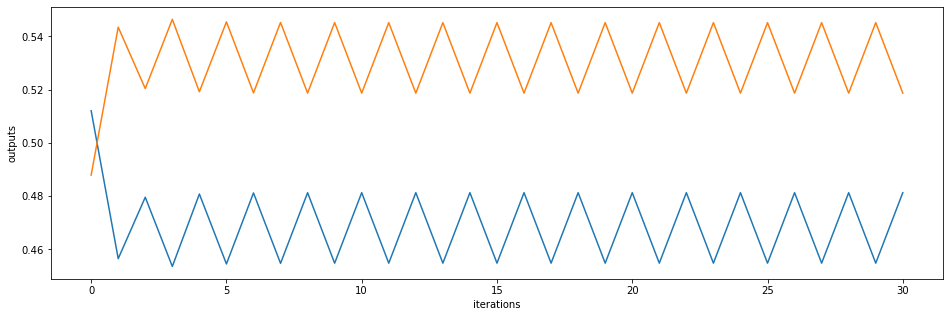

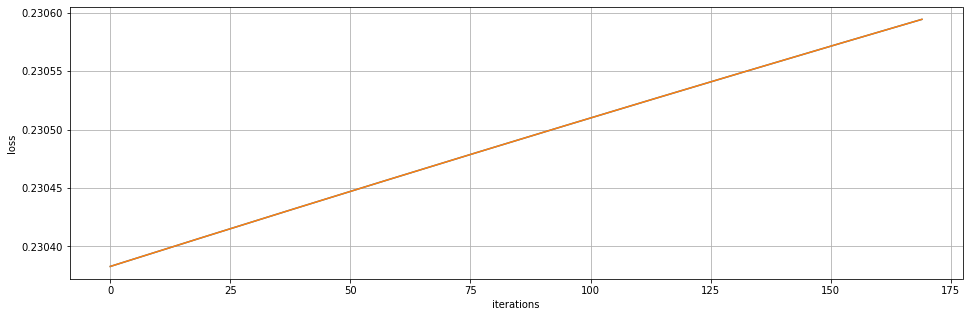

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 211
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41677581]
 [ 0.49621467]]
gradient[[-0.02865256]
 [ 0.05927481]
 [ 0.01168789]
 [-0.02009479]]
gradient[[ 0.49916581]
 [-0.54167998]]
gradient[[ 0.01611779]
 [-0.03292487]
 [-0.00586272]
 [ 0.0104343 ]]
gradient[[-0.41144185]
 [ 0.49568752]]
gradient[[-0.0304974 ]
 [ 0.06280375]
 [ 0.01199073]
 [-0.02156673]]
gradient[[ 0.49926158]
 [-0.53916799]]
gradient[[ 0.01513233]
 [-0.03089235]
 [-0.0054744 ]
 [ 0.00977699]]
gradient[[-0.4131495]
 [ 0.4958604]]
gradient[[-0.02995074]
 [ 0.061681  ]
 [ 0.01178002]
 [-0.02114139]]
gradient[[ 0.49929267]
 [-0.53831932]]
gradient[[ 0.01479862]
 [-0.03021212]
 [-0.00535675]
 [ 0.00955213]]
gradient[[-0.413564

 [-0.53813556]]
gradient[[ 0.01472935]
 [-0.0300623 ]
 [-0.00532889]
 [ 0.00950606]]
gradient[[-0.41367799]
 [ 0.49591312]]
gradient[[-0.02978779]
 [ 0.06132849]
 [ 0.01170998]
 [-0.02101454]]
gradient[[ 0.49929934]
 [-0.53813485]]
gradient[[ 0.01472935]
 [-0.03006144]
 [-0.00532853]
 [ 0.00950615]]
gradient[[-0.41367925]
 [ 0.49591324]]
gradient[[-0.02978729]
 [ 0.06132778]
 [ 0.01170992]
 [-0.02101412]]
gradient[[ 0.49929934]
 [-0.53813489]]
gradient[[ 0.01472947]
 [-0.03006137]
 [-0.00532844]
 [ 0.00950625]]
gradient[[-0.41367925]
 [ 0.49591324]]
gradient[[-0.02978776]
 [ 0.0613273 ]
 [ 0.01170944]
 [-0.02101459]]
gradient[[ 0.49929936]
 [-0.53813435]]
gradient[[ 0.01472917]
 [-0.03006103]
 [-0.00532845]
 [ 0.00950602]]
gradient[[-0.4136792 ]
 [ 0.49591324]]
gradient[[-0.02978788]
 [ 0.06132723]
 [ 0.01170935]
 [-0.0210147 ]]
gradient[[ 0.49929934]
 [-0.53813501]]
gradient[[ 0.01472952]
 [-0.03006145]
 [-0.00532844]
 [ 0.0095063 ]]
gradient[[-0.41367895]
 [ 0.49591321]]
gradient[[-0

 [-0.02102297]]
gradient[[ 0.49929861]
 [-0.53815515]]
gradient[[ 0.01474049]
 [-0.03007424]
 [-0.00532823]
 [ 0.00951471]]
gradient[[-0.4136699 ]
 [ 0.49591231]]
gradient[[-0.02979691]
 [ 0.06132714]
 [ 0.01170436]
 [-0.02102311]]
gradient[[ 0.49929858]
 [-0.53815584]]
gradient[[ 0.01474086]
 [-0.03007469]
 [-0.00532823]
 [ 0.009515  ]]
gradient[[-0.41366963]
 [ 0.49591229]]
gradient[[-0.02979726]
 [ 0.06132704]
 [ 0.01170412]
 [-0.02102344]]
gradient[[ 0.49929853]
 [-0.53815744]]
gradient[[ 0.01474176]
 [-0.03007568]
 [-0.00532819]
 [ 0.00951569]]
---------------
epoch 216
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41676165]
 [ 0.49621332]]
gradient[[-0.02866773]
 [ 0.05927302]
 [ 0.01167897]
 [-0.02010903]]
gradient[[ 0.49916402]
 [-0.54172569]]
gradient[[ 0.01614328]
 [-0.03295332]
 [-0.00586171]
 [ 0.01045409]]
gradient[[-0.41142127]
 [ 0.49568542]]
gradient[[-0.03051769]
 [ 0.06280307]
 [ 0.0119793 ]
 [

 [-0.53818132]]
gradient[[ 0.01475426]
 [-0.03009137]
 [-0.00532841]
 [ 0.00952518]]
gradient[[-0.4136574 ]
 [ 0.49591107]]
gradient[[-0.02980769]
 [ 0.06132836]
 [ 0.01169901]
 [-0.02103306]]
gradient[[ 0.49929769]
 [-0.53818061]]
gradient[[ 0.01475426]
 [-0.03009051]
 [-0.00532805]
 [ 0.00952526]]
gradient[[-0.41365866]
 [ 0.49591119]]
gradient[[-0.02980719]
 [ 0.06132766]
 [ 0.01169895]
 [-0.02103264]]
gradient[[ 0.49929769]
 [-0.53818065]]
gradient[[ 0.01475438]
 [-0.03009044]
 [-0.00532796]
 [ 0.00952537]]
gradient[[-0.41365867]
 [ 0.4959112 ]]
gradient[[-0.02980766]
 [ 0.06132717]
 [ 0.01169847]
 [-0.02103311]]
gradient[[ 0.49929771]
 [-0.53818011]]
gradient[[ 0.01475408]
 [-0.0300901 ]
 [-0.00532797]
 [ 0.00952514]]
gradient[[-0.41365861]
 [ 0.49591119]]
gradient[[-0.02980778]
 [ 0.06132711]
 [ 0.01169838]
 [-0.02103322]]
gradient[[ 0.49929768]
 [-0.53818076]]
gradient[[ 0.01475443]
 [-0.03009052]
 [-0.00532796]
 [ 0.00952541]]
gradient[[-0.41365837]
 [ 0.49591117]]
gradient[[-0

 [-0.02104195]]
gradient[[ 0.49929687]
 [-0.53820316]]
gradient[[ 0.01476665]
 [-0.03010472]
 [-0.0053277 ]
 [ 0.0095348 ]]
-----------------
average loss: 
[[0.23060757]
 [0.23060757]]


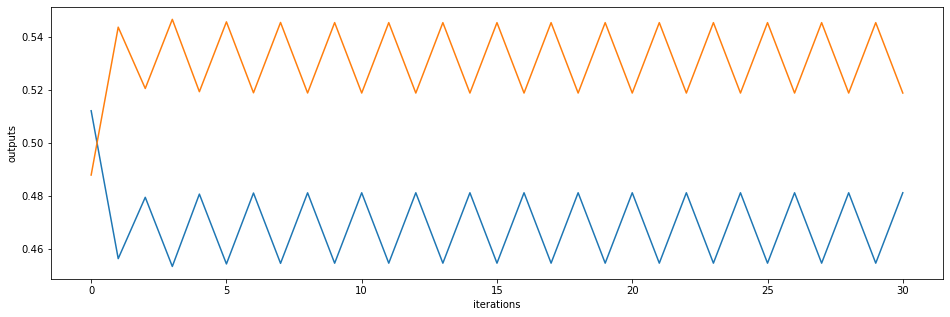

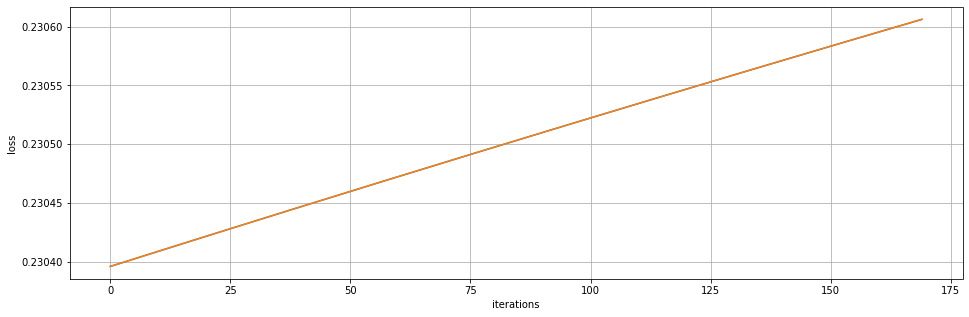

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 221
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.4167475 ]
 [ 0.49621197]]
gradient[[-0.02868289]
 [ 0.05927123]
 [ 0.01167006]
 [-0.02012326]]
gradient[[ 0.49916222]
 [-0.5417713 ]]
gradient[[ 0.01616874]
 [-0.0329817 ]
 [-0.00586068]
 [ 0.01047387]]
gradient[[-0.41140073]
 [ 0.49568331]]
gradient[[-0.03053796]
 [ 0.06280239]
 [ 0.01196788]
 [-0.02160464]]
gradient[[ 0.49925818]
 [-0.53925977]]
gradient[[ 0.01518274]
 [-0.03095024]
 [-0.00547302]
 [ 0.00981584]]
gradient[[-0.41310838]
 [ 0.49585628]]
gradient[[-0.02999072]
 [ 0.06168046]
 [ 0.01175785]
 [-0.02117864]]
gradient[[ 0.49928935]
 [-0.53841082]]
gradient[[ 0.01484853]
 [-0.03027016]
 [-0.0053557 ]
 [ 0.00959046]]
gradient[[-0.4135

 [ 0.00955283]]
gradient[[-0.41362932]
 [ 0.49590828]]
gradient[[-0.02983593]
 [ 0.06132711]
 [ 0.01168294]
 [-0.02105941]]
gradient[[ 0.49929529]
 [-0.53824691]]
gradient[[ 0.0147905 ]
 [-0.03013249]
 [-0.00532722]
 [ 0.0095531 ]]
gradient[[-0.41362894]
 [ 0.49590824]]
gradient[[-0.02983652]
 [ 0.06132688]
 [ 0.01168251]
 [-0.02105998]]
gradient[[ 0.49929531]
 [-0.53824649]]
gradient[[ 0.01479025]
 [-0.03013225]
 [-0.00532725]
 [ 0.0095529 ]]
gradient[[-0.41362879]
 [ 0.49590822]]
gradient[[-0.02983666]
 [ 0.06132688]
 [ 0.01168244]
 [-0.02106011]]
gradient[[ 0.49929528]
 [-0.53824718]]
gradient[[ 0.01479062]
 [-0.03013269]
 [-0.00532725]
 [ 0.00955319]]
gradient[[-0.41362852]
 [ 0.4959082 ]]
gradient[[-0.02983702]
 [ 0.06132678]
 [ 0.0116822 ]
 [-0.02106044]]
gradient[[ 0.49929522]
 [-0.53824878]]
gradient[[ 0.01479151]
 [-0.03013368]
 [-0.00532721]
 [ 0.00955388]]
---------------
epoch 226
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [

 [-0.53831717]]
gradient[[ 0.01482148]
 [-0.03018485]
 [-0.0053335 ]
 [ 0.00957526]]
gradient[[-0.41358723]
 [ 0.49590409]]
gradient[[-0.0298563 ]
 [ 0.06134744]
 [ 0.01168105]
 [-0.021077  ]]
gradient[[ 0.49929405]
 [-0.53828111]]
gradient[[ 0.01480724]
 [-0.03015619]
 [-0.00532867]
 [ 0.00956554]]
gradient[[-0.4136105]
 [ 0.4959064]]
gradient[[-0.02984901]
 [ 0.06133216]
 [ 0.01167808]
 [-0.02107125]]
gradient[[ 0.49929436]
 [-0.53827258]]
gradient[[ 0.01480399]
 [-0.0301493 ]
 [-0.00532742]
 [ 0.00956335]]
gradient[[-0.41361633]
 [ 0.49590698]]
gradient[[-0.02984742]
 [ 0.0613281 ]
 [ 0.01167709]
 [-0.02107004]]
gradient[[ 0.49929439]
 [-0.53827186]]
gradient[[ 0.01480398]
 [-0.03014844]
 [-0.00532706]
 [ 0.00956343]]
gradient[[-0.41361759]
 [ 0.49590711]]
gradient[[-0.02984693]
 [ 0.06132739]
 [ 0.01167704]
 [-0.02106962]]
gradient[[ 0.49929439]
 [-0.5382719 ]]
gradient[[ 0.0148041 ]
 [-0.03014837]
 [-0.00532697]
 [ 0.00956354]]
gradient[[-0.41361759]
 [ 0.49590711]]
gradient[[-0.0

 [-0.53829245]]
gradient[[ 0.01481533]
 [-0.03016138]
 [-0.00532671]
 [ 0.00957217]]
gradient[[-0.41360843]
 [ 0.4959062 ]]
gradient[[-0.02985637]
 [ 0.06132674]
 [ 0.01167157]
 [-0.02107845]]
gradient[[ 0.49929366]
 [-0.53829203]]
gradient[[ 0.01481508]
 [-0.03016115]
 [-0.00532674]
 [ 0.00957197]]
gradient[[-0.41360828]
 [ 0.49590618]]
gradient[[-0.02985651]
 [ 0.06132674]
 [ 0.01167149]
 [-0.02107858]]
gradient[[ 0.49929363]
 [-0.53829272]]
gradient[[ 0.01481544]
 [-0.03016159]
 [-0.00532674]
 [ 0.00957225]]
gradient[[-0.41360801]
 [ 0.49590616]]
gradient[[-0.02985686]
 [ 0.06132664]
 [ 0.01167125]
 [-0.02107892]]
gradient[[ 0.49929358]
 [-0.53829432]]
gradient[[ 0.01481634]
 [-0.03016257]
 [-0.0053267 ]
 [ 0.00957294]]
-----------------
average loss: 
[[0.23061952]
 [0.23061952]]


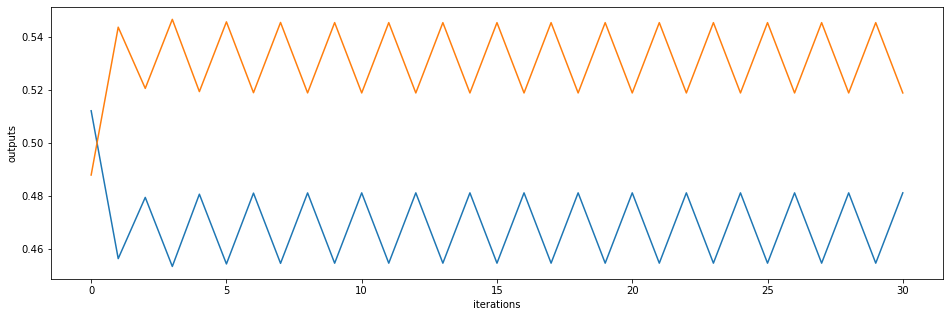

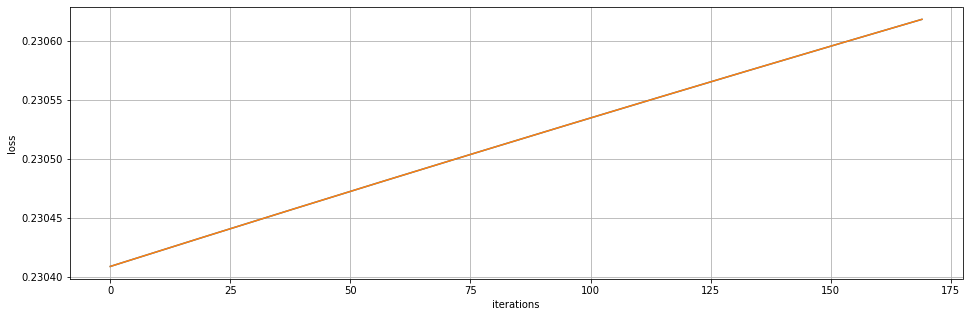

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 231
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41671927]
 [ 0.49620928]]
gradient[[-0.02871314]
 [ 0.05926765]
 [ 0.01165227]
 [-0.02015166]]
gradient[[ 0.49915864]
 [-0.54186227]]
gradient[[ 0.01621955]
 [-0.03303824]
 [-0.0058586 ]
 [ 0.01051335]]
gradient[[-0.41135973]
 [ 0.49567911]]
gradient[[-0.03057843]
 [ 0.06280101]
 [ 0.01194506]
 [-0.02164247]]
gradient[[ 0.49925479]
 [-0.5393512 ]]
gradient[[ 0.01523302]
 [-0.03100784]
 [-0.00547159]
 [ 0.0098546 ]]
gradient[[-0.41306737]
 [ 0.49585218]]
gradient[[-0.03003062]
 [ 0.06167988]
 [ 0.01173571]
 [-0.02121581]]
gradient[[ 0.49928603]
 [-0.53850196]]
gradient[[ 0.01489831]
 [-0.03032791]
 [-0.0053546 ]
 [ 0.00962871]]
gradient[[-0.4134

gradient[[-0.41359709]
 [ 0.49590507]]
gradient[[-0.02986676]
 [ 0.06132725]
 [ 0.01166609]
 [-0.02108808]]
gradient[[ 0.49929274]
 [-0.53831739]]
gradient[[ 0.01482891]
 [-0.03017723]
 [-0.00532645]
 [ 0.00958259]]
gradient[[-0.4135971 ]
 [ 0.49590507]]
gradient[[-0.02986723]
 [ 0.06132676]
 [ 0.01166562]
 [-0.02108855]]
gradient[[ 0.49929276]
 [-0.53831685]]
gradient[[ 0.01482861]
 [-0.03017689]
 [-0.00532646]
 [ 0.00958236]]
gradient[[-0.41359704]
 [ 0.49590507]]
gradient[[-0.02986735]
 [ 0.0613267 ]
 [ 0.01166553]
 [-0.02108867]]
gradient[[ 0.49929274]
 [-0.5383175 ]]
gradient[[ 0.01482896]
 [-0.0301773 ]
 [-0.00532645]
 [ 0.00958263]]
gradient[[-0.4135968 ]
 [ 0.49590504]]
gradient[[-0.02986769]
 [ 0.06132658]
 [ 0.01166529]
 [-0.02108899]]
gradient[[ 0.49929268]
 [-0.5383191 ]]
gradient[[ 0.01482986]
 [-0.03017828]
 [-0.00532641]
 [ 0.00958333]]
gradient[[-0.41359652]
 [ 0.49590501]]
gradient[[-0.02986767]
 [ 0.06132689]
 [ 0.01166543]
 [-0.02108895]]
gradient[[ 0.49929265]
 [-0.

 [ 0.49620794]]
gradient[[-0.02872824]
 [ 0.05926587]
 [ 0.01164339]
 [-0.02016583]]
gradient[[ 0.49915685]
 [-0.54190762]]
gradient[[ 0.0162449 ]
 [-0.0330664 ]
 [-0.00585755]
 [ 0.01053305]]
gradient[[-0.41133927]
 [ 0.49567701]]
gradient[[-0.03059864]
 [ 0.0628003 ]
 [ 0.01193367]
 [-0.02166135]]
gradient[[ 0.49925309]
 [-0.53939678]]
gradient[[ 0.01525811]
 [-0.03103653]
 [-0.00547086]
 [ 0.00987395]]
gradient[[-0.41304692]
 [ 0.49585013]]
gradient[[-0.03005053]
 [ 0.06167958]
 [ 0.01172465]
 [-0.02123437]]
gradient[[ 0.49928438]
 [-0.5385474 ]]
gradient[[ 0.01492315]
 [-0.03035668]
 [-0.00535403]
 [ 0.00964781]]
gradient[[-0.41346172]
 [ 0.49589159]]
gradient[[-0.02991718]
 [ 0.0614082 ]
 [ 0.01167529]
 [-0.02112948]]
gradient[[ 0.49929011]
 [-0.5383899 ]]
gradient[[ 0.01486118]
 [-0.03023095]
 [-0.00533264]
 [ 0.00960575]]
gradient[[-0.41355447]
 [ 0.49590083]]
gradient[[-0.02988802]
 [ 0.06134718]
 [ 0.01166354]
 [-0.02110653]]
gradient[[ 0.49929142]
 [-0.53835385]]
gradient[[ 0

gradient[[ 0.49929109]
 [-0.53836279]]
gradient[[ 0.01485369]
 [-0.03020601]
 [-0.00532592]
 [ 0.00960162]]
gradient[[-0.41357664]
 [ 0.49590304]]
gradient[[-0.02988704]
 [ 0.06132661]
 [ 0.01165469]
 [-0.02110699]]
gradient[[ 0.49929111]
 [-0.53836225]]
gradient[[ 0.01485339]
 [-0.03020567]
 [-0.00532593]
 [ 0.00960139]]
gradient[[-0.41357658]
 [ 0.49590303]]
gradient[[-0.02988716]
 [ 0.06132654]
 [ 0.01165459]
 [-0.02110711]]
gradient[[ 0.49929109]
 [-0.5383629 ]]
gradient[[ 0.01485374]
 [-0.03020608]
 [-0.00532592]
 [ 0.00960166]]
gradient[[-0.41357634]
 [ 0.49590301]]
gradient[[-0.0298875 ]
 [ 0.06132643]
 [ 0.01165435]
 [-0.02110743]]
gradient[[ 0.49929103]
 [-0.53836449]]
gradient[[ 0.01485464]
 [-0.03020707]
 [-0.00532588]
 [ 0.00960236]]
gradient[[-0.41357606]
 [ 0.49590298]]
gradient[[-0.02988748]
 [ 0.06132673]
 [ 0.01165449]
 [-0.02110739]]
gradient[[ 0.49929101]
 [-0.53836513]]
gradient[[ 0.01485499]
 [-0.03020747]
 [-0.00532587]
 [ 0.00960262]]
gradient[[-0.41357567]
 [ 0.

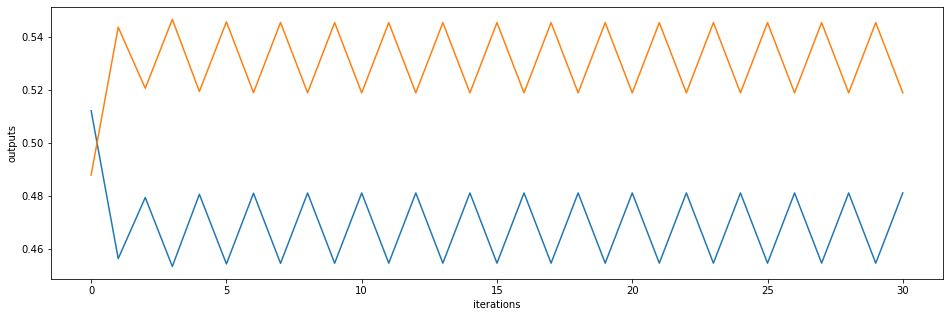

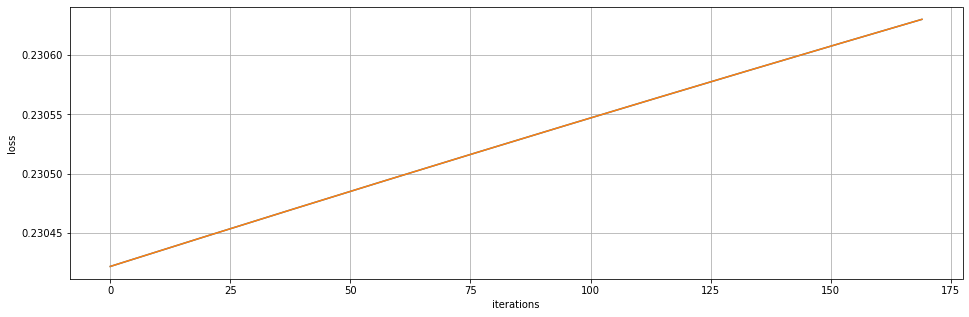

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 241
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41669111]
 [ 0.49620659]]
gradient[[-0.02874332]
 [ 0.05926409]
 [ 0.01163453]
 [-0.02017999]]
gradient[[ 0.49915507]
 [-0.54195288]]
gradient[[ 0.01627022]
 [-0.0330945 ]
 [-0.00585648]
 [ 0.01055273]]
gradient[[-0.41131885]
 [ 0.49567492]]
gradient[[-0.03061881]
 [ 0.06279959]
 [ 0.01192229]
 [-0.02168022]]
gradient[[ 0.4992514 ]
 [-0.53944226]]
gradient[[ 0.01528316]
 [-0.03106515]
 [-0.00547011]
 [ 0.00989327]]
gradient[[-0.41302649]
 [ 0.49584808]]
gradient[[-0.03007042]
 [ 0.06167927]
 [ 0.01171361]
 [-0.0212529 ]]
gradient[[ 0.49928272]
 [-0.53859276]]
gradient[[ 0.01494796]
 [-0.03038537]
 [-0.00535345]
 [ 0.00966688]]
gradient[[-0.4134

 [ 0.00962063]]
gradient[[-0.4135562]
 [ 0.495901 ]]
gradient[[-0.02990683]
 [ 0.06132645]
 [ 0.01164376]
 [-0.02112541]]
gradient[[ 0.49928947]
 [-0.53840757]]
gradient[[ 0.01487813]
 [-0.03023439]
 [-0.00532539]
 [ 0.0096204 ]]
gradient[[-0.41355614]
 [ 0.495901  ]]
gradient[[-0.02990695]
 [ 0.06132638]
 [ 0.01164367]
 [-0.02112553]]
gradient[[ 0.49928944]
 [-0.53840821]]
gradient[[ 0.01487849]
 [-0.0302348 ]
 [-0.00532538]
 [ 0.00962067]]
gradient[[-0.41355591]
 [ 0.49590097]]
gradient[[-0.02990729]
 [ 0.06132627]
 [ 0.01164343]
 [-0.02112585]]
gradient[[ 0.49928939]
 [-0.53840981]]
gradient[[ 0.01487938]
 [-0.03023578]
 [-0.00532534]
 [ 0.00962137]]
gradient[[-0.41355562]
 [ 0.49590094]]
gradient[[-0.02990727]
 [ 0.06132657]
 [ 0.01164357]
 [-0.02112581]]
gradient[[ 0.49928936]
 [-0.53841044]]
gradient[[ 0.01487973]
 [-0.03023617]
 [-0.00532533]
 [ 0.00962163]]
gradient[[-0.41355524]
 [ 0.49590091]]
gradient[[-0.02990786]
 [ 0.06132634]
 [ 0.01164314]
 [-0.02112638]]
gradient[[ 0.4

 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41667143]
 [ 0.49620472]]
gradient[[-0.02876439]
 [ 0.0592616 ]
 [ 0.01162214]
 [-0.02019977]]
gradient[[ 0.49915257]
 [-0.54201609]]
gradient[[ 0.0163056 ]
 [-0.03313371]
 [-0.00585496]
 [ 0.01058025]]
gradient[[-0.41129031]
 [ 0.49567199]]
gradient[[-0.03064702]
 [ 0.06279858]
 [ 0.01190636]
 [-0.02170659]]
gradient[[ 0.49924903]
 [-0.5395058 ]]
gradient[[ 0.01531818]
 [-0.0311051 ]
 [-0.00546904]
 [ 0.0099203 ]]
gradient[[-0.41299795]
 [ 0.49584522]]
gradient[[-0.03009822]
 [ 0.06167882]
 [ 0.01169815]
 [-0.02127882]]
gradient[[ 0.49928041]
 [-0.5386561 ]]
gradient[[ 0.01498263]
 [-0.03042542]
 [-0.00535261]
 [ 0.00969355]]
gradient[[-0.41341277]
 [ 0.49588671]]
gradient[[-0.02996469]
 [ 0.06140769]
 [ 0.01164901]
 [-0.02117372]]
gradient[[ 0.49928616]
 [-0.53849857]]
gradient[[ 0.01492056]
 [-0.03029977]
 [-0.00533131]
 [ 0.00965138]]
gradient[[-0.41350548]
 [ 0.49589595]]
gradient[[-0

 [-0.02115117]]
gradient[[ 0.49928717]
 [-0.53847086]]
gradient[[ 0.01491272]
 [-0.03027446]
 [-0.00532461]
 [ 0.00964698]]
gradient[[-0.41352759]
 [ 0.49589815]]
gradient[[-0.02993461]
 [ 0.06132615]
 [ 0.01162839]
 [-0.02115128]]
gradient[[ 0.49928714]
 [-0.5384715 ]]
gradient[[ 0.01491308]
 [-0.03027487]
 [-0.0053246 ]
 [ 0.00964725]]
gradient[[-0.41352735]
 [ 0.49589813]]
gradient[[-0.02993496]
 [ 0.06132603]
 [ 0.01162815]
 [-0.02115161]]
gradient[[ 0.49928708]
 [-0.53847309]]
gradient[[ 0.01491397]
 [-0.03027585]
 [-0.00532456]
 [ 0.00964794]]
gradient[[-0.41352707]
 [ 0.4958981 ]]
gradient[[-0.02993494]
 [ 0.06132634]
 [ 0.01162829]
 [-0.02115157]]
gradient[[ 0.49928706]
 [-0.53847372]]
gradient[[ 0.01491432]
 [-0.03027625]
 [-0.00532454]
 [ 0.00964821]]
gradient[[-0.41352669]
 [ 0.49589806]]
gradient[[-0.02993553]
 [ 0.06132611]
 [ 0.01162787]
 [-0.02115213]]
gradient[[ 0.49928708]
 [-0.53847331]]
gradient[[ 0.01491407]
 [-0.03027601]
 [-0.00532458]
 [ 0.00964801]]
gradient[[-0

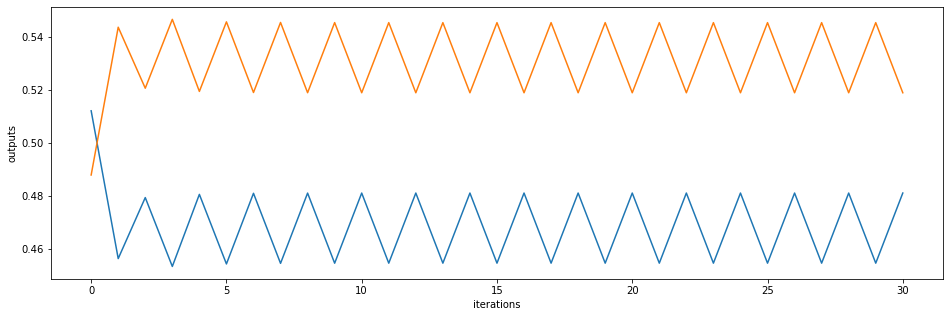

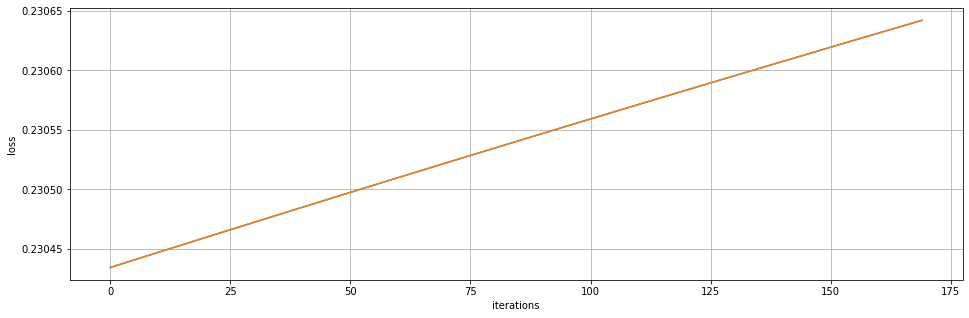

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 251
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41666301]
 [ 0.49620391]]
gradient[[-0.02877341]
 [ 0.05926053]
 [ 0.01161683]
 [-0.02020824]]
gradient[[ 0.4991515 ]
 [-0.54204313]]
gradient[[ 0.01632075]
 [-0.03315047]
 [-0.00585431]
 [ 0.01059203]]
gradient[[-0.4112781 ]
 [ 0.49567074]]
gradient[[-0.0306591 ]
 [ 0.06279815]
 [ 0.01189954]
 [-0.02171788]]
gradient[[ 0.49924802]
 [-0.53953297]]
gradient[[ 0.01533317]
 [-0.03112217]
 [-0.00546858]
 [ 0.00993186]]
gradient[[-0.41298574]
 [ 0.49584399]]
gradient[[-0.03011013]
 [ 0.06167863]
 [ 0.01169154]
 [-0.02128991]]
gradient[[ 0.49927942]
 [-0.53868319]]
gradient[[ 0.01499747]
 [-0.03044254]
 [-0.00535225]
 [ 0.00970496]]
gradient[[-0.4134

 [ 0.49589694]]
gradient[[-0.02994634]
 [ 0.06132611]
 [ 0.01162194]
 [-0.02116219]]
gradient[[ 0.49928618]
 [-0.53849793]]
gradient[[ 0.01492753]
 [-0.0302916 ]
 [-0.00532427]
 [ 0.00965836]]
gradient[[-0.41351537]
 [ 0.49589693]]
gradient[[-0.02994646]
 [ 0.06132604]
 [ 0.01162185]
 [-0.02116231]]
gradient[[ 0.49928616]
 [-0.53849858]]
gradient[[ 0.01492788]
 [-0.030292  ]
 [-0.00532426]
 [ 0.00965863]]
gradient[[-0.41351513]
 [ 0.49589691]]
gradient[[-0.0299468 ]
 [ 0.06132593]
 [ 0.01162161]
 [-0.02116263]]
gradient[[ 0.4992861 ]
 [-0.53850016]]
gradient[[ 0.01492878]
 [-0.03029298]
 [-0.00532421]
 [ 0.00965932]]
gradient[[-0.41351485]
 [ 0.49589688]]
gradient[[-0.02994678]
 [ 0.06132623]
 [ 0.01162175]
 [-0.02116259]]
gradient[[ 0.49928608]
 [-0.53850079]]
gradient[[ 0.01492912]
 [-0.03029338]
 [-0.0053242 ]
 [ 0.00965959]]
gradient[[-0.41351447]
 [ 0.49589684]]
gradient[[-0.02994737]
 [ 0.061326  ]
 [ 0.01162132]
 [-0.02116316]]
gradient[[ 0.49928609]
 [-0.53850038]]
gradient[[ 0

 [-0.00299201]]
gradient[[-0.41664899]
 [ 0.49620258]]
gradient[[-0.02878843]
 [ 0.05925876]
 [ 0.011608  ]
 [-0.02022234]]
gradient[[ 0.49914972]
 [-0.54208813]]
gradient[[ 0.01634596]
 [-0.03317836]
 [-0.00585321]
 [ 0.01061164]]
gradient[[-0.41125777]
 [ 0.49566865]]
gradient[[-0.03067921]
 [ 0.06279741]
 [ 0.01188819]
 [-0.02173667]]
gradient[[ 0.49924633]
 [-0.53957819]]
gradient[[ 0.01535812]
 [-0.03115057]
 [-0.00546779]
 [ 0.00995112]]
gradient[[-0.4129654 ]
 [ 0.49584195]]
gradient[[-0.03012995]
 [ 0.0616783 ]
 [ 0.01168052]
 [-0.02130839]]
gradient[[ 0.49927777]
 [-0.53872828]]
gradient[[ 0.01502218]
 [-0.03047102]
 [-0.00535162]
 [ 0.00972397]]
gradient[[-0.41338022]
 [ 0.49588346]]
gradient[[-0.02999629]
 [ 0.06140733]
 [ 0.01163151]
 [-0.02120314]]
gradient[[ 0.49928353]
 [-0.53857074]]
gradient[[ 0.01496005]
 [-0.03034542]
 [-0.00533037]
 [ 0.00968174]]
gradient[[-0.41347292]
 [ 0.4958927 ]]
gradient[[-0.02996709]
 [ 0.06134644]
 [ 0.01161984]
 [-0.02118014]]
gradient[[ 0

 [-0.02118009]]
gradient[[ 0.49928452]
 [-0.53854352]]
gradient[[ 0.01495248]
 [-0.03032043]
 [-0.00532367]
 [ 0.00967753]]
gradient[[-0.41349508]
 [ 0.49589491]]
gradient[[-0.02996606]
 [ 0.06132593]
 [ 0.01161104]
 [-0.02118055]]
gradient[[ 0.49928454]
 [-0.53854298]]
gradient[[ 0.01495218]
 [-0.03032009]
 [-0.00532369]
 [ 0.0096773 ]]
gradient[[-0.41349502]
 [ 0.49589491]]
gradient[[-0.02996618]
 [ 0.06132586]
 [ 0.01161095]
 [-0.02118067]]
gradient[[ 0.49928452]
 [-0.53854363]]
gradient[[ 0.01495253]
 [-0.0303205 ]
 [-0.00532368]
 [ 0.00967757]]
gradient[[-0.41349479]
 [ 0.49589488]]
gradient[[-0.02996652]
 [ 0.06132575]
 [ 0.01161071]
 [-0.02118099]]
gradient[[ 0.49928446]
 [-0.53854521]]
gradient[[ 0.01495342]
 [-0.03032147]
 [-0.00532363]
 [ 0.00967827]]
gradient[[-0.4134945 ]
 [ 0.49589486]]
gradient[[-0.02996651]
 [ 0.06132605]
 [ 0.01161085]
 [-0.02118095]]
gradient[[ 0.49928444]
 [-0.53854584]]
gradient[[ 0.01495377]
 [-0.03032187]
 [-0.00532362]
 [ 0.00967853]]
gradient[[-0

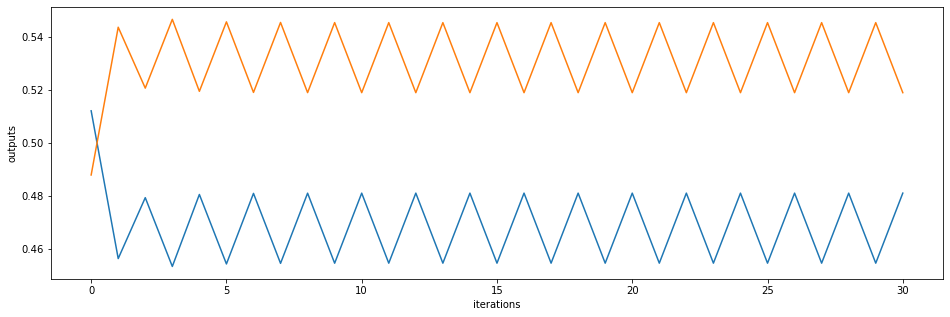

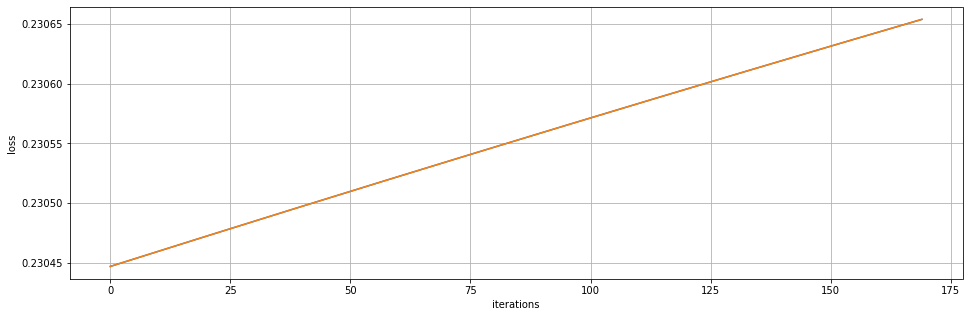

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 261
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41663499]
 [ 0.49620124]]
gradient[[-0.02880344]
 [ 0.05925698]
 [ 0.01159918]
 [-0.02023642]]
gradient[[ 0.49914794]
 [-0.54213303]]
gradient[[ 0.01637114]
 [-0.03320617]
 [-0.0058521 ]
 [ 0.01063123]]
gradient[[-0.41123747]
 [ 0.49566657]]
gradient[[-0.03069929]
 [ 0.06279667]
 [ 0.01187684]
 [-0.02175545]]
gradient[[ 0.49924464]
 [-0.53962333]]
gradient[[ 0.01538304]
 [-0.0311789 ]
 [-0.00546699]
 [ 0.00997036]]
gradient[[-0.4129451 ]
 [ 0.49583991]]
gradient[[-0.03014975]
 [ 0.06167796]
 [ 0.01166951]
 [-0.02132684]]
gradient[[ 0.49927612]
 [-0.53877327]]
gradient[[ 0.01504686]
 [-0.03049943]
 [-0.00535099]
 [ 0.00974296]]
gradient[[-0.4133

 [ 0.49589218]]
gradient[[-0.02998738]
 [ 0.06133095]
 [ 0.01160165]
 [-0.02120006]]
gradient[[ 0.49928285]
 [-0.53858917]]
gradient[[ 0.01497699]
 [-0.0303498 ]
 [-0.00532354]
 [ 0.00969628]]
gradient[[-0.41347351]
 [ 0.49589276]]
gradient[[-0.0299858 ]
 [ 0.06132692]
 [ 0.01160068]
 [-0.02119885]]
gradient[[ 0.49928288]
 [-0.53858845]]
gradient[[ 0.01497698]
 [-0.03034893]
 [-0.00532317]
 [ 0.00969635]]
gradient[[-0.41347476]
 [ 0.49589289]]
gradient[[-0.0299853 ]
 [ 0.06132621]
 [ 0.01160062]
 [-0.02119843]]
gradient[[ 0.49928288]
 [-0.53858848]]
gradient[[ 0.01497709]
 [-0.03034886]
 [-0.00532308]
 [ 0.00969646]]
gradient[[-0.41347477]
 [ 0.49589289]]
gradient[[-0.02998576]
 [ 0.06132574]
 [ 0.01160015]
 [-0.02119889]]
gradient[[ 0.4992829 ]
 [-0.53858794]]
gradient[[ 0.01497679]
 [-0.03034852]
 [-0.0053231 ]
 [ 0.00969623]]
gradient[[-0.41347471]
 [ 0.49589288]]
gradient[[-0.02998588]
 [ 0.06132567]
 [ 0.01160006]
 [-0.02119901]]
gradient[[ 0.49928288]
 [-0.53858859]]
gradient[[ 0

 [-0.53860834]]
gradient[[ 0.01498796]
 [-0.03036141]
 [-0.00532282]
 [ 0.00970482]]
gradient[[-0.41346554]
 [ 0.49589197]]
gradient[[-0.02999481]
 [ 0.06132554]
 [ 0.01159511]
 [-0.02120732]]
gradient[[ 0.49928213]
 [-0.53860902]]
gradient[[ 0.01498833]
 [-0.03036184]
 [-0.00532282]
 [ 0.0097051 ]]
gradient[[-0.41346528]
 [ 0.49589194]]
gradient[[-0.02999515]
 [ 0.06132545]
 [ 0.01159487]
 [-0.02120765]]
gradient[[ 0.49928207]
 [-0.53861059]]
gradient[[ 0.01498922]
 [-0.03036281]
 [-0.00532277]
 [ 0.00970579]]
---------------
epoch 266
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41662101]
 [ 0.4961999 ]]
gradient[[-0.02881842]
 [ 0.05925521]
 [ 0.01159037]
 [-0.02025049]]
gradient[[ 0.49914616]
 [-0.54217785]]
gradient[[ 0.01639628]
 [-0.03323391]
 [-0.00585097]
 [ 0.01065079]]
gradient[[-0.4112172 ]
 [ 0.49566449]]
gradient[[-0.03071935]
 [ 0.06279592]
 [ 0.01186551]
 [-0.02177421]]
gradient[[ 0.49924295]
 [

gradient[[-0.03000706]
 [ 0.06133075]
 [ 0.01159077]
 [-0.02121838]]
gradient[[ 0.49928122]
 [-0.53863405]]
gradient[[ 0.01500157]
 [-0.03037815]
 [-0.00532293]
 [ 0.00971518]]
gradient[[-0.41345322]
 [ 0.49589074]]
gradient[[-0.03000547]
 [ 0.06132672]
 [ 0.0115898 ]
 [-0.02121717]]
gradient[[ 0.49928124]
 [-0.53863332]]
gradient[[ 0.01500156]
 [-0.03037728]
 [-0.00532257]
 [ 0.00971526]]
gradient[[-0.41345447]
 [ 0.49589087]]
gradient[[-0.03000498]
 [ 0.06132602]
 [ 0.01158974]
 [-0.02121675]]
gradient[[ 0.49928124]
 [-0.53863335]]
gradient[[ 0.01500167]
 [-0.03037721]
 [-0.00532248]
 [ 0.00971536]]
gradient[[-0.41345448]
 [ 0.49589087]]
gradient[[-0.03000544]
 [ 0.06132554]
 [ 0.01158927]
 [-0.02121721]]
gradient[[ 0.49928126]
 [-0.53863282]]
gradient[[ 0.01500137]
 [-0.03037688]
 [-0.00532249]
 [ 0.00971513]]
gradient[[-0.41345442]
 [ 0.49589086]]
gradient[[-0.03000556]
 [ 0.06132547]
 [ 0.01158918]
 [-0.02121733]]
gradient[[ 0.49928124]
 [-0.53863346]]
gradient[[ 0.01500172]
 [-0.

 [-0.02122494]]
gradient[[ 0.4992805 ]
 [-0.53865359]]
gradient[[ 0.01501278]
 [-0.03038996]
 [-0.00532218]
 [ 0.00972391]]
gradient[[-0.41344542]
 [ 0.49588996]]
gradient[[-0.03001433]
 [ 0.06132535]
 [ 0.01158431]
 [-0.0212255 ]]
gradient[[ 0.49928052]
 [-0.53865318]]
gradient[[ 0.01501253]
 [-0.03038973]
 [-0.00532221]
 [ 0.00972372]]
gradient[[-0.41344527]
 [ 0.49588995]]
gradient[[-0.03001447]
 [ 0.06132534]
 [ 0.01158423]
 [-0.02122563]]
gradient[[ 0.49928049]
 [-0.53865385]]
gradient[[ 0.01501289]
 [-0.03039016]
 [-0.00532221]
 [ 0.009724  ]]
gradient[[-0.41344501]
 [ 0.49588992]]
gradient[[-0.03001482]
 [ 0.06132524]
 [ 0.011584  ]
 [-0.02122596]]
gradient[[ 0.49928044]
 [-0.53865542]]
gradient[[ 0.01501378]
 [-0.03039113]
 [-0.00532216]
 [ 0.00972468]]
-----------------
average loss: 
[[0.23066677]
 [0.23066677]]


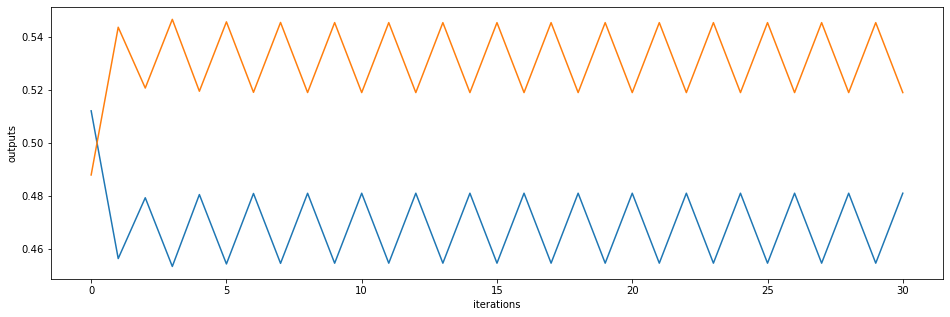

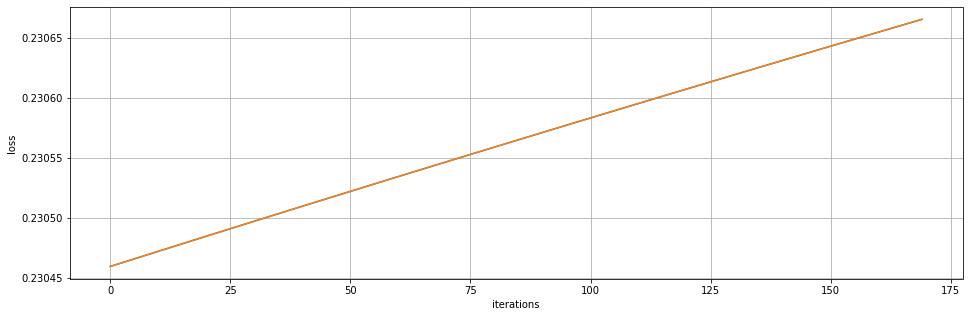

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 271
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41660704]
 [ 0.49619857]]
gradient[[-0.02883338]
 [ 0.05925344]
 [ 0.01158158]
 [-0.02026453]]
gradient[[ 0.49914439]
 [-0.54222258]]
gradient[[ 0.01642139]
 [-0.03326158]
 [-0.00584984]
 [ 0.01067034]]
gradient[[-0.41119696]
 [ 0.49566241]]
gradient[[-0.03073939]
 [ 0.06279517]
 [ 0.01185418]
 [-0.02179294]]
gradient[[ 0.49924127]
 [-0.53971332]]
gradient[[ 0.01543278]
 [-0.03123535]
 [-0.00546536]
 [ 0.01000877]]
gradient[[-0.41290458]
 [ 0.49583585]]
gradient[[-0.03018928]
 [ 0.06167725]
 [ 0.01164751]
 [-0.02136369]]
gradient[[ 0.49927283]
 [-0.538863  ]]
gradient[[ 0.0150961 ]
 [-0.03055603]
 [-0.00534969]
 [ 0.00978087]]
gradient[[-0.4133

gradient[[-0.41343422]
 [ 0.49588885]]
gradient[[-0.03002464]
 [ 0.06132581]
 [ 0.01157887]
 [-0.02123505]]
gradient[[ 0.4992796 ]
 [-0.53867814]]
gradient[[ 0.01502622]
 [-0.03040549]
 [-0.00532186]
 [ 0.00973424]]
gradient[[-0.41343423]
 [ 0.49588885]]
gradient[[-0.0300251 ]
 [ 0.06132533]
 [ 0.0115784 ]
 [-0.02123551]]
gradient[[ 0.49927962]
 [-0.5386776 ]]
gradient[[ 0.01502592]
 [-0.03040516]
 [-0.00532187]
 [ 0.00973401]]
gradient[[-0.41343417]
 [ 0.49588884]]
gradient[[-0.03002521]
 [ 0.06132527]
 [ 0.01157831]
 [-0.02123563]]
gradient[[ 0.4992796 ]
 [-0.53867824]]
gradient[[ 0.01502627]
 [-0.03040556]
 [-0.00532186]
 [ 0.00973428]]
gradient[[-0.41343393]
 [ 0.49588882]]
gradient[[-0.03002555]
 [ 0.06132515]
 [ 0.01157807]
 [-0.02123595]]
gradient[[ 0.49927954]
 [-0.53867982]]
gradient[[ 0.01502716]
 [-0.03040653]
 [-0.00532182]
 [ 0.00973497]]
gradient[[-0.41343365]
 [ 0.49588879]]
gradient[[-0.03002554]
 [ 0.06132545]
 [ 0.01157821]
 [-0.02123591]]
gradient[[ 0.49927952]
 [-0.

gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41658751]
 [ 0.4961967 ]]
gradient[[-0.02885429]
 [ 0.05925097]
 [ 0.01156928]
 [-0.02028417]]
gradient[[ 0.4991419 ]
 [-0.54228505]]
gradient[[ 0.01645648]
 [-0.03330021]
 [-0.00584823]
 [ 0.01069766]]
gradient[[-0.41116868]
 [ 0.49565951]]
gradient[[-0.03076741]
 [ 0.0627941 ]
 [ 0.01183834]
 [-0.02181914]]
gradient[[ 0.49923891]
 [-0.53977611]]
gradient[[ 0.01546751]
 [-0.03127469]
 [-0.00546419]
 [ 0.01003561]]
gradient[[-0.41287629]
 [ 0.495833  ]]
gradient[[-0.0302169 ]
 [ 0.06167675]
 [ 0.01163214]
 [-0.02138943]]
gradient[[ 0.49927053]
 [-0.5389256 ]]
gradient[[ 0.0151305 ]
 [-0.03059548]
 [-0.00534875]
 [ 0.00980736]]
gradient[[-0.41329113]
 [ 0.49587456]]
gradient[[-0.0300829 ]
 [ 0.06140623]
 [ 0.01158353]
 [-0.02128381]]
gradient[[ 0.49927631]
 [-0.53876803]]
gradient[[ 0.01506819]
 [-0.03047001]
 [-0.00532765]
 [ 0.00976493]]
gradient[[-0.41338376]
 [ 0.

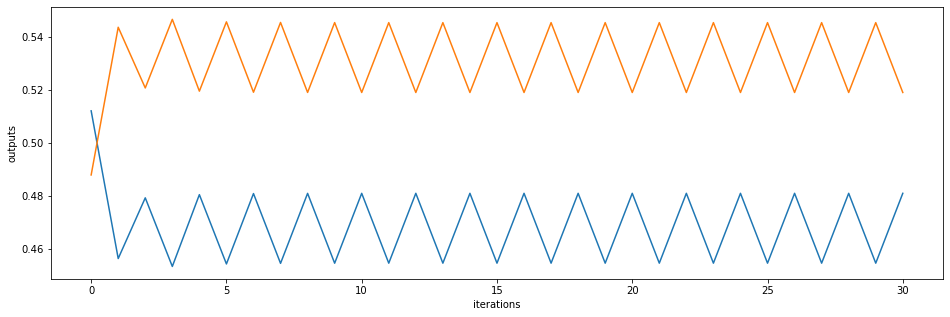

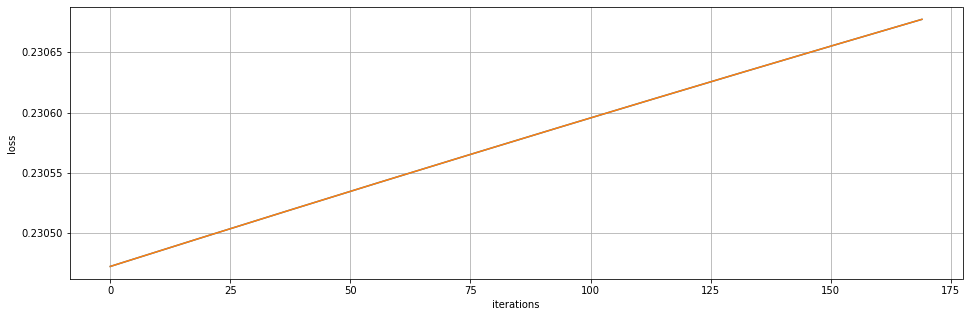

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 281
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41657916]
 [ 0.49619591]]
gradient[[-0.02886324]
 [ 0.05924991]
 [ 0.01156402]
 [-0.02029257]]
gradient[[ 0.49914084]
 [-0.54231178]]
gradient[[ 0.0164715 ]
 [-0.03331672]
 [-0.00584754]
 [ 0.01070935]]
gradient[[-0.41115658]
 [ 0.49565826]]
gradient[[-0.0307794 ]
 [ 0.06279364]
 [ 0.01183155]
 [-0.02183035]]
gradient[[ 0.49923791]
 [-0.53980296]]
gradient[[ 0.01548238]
 [-0.03129151]
 [-0.00546369]
 [ 0.01004709]]
gradient[[-0.41286419]
 [ 0.49583179]]
gradient[[-0.03022872]
 [ 0.06167652]
 [ 0.01162556]
 [-0.02140045]]
gradient[[ 0.49926954]
 [-0.53895238]]
gradient[[ 0.01514522]
 [-0.03061235]
 [-0.00534833]
 [ 0.00981869]]
gradient[[-0.4132

 [ 0.49588481]]
gradient[[-0.03006446]
 [ 0.06132484]
 [ 0.0115566 ]
 [-0.02127217]]
gradient[[ 0.49927633]
 [-0.53876755]]
gradient[[ 0.01507526]
 [-0.03046192]
 [-0.00532059]
 [ 0.00977198]]
gradient[[-0.41339351]
 [ 0.49588479]]
gradient[[-0.0300648 ]
 [ 0.06132472]
 [ 0.01155636]
 [-0.02127249]]
gradient[[ 0.49927627]
 [-0.53876912]]
gradient[[ 0.01507615]
 [-0.03046288]
 [-0.00532054]
 [ 0.00977267]]
gradient[[-0.41339324]
 [ 0.49588476]]
gradient[[-0.03006478]
 [ 0.06132502]
 [ 0.0115565 ]
 [-0.02127245]]
gradient[[ 0.49927625]
 [-0.53876974]]
gradient[[ 0.0150765 ]
 [-0.03046327]
 [-0.00532053]
 [ 0.00977294]]
gradient[[-0.41339286]
 [ 0.49588472]]
gradient[[-0.03006536]
 [ 0.06132479]
 [ 0.01155608]
 [-0.02127301]]
gradient[[ 0.49927627]
 [-0.53876933]]
gradient[[ 0.01507624]
 [-0.03046304]
 [-0.00532057]
 [ 0.00977274]]
gradient[[-0.41339271]
 [ 0.49588471]]
gradient[[-0.03006551]
 [ 0.06132479]
 [ 0.011556  ]
 [-0.02127315]]
gradient[[ 0.49927624]
 [-0.53877   ]]
gradient[[ 0

gradient[[ 0.49923623]
 [-0.53984765]]
gradient[[ 0.01550713]
 [-0.03131949]
 [-0.00546283]
 [ 0.01006622]]
gradient[[-0.41284403]
 [ 0.49582976]]
gradient[[-0.0302484 ]
 [ 0.06167615]
 [ 0.01161459]
 [-0.0214188 ]]
gradient[[ 0.4992679 ]
 [-0.53899693]]
gradient[[ 0.01516973]
 [-0.0306404 ]
 [-0.00534764]
 [ 0.00983757]]
gradient[[-0.41325888]
 [ 0.49587134]]
gradient[[-0.03011429]
 [ 0.0614058 ]
 [ 0.01156612]
 [-0.02131304]]
gradient[[ 0.4992737 ]
 [-0.53883935]]
gradient[[ 0.01510736]
 [-0.03051498]
 [-0.00532659]
 [ 0.00979508]]
gradient[[-0.41335148]
 [ 0.49588059]]
gradient[[-0.03008502]
 [ 0.06134511]
 [ 0.01155457]
 [-0.02128995]]
gradient[[ 0.49927502]
 [-0.53880338]]
gradient[[ 0.01509306]
 [-0.03048649]
 [-0.00532187]
 [ 0.00978527]]
gradient[[-0.41337465]
 [ 0.4958829 ]]
gradient[[-0.03007772]
 [ 0.06132996]
 [ 0.01155167]
 [-0.02128417]]
gradient[[ 0.49927533]
 [-0.53879487]]
gradient[[ 0.01508979]
 [-0.03047965]
 [-0.00532065]
 [ 0.00978306]]
gradient[[-0.41338045]
 [ 0.

 [ 0.0097908 ]]
gradient[[-0.41337335]
 [ 0.49588277]]
gradient[[-0.03008438]
 [ 0.06132449]
 [ 0.01154552]
 [-0.02129073]]
gradient[[ 0.49927464]
 [-0.53881364]]
gradient[[ 0.0151006 ]
 [-0.03049095]
 [-0.00531989]
 [ 0.00979149]]
gradient[[-0.41337307]
 [ 0.49588275]]
gradient[[-0.03008437]
 [ 0.06132479]
 [ 0.01154565]
 [-0.02129069]]
gradient[[ 0.49927462]
 [-0.53881426]]
gradient[[ 0.01510094]
 [-0.03049134]
 [-0.00531988]
 [ 0.00979175]]
gradient[[-0.41337269]
 [ 0.49588271]]
gradient[[-0.03008495]
 [ 0.06132456]
 [ 0.01154523]
 [-0.02129125]]
gradient[[ 0.49927463]
 [-0.53881385]]
gradient[[ 0.01510069]
 [-0.03049111]
 [-0.00531991]
 [ 0.00979155]]
gradient[[-0.41337255]
 [ 0.49588269]]
gradient[[-0.03008509]
 [ 0.06132456]
 [ 0.01154516]
 [-0.02129138]]
gradient[[ 0.49927461]
 [-0.53881452]]
gradient[[ 0.01510105]
 [-0.03049154]
 [-0.00531991]
 [ 0.00979183]]
gradient[[-0.41337229]
 [ 0.49588267]]
gradient[[-0.03008544]
 [ 0.06132446]
 [ 0.01154492]
 [-0.02129171]]
gradient[[ 0

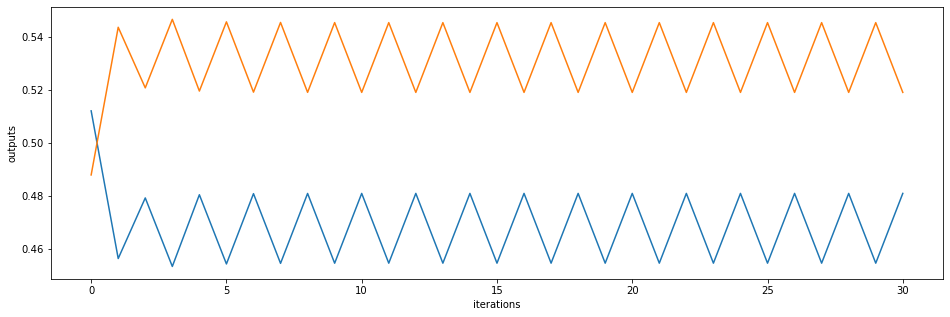

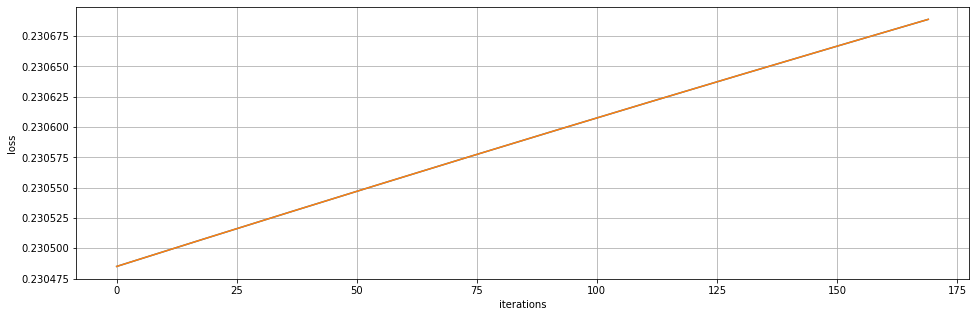

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 291
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41655134]
 [ 0.49619325]]
gradient[[-0.02889303]
 [ 0.05924639]
 [ 0.0115465 ]
 [-0.02032053]]
gradient[[ 0.4991373 ]
 [-0.54240062]]
gradient[[ 0.01652147]
 [-0.03337158]
 [-0.0058452 ]
 [ 0.01074827]]
gradient[[-0.41111631]
 [ 0.49565412]]
gradient[[-0.03081931]
 [ 0.06279208]
 [ 0.01180897]
 [-0.02186768]]
gradient[[ 0.49923455]
 [-0.53989225]]
gradient[[ 0.01553184]
 [-0.03134739]
 [-0.00546196]
 [ 0.01008533]]
gradient[[-0.41282391]
 [ 0.49582774]]
gradient[[-0.03026807]
 [ 0.06167576]
 [ 0.01160364]
 [-0.02143713]]
gradient[[ 0.49926626]
 [-0.5390414 ]]
gradient[[ 0.0151942 ]
 [-0.03066838]
 [-0.00534693]
 [ 0.00985643]]
gradient[[-0.4132

 [ 0.00980955]]
gradient[[-0.41335351]
 [ 0.49588079]]
gradient[[-0.03010349]
 [ 0.06132444]
 [ 0.01153501]
 [-0.02130851]]
gradient[[ 0.49927309]
 [-0.53885587]]
gradient[[ 0.01512378]
 [-0.03051759]
 [-0.00531928]
 [ 0.00980933]]
gradient[[-0.41335345]
 [ 0.49588079]]
gradient[[-0.03010361]
 [ 0.06132437]
 [ 0.01153492]
 [-0.02130863]]
gradient[[ 0.49927307]
 [-0.5388565 ]]
gradient[[ 0.01512413]
 [-0.03051799]
 [-0.00531927]
 [ 0.00980959]]
gradient[[-0.41335321]
 [ 0.49588076]]
gradient[[-0.03010395]
 [ 0.06132426]
 [ 0.01153468]
 [-0.02130895]]
gradient[[ 0.49927301]
 [-0.53885807]]
gradient[[ 0.01512501]
 [-0.03051895]
 [-0.00531923]
 [ 0.00981028]]
gradient[[-0.41335294]
 [ 0.49588074]]
gradient[[-0.03010393]
 [ 0.06132456]
 [ 0.01153482]
 [-0.02130891]]
gradient[[ 0.49927299]
 [-0.53885869]]
gradient[[ 0.01512536]
 [-0.03051934]
 [-0.00531921]
 [ 0.00981055]]
gradient[[-0.41335256]
 [ 0.4958807 ]]
gradient[[-0.03010452]
 [ 0.06132433]
 [ 0.0115344 ]
 [-0.02130947]]
gradient[[ 0

gradient[[ 0.49923287]
 [-0.53993675]]
gradient[[ 0.01555652]
 [-0.03137522]
 [-0.00546108]
 [ 0.01010441]]
gradient[[-0.41280382]
 [ 0.49582572]]
gradient[[-0.03028771]
 [ 0.06167537]
 [ 0.01159269]
 [-0.02145545]]
gradient[[ 0.49926462]
 [-0.53908578]]
gradient[[ 0.01521864]
 [-0.0306963 ]
 [-0.00534622]
 [ 0.00987526]]
gradient[[-0.41321867]
 [ 0.49586732]]
gradient[[-0.03015344]
 [ 0.06140523]
 [ 0.0115444 ]
 [-0.02134951]]
gradient[[ 0.49927043]
 [-0.53892819]]
gradient[[ 0.0151562 ]
 [-0.03057094]
 [-0.00532524]
 [ 0.00983268]]
gradient[[-0.41331124]
 [ 0.49587657]]
gradient[[-0.03012415]
 [ 0.06134461]
 [ 0.01153289]
 [-0.02132639]]
gradient[[ 0.49927176]
 [-0.53889223]]
gradient[[ 0.01514188]
 [-0.03054247]
 [-0.00532053]
 [ 0.00982286]]
gradient[[-0.4133344 ]
 [ 0.49587889]]
gradient[[-0.03011685]
 [ 0.06132948]
 [ 0.01152999]
 [-0.02132061]]
gradient[[ 0.49927207]
 [-0.53888373]]
gradient[[ 0.01513861]
 [-0.03053564]
 [-0.00531932]
 [ 0.00982065]]
gradient[[-0.41334018]
 [ 0.

 [-0.53892074]]
gradient[[ 0.01515948]
 [-0.03055842]
 [-0.00531826]
 [ 0.00983682]]
gradient[[-0.41332442]
 [ 0.49587789]]
gradient[[-0.03013187]
 [ 0.06132399]
 [ 0.01151925]
 [-0.02133494]]
gradient[[ 0.49927072]
 [-0.53892034]]
gradient[[ 0.01515922]
 [-0.03055819]
 [-0.00531829]
 [ 0.00983662]]
gradient[[-0.41332427]
 [ 0.49587788]]
gradient[[-0.03013201]
 [ 0.06132398]
 [ 0.01151917]
 [-0.02133507]]
gradient[[ 0.4992707]
 [-0.538921 ]]
gradient[[ 0.01515959]
 [-0.03055861]
 [-0.00531829]
 [ 0.0098369 ]]
gradient[[-0.41332402]
 [ 0.49587785]]
gradient[[-0.03013235]
 [ 0.06132388]
 [ 0.01151894]
 [-0.0213354 ]]
gradient[[ 0.49927064]
 [-0.53892256]]
gradient[[ 0.01516047]
 [-0.03055957]
 [-0.00531824]
 [ 0.00983758]]
-----------------
average loss: 
[[0.23070162]
 [0.23070162]]


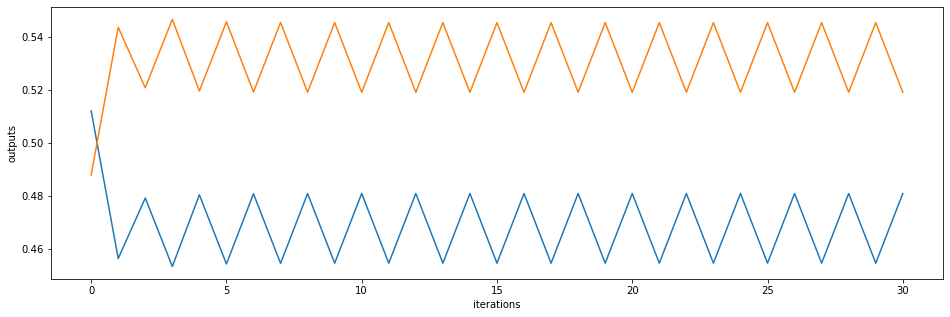

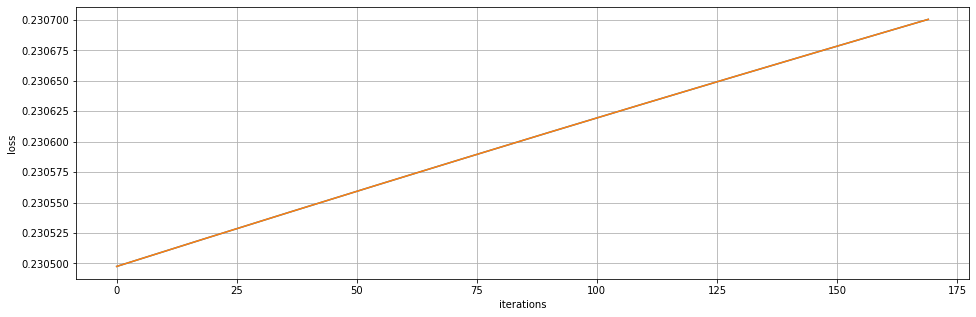

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 301
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.4165236 ]
 [ 0.49619059]]
gradient[[-0.02892275]
 [ 0.05924288]
 [ 0.01152903]
 [-0.02034842]]
gradient[[ 0.49913377]
 [-0.54248911]]
gradient[[ 0.0165713 ]
 [-0.03342617]
 [-0.00584282]
 [ 0.01078709]]
gradient[[-0.41107618]
 [ 0.49565   ]]
gradient[[-0.03085913]
 [ 0.06279049]
 [ 0.01178642]
 [-0.02190491]]
gradient[[ 0.4992312 ]
 [-0.53998118]]
gradient[[ 0.01558117]
 [-0.03140298]
 [-0.00546019]
 [ 0.01012347]]
gradient[[-0.41278376]
 [ 0.4958237 ]]
gradient[[-0.03030732]
 [ 0.06167497]
 [ 0.01158176]
 [-0.02147374]]
gradient[[ 0.49926299]
 [-0.53913007]]
gradient[[ 0.01524305]
 [-0.03072414]
 [-0.00534549]
 [ 0.00989407]]
gradient[[-0.4131

 [-0.53896269]]
gradient[[ 0.01518253]
 [-0.03058484]
 [-0.00531763]
 [ 0.00985457]]
gradient[[-0.4133053 ]
 [ 0.49587598]]
gradient[[-0.03015036]
 [ 0.06132385]
 [ 0.01150905]
 [-0.02135216]]
gradient[[ 0.49926918]
 [-0.53896216]]
gradient[[ 0.01518223]
 [-0.03058451]
 [-0.00531764]
 [ 0.00985434]]
gradient[[-0.41330525]
 [ 0.49587597]]
gradient[[-0.03015048]
 [ 0.06132378]
 [ 0.01150896]
 [-0.02135227]]
gradient[[ 0.49926916]
 [-0.53896279]]
gradient[[ 0.01518258]
 [-0.03058491]
 [-0.00531763]
 [ 0.00985461]]
gradient[[-0.41330501]
 [ 0.49587595]]
gradient[[-0.03015081]
 [ 0.06132367]
 [ 0.01150872]
 [-0.02135259]]
gradient[[ 0.4992691 ]
 [-0.53896434]]
gradient[[ 0.01518346]
 [-0.03058586]
 [-0.00531758]
 [ 0.0098553 ]]
gradient[[-0.41330473]
 [ 0.49587592]]
gradient[[-0.0301508 ]
 [ 0.06132396]
 [ 0.01150886]
 [-0.02135255]]
gradient[[ 0.49926908]
 [-0.53896496]]
gradient[[ 0.01518381]
 [-0.03058625]
 [-0.00531757]
 [ 0.00985556]]
gradient[[-0.41330436]
 [ 0.49587589]]
gradient[[-0

 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
---------------
epoch 310
learning rate: 0.01850409373697421
sample 0
output: 
[[0.51209204]
 [0.48790796]]
target: 
[[1], [0]]
gradient[[-0.41649869]
 [ 0.49618821]]
gradient[[-0.02894942]
 [ 0.05923973]
 [ 0.01151335]
 [-0.02037347]]
gradient[[ 0.49913059]
 [-0.54256845]]
gradient[[ 0.01661602]
 [-0.03347506]
 [-0.00584064]
 [ 0.01082194]]
gradient[[-0.41104015]
 [ 0.49564629]]
gradient[[-0.03089489]
 [ 0.06278904]
 [ 0.01176616]
 [-0.02193836]]
gradient[[ 0.49922818]
 [-0.54006091]]
gradient[[ 0.01562544]
 [-0.03145278]
 [-0.00545856]
 [ 0.01015771]]
gradient[[-0.41274772]
 [ 0.49582008]]
gradient[[-0.03034258]
 [ 0.06167423]
 [ 0.01156209]
 [-0.02150661]]
gradient[[ 0.49926004]
 [-0.53920958]]
gradient[[ 0.01528689]
 [-0.03077408]
 [-0.00534415]
 [ 0.00992788]]
gradient[[-0.41316258]
 [ 0.49586171]]
gradient[[-0.0302081 ]
 [ 0.06140438]
 [ 0.01151404]
 [-0.02140043]]
gradient[[ 0.49926587]
 [-0.539

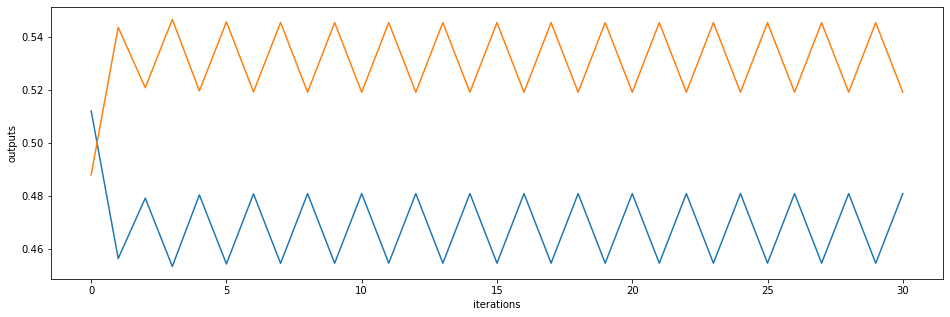

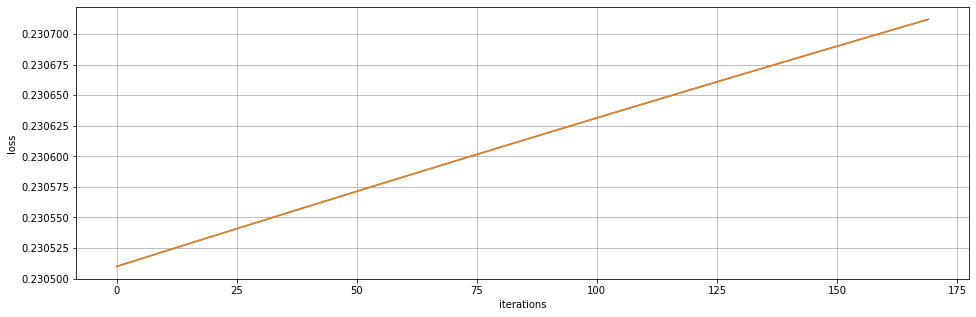

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 311
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41649593]
 [ 0.49618795]]
gradient[[-0.02895238]
 [ 0.05923938]
 [ 0.01151161]
 [-0.02037624]]
gradient[[ 0.49913024]
 [-0.54257725]]
gradient[[ 0.01662098]
 [-0.03348048]
 [-0.0058404 ]
 [ 0.01082581]]
gradient[[-0.41103616]
 [ 0.49564588]]
gradient[[-0.03089886]
 [ 0.06278887]
 [ 0.01176391]
 [-0.02194207]]
gradient[[ 0.49922785]
 [-0.54006975]]
gradient[[ 0.01563035]
 [-0.0314583 ]
 [-0.00545837]
 [ 0.01016151]]
gradient[[-0.41274372]
 [ 0.49581967]]
gradient[[-0.03034649]
 [ 0.06167415]
 [ 0.01155991]
 [-0.02151025]]
gradient[[ 0.49925972]
 [-0.53921839]]
gradient[[ 0.01529176]
 [-0.03077961]
 [-0.00534399]
 [ 0.00993163]]
gradient[[-0.4131

 [ 0.00988435]]
gradient[[-0.41327201]
 [ 0.49587265]]
gradient[[-0.03018157]
 [ 0.0613246 ]
 [ 0.01149228]
 [-0.02138115]]
gradient[[ 0.49926656]
 [-0.53903324]]
gradient[[ 0.01522129]
 [-0.03062931]
 [-0.00531658]
 [ 0.00988441]]
gradient[[-0.41327325]
 [ 0.49587278]]
gradient[[-0.03018107]
 [ 0.0613239 ]
 [ 0.01149223]
 [-0.02138073]]
gradient[[ 0.49926656]
 [-0.53903327]]
gradient[[ 0.0152214 ]
 [-0.03062923]
 [-0.00531649]
 [ 0.00988451]]
gradient[[-0.41327326]
 [ 0.49587278]]
gradient[[-0.03018153]
 [ 0.06132343]
 [ 0.01149177]
 [-0.02138119]]
gradient[[ 0.49926658]
 [-0.53903273]]
gradient[[ 0.0152211 ]
 [-0.0306289 ]
 [-0.00531651]
 [ 0.00988429]]
gradient[[-0.41327321]
 [ 0.49587277]]
gradient[[-0.03018165]
 [ 0.06132336]
 [ 0.01149168]
 [-0.0213813 ]]
gradient[[ 0.49926656]
 [-0.53903336]]
gradient[[ 0.01522144]
 [-0.0306293 ]
 [-0.0053165 ]
 [ 0.00988455]]
gradient[[-0.41327297]
 [ 0.49587275]]
gradient[[-0.03018198]
 [ 0.06132325]
 [ 0.01149144]
 [-0.02138162]]
gradient[[ 0

gradient[[ 0.49926511]
 [-0.53907253]]
gradient[[ 0.01524305]
 [-0.0306539 ]
 [-0.00531583]
 [ 0.00990121]]
---------------
epoch 318
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.4164766]
 [ 0.4961861]]
gradient[[-0.02897308]
 [ 0.05923693]
 [ 0.01149944]
 [-0.02039567]]
gradient[[ 0.49912778]
 [-0.54263874]]
gradient[[ 0.01665568]
 [-0.03351834]
 [-0.00583868]
 [ 0.01085286]]
gradient[[-0.41100822]
 [ 0.495643  ]]
gradient[[-0.03092661]
 [ 0.06278773]
 [ 0.01174818]
 [-0.02196803]]
gradient[[ 0.49922551]
 [-0.54013154]]
gradient[[ 0.0156647 ]
 [-0.03149685]
 [-0.00545707]
 [ 0.01018809]]
gradient[[-0.41271577]
 [ 0.49581686]]
gradient[[-0.03037385]
 [ 0.06167356]
 [ 0.01154464]
 [-0.02153577]]
gradient[[ 0.49925743]
 [-0.53928001]]
gradient[[ 0.01532577]
 [-0.03081827]
 [-0.00534292]
 [ 0.00995787]]
gradient[[-0.41313063]
 [ 0.49585851]]
gradient[[-0.03023925]
 [ 0.06140387]
 [ 0.01149673]
 [-0.02142946]]
grad

 [ 0.49586928]]
gradient[[-0.03021039]
 [ 0.06132821]
 [ 0.01147813]
 [-0.02140772]]
gradient[[ 0.49926426]
 [-0.53909555]]
gradient[[ 0.01525524]
 [-0.03066888]
 [-0.00531593]
 [ 0.0099105 ]]
gradient[[-0.41324404]
 [ 0.49586986]]
gradient[[-0.0302088 ]
 [ 0.06132422]
 [ 0.01147718]
 [-0.02140651]]
gradient[[ 0.49926429]
 [-0.53909481]]
gradient[[ 0.01525522]
 [-0.03066801]
 [-0.00531557]
 [ 0.00991056]]
gradient[[-0.41324528]
 [ 0.49586998]]
gradient[[-0.0302083 ]
 [ 0.06132352]
 [ 0.01147713]
 [-0.02140609]]
gradient[[ 0.49926429]
 [-0.53909484]]
gradient[[ 0.01525533]
 [-0.03066793]
 [-0.00531548]
 [ 0.00991067]]
gradient[[-0.41324529]
 [ 0.49586998]]
gradient[[-0.03020876]
 [ 0.06132305]
 [ 0.01147667]
 [-0.02140655]]
gradient[[ 0.49926431]
 [-0.53909431]]
gradient[[ 0.01525503]
 [-0.0306676 ]
 [-0.00531549]
 [ 0.00991044]]
gradient[[-0.41324523]
 [ 0.49586998]]
gradient[[-0.03020887]
 [ 0.06132298]
 [ 0.01147658]
 [-0.02140666]]
gradient[[ 0.49926429]
 [-0.53909493]]
gradient[[ 0

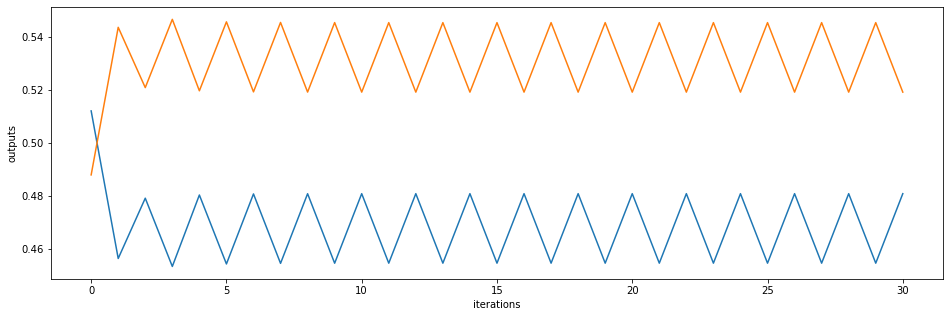

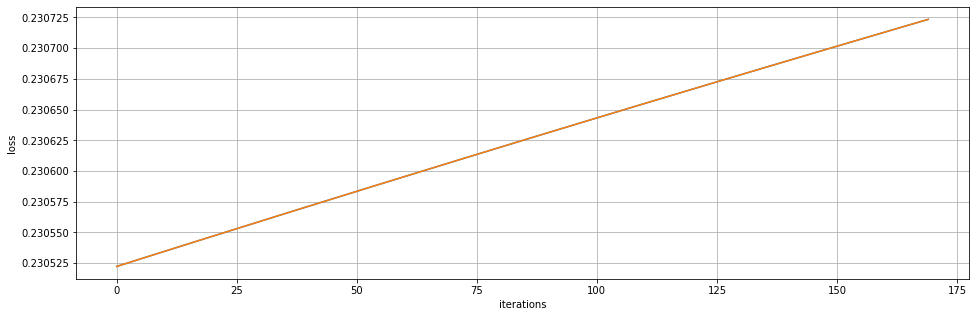

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 321
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41646833]
 [ 0.49618531]]
gradient[[-0.02898194]
 [ 0.05923589]
 [ 0.01149423]
 [-0.02040399]]
gradient[[ 0.49912672]
 [-0.54266504]]
gradient[[ 0.01667052]
 [-0.03353452]
 [-0.00583794]
 [ 0.01086444]]
gradient[[-0.41099626]
 [ 0.49564177]]
gradient[[-0.03093849]
 [ 0.06278723]
 [ 0.01174145]
 [-0.02197914]]
gradient[[ 0.49922451]
 [-0.54015797]]
gradient[[ 0.0156794 ]
 [-0.03151333]
 [-0.00545651]
 [ 0.01019947]]
gradient[[-0.41270381]
 [ 0.49581566]]
gradient[[-0.03038556]
 [ 0.0616733 ]
 [ 0.0115381 ]
 [-0.02154669]]
gradient[[ 0.49925645]
 [-0.53930636]]
gradient[[ 0.01534033]
 [-0.0308348 ]
 [-0.00534245]
 [ 0.0099691 ]]
gradient[[-0.4131

 [-0.53912114]]
gradient[[ 0.01526974]
 [-0.03068455]
 [-0.00531512]
 [ 0.00992176]]
gradient[[-0.41323331]
 [ 0.49586879]]
gradient[[-0.03021996]
 [ 0.06132336]
 [ 0.01147066]
 [-0.02141695]]
gradient[[ 0.49926332]
 [-0.53912117]]
gradient[[ 0.01526985]
 [-0.03068447]
 [-0.00531503]
 [ 0.00992186]]
gradient[[-0.41323332]
 [ 0.49586879]]
gradient[[-0.03022041]
 [ 0.06132288]
 [ 0.0114702 ]
 [-0.0214174 ]]
gradient[[ 0.49926334]
 [-0.53912064]]
gradient[[ 0.01526956]
 [-0.03068414]
 [-0.00531505]
 [ 0.00992163]]
gradient[[-0.41323326]
 [ 0.49586878]]
gradient[[-0.03022053]
 [ 0.06132282]
 [ 0.01147011]
 [-0.02141751]]
gradient[[ 0.49926331]
 [-0.53912127]]
gradient[[ 0.0152699 ]
 [-0.03068454]
 [-0.00531504]
 [ 0.0099219 ]]
gradient[[-0.41323303]
 [ 0.49586876]]
gradient[[-0.03022086]
 [ 0.0613227 ]
 [ 0.01146988]
 [-0.02141783]]
gradient[[ 0.49926325]
 [-0.53912282]]
gradient[[ 0.01527078]
 [-0.03068548]
 [-0.00531499]
 [ 0.00992258]]
gradient[[-0.41323275]
 [ 0.49586873]]
gradient[[-0

 [-0.02146567]]
gradient[[ 0.49926002]
 [-0.5392101 ]]
gradient[[ 0.01531156]
 [-0.03074812]
 [-0.00532059]
 [ 0.00995242]]
gradient[[-0.41318327]
 [ 0.49586378]]
gradient[[-0.03024876]
 [ 0.0613428 ]
 [ 0.01146376]
 [-0.02144246]]
gradient[[ 0.49926135]
 [-0.53917419]]
gradient[[ 0.01529722]
 [-0.03071975]
 [-0.00531594]
 [ 0.00994256]]
gradient[[-0.41320637]
 [ 0.49586609]]
gradient[[-0.03024145]
 [ 0.06132775]
 [ 0.0114609 ]
 [-0.02143666]]
gradient[[ 0.49926167]
 [-0.53916571]]
gradient[[ 0.01529395]
 [-0.03071294]
 [-0.00531474]
 [ 0.00994034]]
gradient[[-0.41321214]
 [ 0.49586667]]
gradient[[-0.03023986]
 [ 0.06132376]
 [ 0.01145995]
 [-0.02143544]]
gradient[[ 0.4992617 ]
 [-0.53916497]]
gradient[[ 0.01529392]
 [-0.03071206]
 [-0.00531438]
 [ 0.0099404 ]]
gradient[[-0.41321338]
 [ 0.49586679]]
gradient[[-0.03023937]
 [ 0.06132307]
 [ 0.01145989]
 [-0.02143502]]
gradient[[ 0.49926169]
 [-0.539165  ]]
gradient[[ 0.01529403]
 [-0.03071199]
 [-0.00531429]
 [ 0.0099405 ]]
gradient[[-0

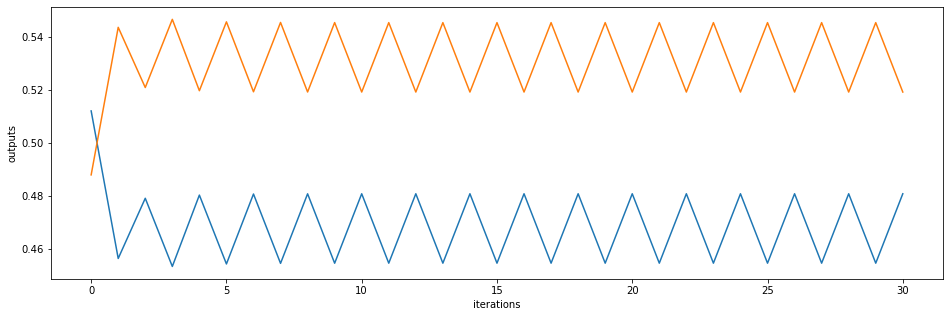

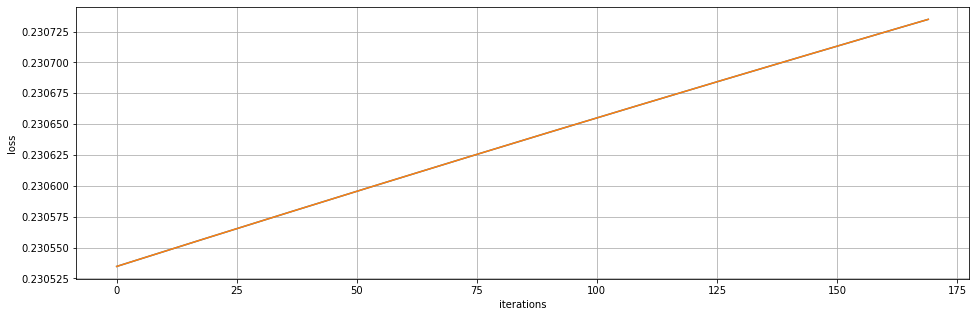

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 331
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.4164408 ]
 [ 0.49618267]]
gradient[[-0.02901142]
 [ 0.0592324 ]
 [ 0.0114769 ]
 [-0.02043167]]
gradient[[ 0.49912321]
 [-0.54275248]]
gradient[[ 0.01671992]
 [-0.03358829]
 [-0.00583544]
 [ 0.01090296]]
gradient[[-0.41095649]
 [ 0.49563768]]
gradient[[-0.03097803]
 [ 0.06278556]
 [ 0.01171902]
 [-0.02201612]]
gradient[[ 0.49922118]
 [-0.54024584]]
gradient[[ 0.01572831]
 [-0.03156808]
 [-0.00545461]
 [ 0.01023734]]
gradient[[-0.41266402]
 [ 0.49581165]]
gradient[[-0.03042455]
 [ 0.06167243]
 [ 0.01151633]
 [-0.02158304]]
gradient[[ 0.4992532 ]
 [-0.53939398]]
gradient[[ 0.01538877]
 [-0.03088972]
 [-0.00534087]
 [ 0.01000648]]
gradient[[-0.4130

 [-0.0214603 ]]
gradient[[ 0.49925943]
 [-0.5392262 ]]
gradient[[ 0.01532782]
 [-0.03075039]
 [-0.00531323]
 [ 0.00996656]]
gradient[[-0.41318554]
 [ 0.49586401]]
gradient[[-0.03026696]
 [ 0.06132219]
 [ 0.01144437]
 [-0.02146075]]
gradient[[ 0.49925945]
 [-0.53922567]]
gradient[[ 0.01532753]
 [-0.03075006]
 [-0.00531324]
 [ 0.00996633]]
gradient[[-0.41318548]
 [ 0.495864  ]]
gradient[[-0.03026707]
 [ 0.06132212]
 [ 0.01144428]
 [-0.02146086]]
gradient[[ 0.49925942]
 [-0.5392263 ]]
gradient[[ 0.01532787]
 [-0.03075045]
 [-0.00531323]
 [ 0.0099666 ]]
gradient[[-0.41318525]
 [ 0.49586398]]
gradient[[-0.0302674 ]
 [ 0.06132201]
 [ 0.01144405]
 [-0.02146118]]
gradient[[ 0.49925937]
 [-0.53922784]]
gradient[[ 0.01532875]
 [-0.03075139]
 [-0.00531318]
 [ 0.00996728]]
gradient[[-0.41318498]
 [ 0.49586395]]
gradient[[-0.03026739]
 [ 0.0613223 ]
 [ 0.01144418]
 [-0.02146115]]
gradient[[ 0.49925934]
 [-0.53922845]]
gradient[[ 0.01532909]
 [-0.03075177]
 [-0.00531316]
 [ 0.00996754]]
gradient[[-0

 [ 0.00998316]]
---------------
epoch 340
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
---------------
epoch 340
learning rate: 0.01836584937805656
sample 0
output: 
[[0.51209204]
 [0.48790796]]
target: 
[[1], [0]]
gradient[[-0.41641608]
 [ 0.4961803 ]]
gradient[[-0.02903788]
 [ 0.05922927]
 [ 0.01146134]
 [-0.02045651]]
gradient[[ 0.49912006]
 [-0.54283088]]
gradient[[ 0.01676426]
 [-0.03363645]
 [-0.00583316]
 [ 0.01093756]]
gradient[[-0.4109208]
 [ 0.495634 ]]
gradient[[-0.03101353]
 [ 0.06278403]
 [ 0.01169887]
 [-0.02204933]]
gradient[[ 0.49921818]
 [-0.54032462]]
gradient[[ 0.01577221]
 [-0.03161713]
 [-0.00545286]
 [ 0.01027133]]
gradient[[-0.41262831]
 [ 0.49580805]]
gradient[[-0.03045955]
 [ 0.06167161]
 [ 0.01149678]
 [-0.02161569]]
gradient[[ 0.49925027]
 [-0.53947254]]
gradient[[ 0.01543224]
 [-0.03093891]
 [-0.00533941]
 [ 0.01004004]]
gradient[[-0.41304316]
 [ 0.49584975]]
gradient[[-0.03032463]
 [ 0.06140238]

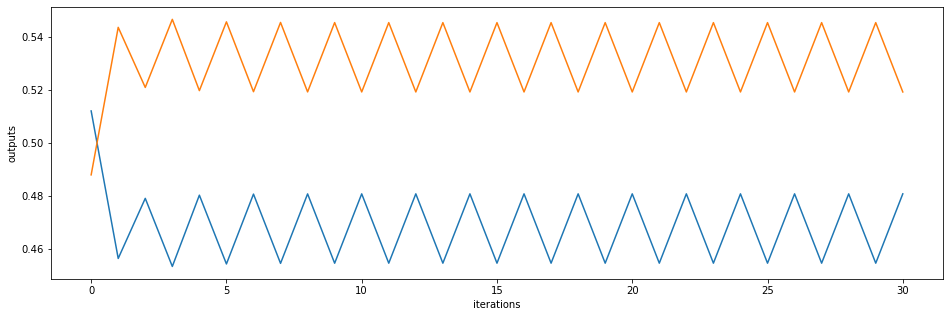

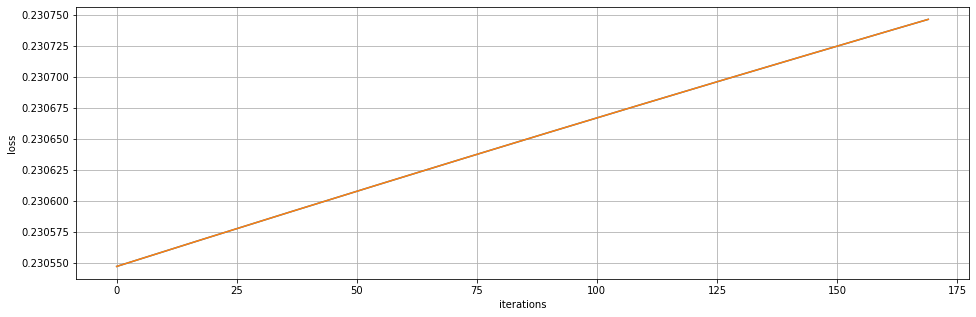

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 341
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41641333]
 [ 0.49618004]]
gradient[[-0.02904082]
 [ 0.05922893]
 [ 0.01145962]
 [-0.02045927]]
gradient[[ 0.49911971]
 [-0.54283958]]
gradient[[ 0.01676918]
 [-0.03364179]
 [-0.00583291]
 [ 0.0109414 ]]
gradient[[-0.41091684]
 [ 0.49563359]]
gradient[[-0.03101747]
 [ 0.06278386]
 [ 0.01169663]
 [-0.02205302]]
gradient[[ 0.49921785]
 [-0.54033336]]
gradient[[ 0.01577708]
 [-0.03162256]
 [-0.00545266]
 [ 0.01027511]]
gradient[[-0.41262434]
 [ 0.49580765]]
gradient[[-0.03046344]
 [ 0.06167152]
 [ 0.0114946 ]
 [-0.02161931]]
gradient[[ 0.49924995]
 [-0.53948125]]
gradient[[ 0.01543707]
 [-0.03094436]
 [-0.00533924]
 [ 0.01004376]]
gradient[[-0.4130

 [ 0.01005865]]
gradient[[-0.41302337]
 [ 0.49584776]]
gradient[[-0.03034397]
 [ 0.06140203]
 [ 0.01143848]
 [-0.02152703]]
gradient[[ 0.49925452]
 [-0.53935842]]
gradient[[ 0.01539354]
 [-0.03084109]
 [-0.00531793]
 [ 0.01001566]]
gradient[[-0.41311578]
 [ 0.49585703]]
gradient[[-0.03031458]
 [ 0.06134173]
 [ 0.01142719]
 [-0.02150378]]
gradient[[ 0.49925585]
 [-0.53932254]]
gradient[[ 0.01537918]
 [-0.03081277]
 [-0.00531331]
 [ 0.01000578]]
gradient[[-0.41313885]
 [ 0.49585933]]
gradient[[-0.03030727]
 [ 0.06132671]
 [ 0.01142434]
 [-0.02149797]]
gradient[[ 0.49925617]
 [-0.53931407]]
gradient[[ 0.0153759 ]
 [-0.03080598]
 [-0.00531212]
 [ 0.01000355]]
gradient[[-0.41314461]
 [ 0.49585991]]
gradient[[-0.03030568]
 [ 0.06132274]
 [ 0.0114234 ]
 [-0.02149675]]
gradient[[ 0.4992562 ]
 [-0.53931332]]
gradient[[ 0.01537587]
 [-0.0308051 ]
 [-0.00531176]
 [ 0.01000361]]
gradient[[-0.41314585]
 [ 0.49586004]]
gradient[[-0.03030519]
 [ 0.06132205]
 [ 0.01142335]
 [-0.02149633]]
gradient[[ 0

 [-0.02151114]]
gradient[[ 0.4992549 ]
 [-0.53934808]]
gradient[[ 0.0153951 ]
 [-0.03082687]
 [-0.00531113]
 [ 0.01001844]]
gradient[[-0.41313001]
 [ 0.49585845]]
gradient[[-0.03032064]
 [ 0.0613218 ]
 [ 0.01141476]
 [-0.02151073]]
gradient[[ 0.4992549]
 [-0.5393481]]
gradient[[ 0.01539521]
 [-0.03082679]
 [-0.00531104]
 [ 0.01001854]]
gradient[[-0.41313002]
 [ 0.49585845]]
gradient[[-0.03032109]
 [ 0.06132133]
 [ 0.0114143 ]
 [-0.02151118]]
gradient[[ 0.49925492]
 [-0.53934758]]
gradient[[ 0.01539491]
 [-0.03082647]
 [-0.00531105]
 [ 0.01001831]]
gradient[[-0.41312996]
 [ 0.49585844]]
gradient[[-0.0303212 ]
 [ 0.06132126]
 [ 0.01141422]
 [-0.02151129]]
gradient[[ 0.4992549]
 [-0.5393482]]
gradient[[ 0.01539525]
 [-0.03082686]
 [-0.00531104]
 [ 0.01001858]]
gradient[[-0.41312973]
 [ 0.49585842]]
gradient[[-0.03032154]
 [ 0.06132115]
 [ 0.01141398]
 [-0.02151161]]
gradient[[ 0.49925484]
 [-0.53934973]]
gradient[[ 0.01539613]
 [-0.03082779]
 [-0.00531099]
 [ 0.01001926]]
gradient[[-0.413

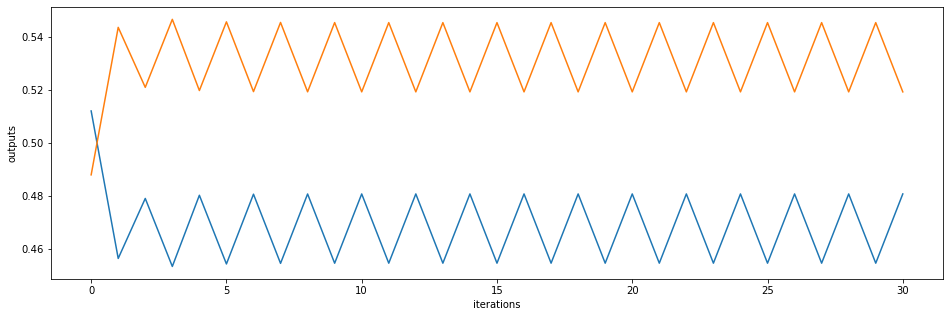

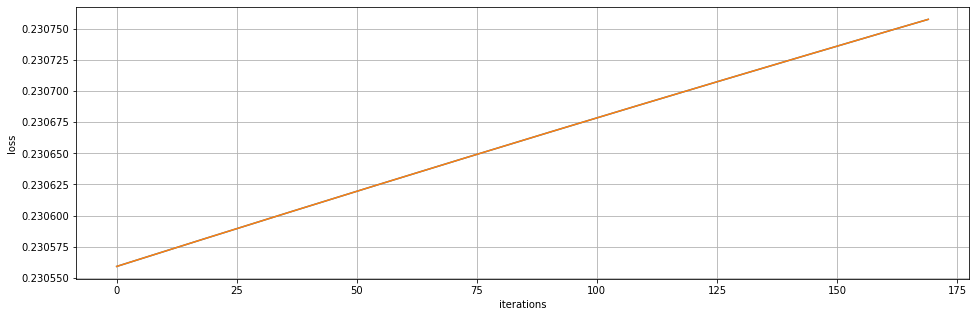

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 351
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41638594]
 [ 0.49617742]]
gradient[[-0.02907015]
 [ 0.05922546]
 [ 0.01144238]
 [-0.0204868 ]]
gradient[[ 0.49911621]
 [-0.54292632]]
gradient[[ 0.01681829]
 [-0.03369502]
 [-0.00583034]
 [ 0.01097973]]
gradient[[-0.41087731]
 [ 0.49562951]]
gradient[[-0.03105682]
 [ 0.06278214]
 [ 0.01167428]
 [-0.02208983]]
gradient[[ 0.49921453]
 [-0.54042053]]
gradient[[ 0.01582571]
 [-0.03167676]
 [-0.00545067]
 [ 0.01031278]]
gradient[[-0.41258479]
 [ 0.49580366]]
gradient[[-0.03050224]
 [ 0.06167059]
 [ 0.01147291]
 [-0.0216555 ]]
gradient[[ 0.4992467 ]
 [-0.53956818]]
gradient[[ 0.01548523]
 [-0.03099872]
 [-0.00533757]
 [ 0.01008096]]
gradient[[-0.4129

gradient[[-0.412569  ]
 [ 0.49580207]]
gradient[[-0.03051773]
 [ 0.06167021]
 [ 0.01146425]
 [-0.02166995]]
gradient[[ 0.49924541]
 [-0.53960285]]
gradient[[ 0.01550446]
 [-0.03102039]
 [-0.00533689]
 [ 0.01009581]]
gradient[[-0.41298386]
 [ 0.4958438 ]]
gradient[[-0.03038259]
 [ 0.06140129]
 [ 0.01141698]
 [-0.02156302]]
gradient[[ 0.49925129]
 [-0.5394452 ]]
gradient[[ 0.01544157]
 [-0.03089541]
 [-0.00531631]
 [ 0.01005274]]
gradient[[-0.41307624]
 [ 0.49585306]]
gradient[[-0.03035318]
 [ 0.06134106]
 [ 0.01140572]
 [-0.02153974]]
gradient[[ 0.49925263]
 [-0.53940933]]
gradient[[ 0.0154272 ]
 [-0.03086712]
 [-0.00531171]
 [ 0.01004284]]
gradient[[-0.41309929]
 [ 0.49585537]]
gradient[[-0.03034587]
 [ 0.06132607]
 [ 0.01140289]
 [-0.02153393]]
gradient[[ 0.49925294]
 [-0.53940087]]
gradient[[ 0.01542393]
 [-0.03086033]
 [-0.00531052]
 [ 0.01004061]]
gradient[[-0.41310504]
 [ 0.49585595]]
gradient[[-0.03034427]
 [ 0.0613221 ]
 [ 0.01140195]
 [-0.02153271]]
gradient[[ 0.49925297]
 [-0.

gradient[[-0.41308942]
 [ 0.49585439]]
gradient[[-0.03036079]
 [ 0.06132056]
 [ 0.0113922 ]
 [-0.02154817]]
gradient[[ 0.49925159]
 [-0.53943723]]
gradient[[ 0.01544454]
 [-0.03088259]
 [-0.00530939]
 [ 0.01005662]]
gradient[[-0.41308917]
 [ 0.49585436]]
gradient[[-0.03036113]
 [ 0.06132047]
 [ 0.01139197]
 [-0.0215485 ]]
gradient[[ 0.49925153]
 [-0.53943875]]
gradient[[ 0.0154454 ]
 [-0.03088352]
 [-0.00530933]
 [ 0.01005729]]
---------------
epoch 360
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
---------------
epoch 360
learning rate: 0.018274260741645593
sample 0
output: 
[[0.51209204]
 [0.48790796]]
target: 
[[1], [0]]
gradient[[-0.41636135]
 [ 0.49617506]]
gradient[[-0.02909648]
 [ 0.05922235]
 [ 0.0114269 ]
 [-0.02051151]]
gradient[[ 0.49911307]
 [-0.5430041 ]]
gradient[[ 0.01686236]
 [-0.03374269]
 [-0.00582799]
 [ 0.01101414]]
gradient[[-0.41084184]
 [ 0.49562585]]
gradient[[-0.03109216]
 [ 0.06278056]
 [ 0.0116542

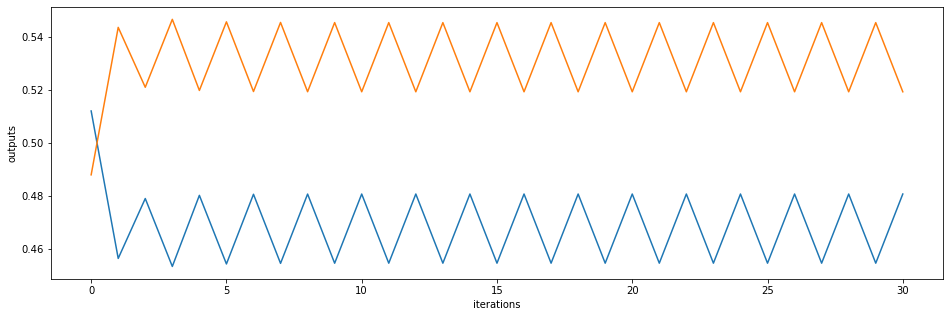

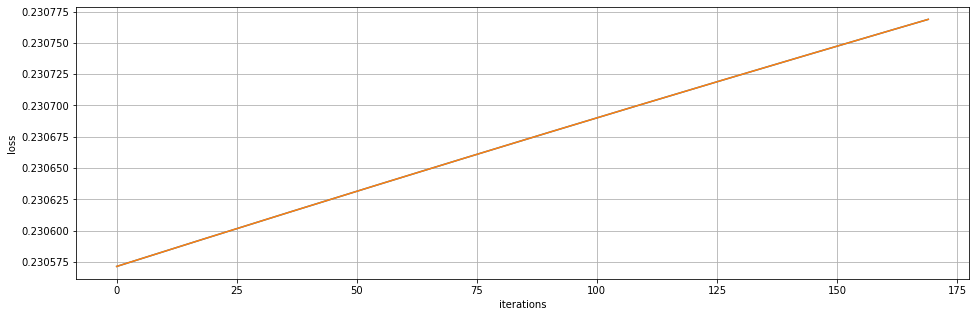

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 361
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41635862]
 [ 0.4961748 ]]
gradient[[-0.0290994 ]
 [ 0.059222  ]
 [ 0.01142518]
 [-0.02051425]]
gradient[[ 0.49911272]
 [-0.54301272]]
gradient[[ 0.01686725]
 [-0.03374798]
 [-0.00582773]
 [ 0.01101796]]
gradient[[-0.4108379 ]
 [ 0.49562545]]
gradient[[-0.03109608]
 [ 0.06278039]
 [ 0.01165198]
 [-0.02212656]]
gradient[[ 0.49921122]
 [-0.54050734]]
gradient[[ 0.0158742 ]
 [-0.03173069]
 [-0.00544864]
 [ 0.01035037]]
gradient[[-0.41254536]
 [ 0.49579968]]
gradient[[-0.03054095]
 [ 0.06166963]
 [ 0.01145126]
 [-0.02169161]]
gradient[[ 0.49924346]
 [-0.53965475]]
gradient[[ 0.01553326]
 [-0.03105282]
 [-0.00533586]
 [ 0.01011806]]
gradient[[-0.4129

 [ 0.01007019]]
gradient[[-0.41307348]
 [ 0.49585279]]
gradient[[-0.03037508]
 [ 0.06132157]
 [ 0.01138482]
 [-0.02156141]]
gradient[[ 0.49925039]
 [-0.5394693 ]]
gradient[[ 0.01546222]
 [-0.03090274]
 [-0.00530885]
 [ 0.01007025]]
gradient[[-0.41307471]
 [ 0.49585291]]
gradient[[-0.03037459]
 [ 0.06132088]
 [ 0.01138477]
 [-0.02156099]]
gradient[[ 0.49925039]
 [-0.53946932]]
gradient[[ 0.01546232]
 [-0.03090266]
 [-0.00530876]
 [ 0.01007035]]
gradient[[-0.41307472]
 [ 0.49585291]]
gradient[[-0.03037504]
 [ 0.06132042]
 [ 0.01138431]
 [-0.02156145]]
gradient[[ 0.49925041]
 [-0.5394688 ]]
gradient[[ 0.01546203]
 [-0.03090234]
 [-0.00530878]
 [ 0.01007012]]
gradient[[-0.41307467]
 [ 0.49585291]]
gradient[[-0.03037516]
 [ 0.06132035]
 [ 0.01138423]
 [-0.02156156]]
gradient[[ 0.49925039]
 [-0.53946942]]
gradient[[ 0.01546237]
 [-0.03090272]
 [-0.00530877]
 [ 0.01007038]]
gradient[[-0.41307444]
 [ 0.49585288]]
gradient[[-0.03037549]
 [ 0.06132024]
 [ 0.01138399]
 [-0.02156187]]
gradient[[ 0

 [-0.02215222]]
gradient[[ 0.4992089]
 [-0.5405679]]
gradient[[ 0.01590806]
 [-0.03176827]
 [-0.00544719]
 [ 0.01037662]]
gradient[[-0.41251783]
 [ 0.49579691]]
gradient[[-0.03056799]
 [ 0.06166894]
 [ 0.01143612]
 [-0.02171683]]
gradient[[ 0.4992412 ]
 [-0.53971515]]
gradient[[ 0.01556679]
 [-0.03109052]
 [-0.00533464]
 [ 0.01014398]]
gradient[[-0.41293268]
 [ 0.49583867]]
gradient[[-0.03043266]
 [ 0.06140029]
 [ 0.01138908]
 [-0.02160968]]
gradient[[ 0.4992471 ]
 [-0.53955749]]
gradient[[ 0.01550381]
 [-0.03096562]
 [-0.00531414]
 [ 0.0101008 ]]
gradient[[-0.41302502]
 [ 0.49584793]]
gradient[[-0.03040322]
 [ 0.06134015]
 [ 0.01137788]
 [-0.02158636]]
gradient[[ 0.49924844]
 [-0.53952165]]
gradient[[ 0.01548943]
 [-0.03093736]
 [-0.00530956]
 [ 0.01009089]]
gradient[[-0.41304804]
 [ 0.49585024]]
gradient[[-0.0303959 ]
 [ 0.06132519]
 [ 0.01137506]
 [-0.02158055]]
gradient[[ 0.49924876]
 [-0.53951319]]
gradient[[ 0.01548615]
 [-0.03093059]
 [-0.00530838]
 [ 0.01008865]]
gradient[[-0.4

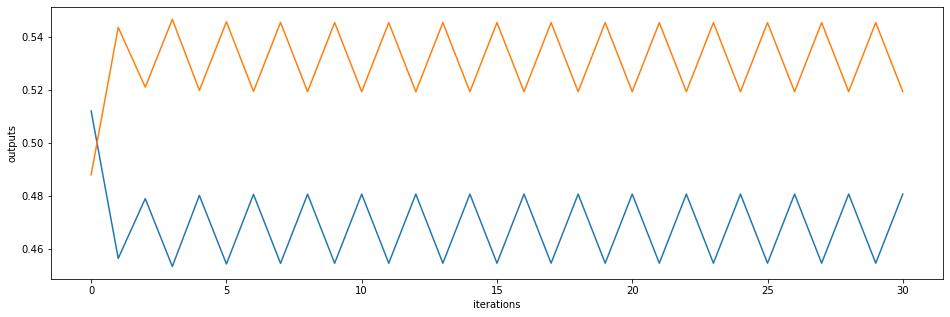

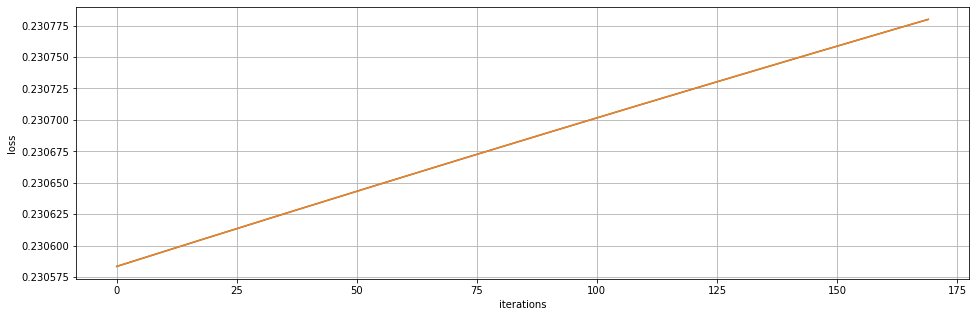

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 371
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41633136]
 [ 0.49617219]]
gradient[[-0.02912857]
 [ 0.05921856]
 [ 0.01140803]
 [-0.02054164]]
gradient[[ 0.49910924]
 [-0.54309877]]
gradient[[ 0.01691608]
 [-0.03380067]
 [-0.00582508]
 [ 0.01105609]]
gradient[[-0.41079861]
 [ 0.49562139]]
gradient[[-0.03113524]
 [ 0.06277861]
 [ 0.01162971]
 [-0.0221632 ]]
gradient[[ 0.49920791]
 [-0.54059381]]
gradient[[ 0.01592255]
 [-0.03178434]
 [-0.00544657]
 [ 0.01038785]]
gradient[[-0.41250604]
 [ 0.49579572]]
gradient[[-0.03057956]
 [ 0.06166864]
 [ 0.01142964]
 [-0.02172763]]
gradient[[ 0.49924023]
 [-0.53974098]]
gradient[[ 0.01558114]
 [-0.03110663]
 [-0.00533411]
 [ 0.01015507]]
gradient[[-0.4129

 [ 0.49584818]]
gradient[[-0.0304207 ]
 [ 0.06132006]
 [ 0.01135912]
 [-0.02160395]]
gradient[[ 0.49924653]
 [-0.53957269]]
gradient[[ 0.01551964]
 [-0.03096727]
 [-0.00530675]
 [ 0.01011461]]
gradient[[-0.41302751]
 [ 0.49584818]]
gradient[[-0.03042115]
 [ 0.06131959]
 [ 0.01135867]
 [-0.0216044 ]]
gradient[[ 0.49924655]
 [-0.53957217]]
gradient[[ 0.01551934]
 [-0.03096695]
 [-0.00530677]
 [ 0.01011438]]
gradient[[-0.41302746]
 [ 0.49584817]]
gradient[[-0.03042126]
 [ 0.06131953]
 [ 0.01135858]
 [-0.02160451]]
gradient[[ 0.49924653]
 [-0.53957278]]
gradient[[ 0.01551968]
 [-0.03096733]
 [-0.00530676]
 [ 0.01011464]]
gradient[[-0.41302723]
 [ 0.49584815]]
gradient[[-0.03042159]
 [ 0.06131941]
 [ 0.01135835]
 [-0.02160483]]
gradient[[ 0.49924647]
 [-0.53957429]]
gradient[[ 0.01552055]
 [-0.03096825]
 [-0.0053067 ]
 [ 0.01011532]]
gradient[[-0.41302696]
 [ 0.49584812]]
gradient[[-0.03042158]
 [ 0.0613197 ]
 [ 0.01135848]
 [-0.02160479]]
gradient[[ 0.49924645]
 [-0.5395749 ]]
gradient[[ 0

 [-0.00299201]]
---------------
epoch 380
learning rate: 0.018183128848516517
sample 0
output: 
[[0.51209204]
 [0.48790796]]
target: 
[[1], [0]]
gradient[[-0.4163069 ]
 [ 0.49616984]]
gradient[[-0.02915476]
 [ 0.05921546]
 [ 0.01139263]
 [-0.02056622]]
gradient[[ 0.49910611]
 [-0.54317592]]
gradient[[ 0.01695989]
 [-0.03384787]
 [-0.00582267]
 [ 0.01109033]]
gradient[[-0.41076336]
 [ 0.49561775]]
gradient[[-0.03117041]
 [ 0.06277699]
 [ 0.01160971]
 [-0.02219611]]
gradient[[ 0.49920494]
 [-0.54067133]]
gradient[[ 0.01596595]
 [-0.03183239]
 [-0.00544467]
 [ 0.01042151]]
gradient[[-0.41247076]
 [ 0.49579215]]
gradient[[-0.03061424]
 [ 0.06166773]
 [ 0.01141022]
 [-0.02175998]]
gradient[[ 0.49923733]
 [-0.53981829]]
gradient[[ 0.01562412]
 [-0.03115484]
 [-0.00533249]
 [ 0.0101883 ]]
gradient[[-0.41288561]
 [ 0.49583394]]
gradient[[-0.03047874]
 [ 0.06139933]
 [ 0.01136339]
 [-0.02165263]]
gradient[[ 0.49924324]
 [-0.53966062]]
gradient[[ 0.01556106]
 [-0.03103002]
 [-0.00531208]
 [ 0.01

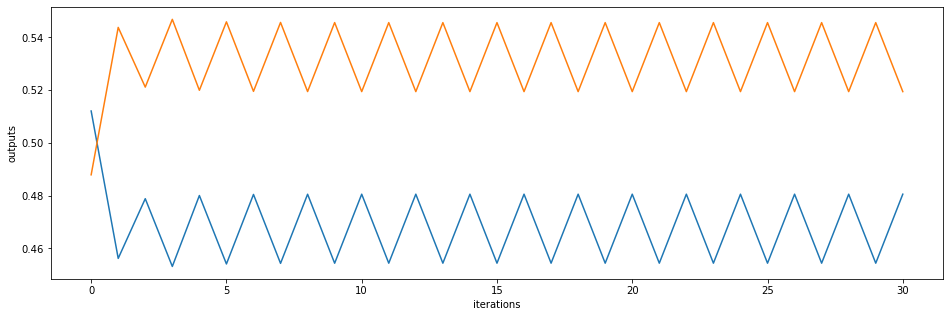

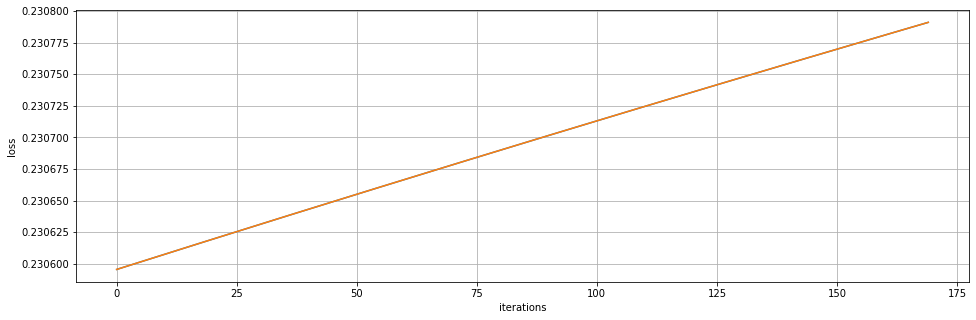

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 381
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41630418]
 [ 0.49616958]]
gradient[[-0.02915766]
 [ 0.05921512]
 [ 0.01139093]
 [-0.02056895]]
gradient[[ 0.49910577]
 [-0.54318448]]
gradient[[ 0.01696475]
 [-0.0338531 ]
 [-0.0058224 ]
 [ 0.01109412]]
gradient[[-0.41075945]
 [ 0.49561735]]
gradient[[-0.03117431]
 [ 0.06277681]
 [ 0.01160748]
 [-0.02219976]]
gradient[[ 0.49920461]
 [-0.54067992]]
gradient[[ 0.01597076]
 [-0.03183772]
 [-0.00544446]
 [ 0.01042525]]
gradient[[-0.41246685]
 [ 0.49579176]]
gradient[[-0.03061809]
 [ 0.06166763]
 [ 0.01140807]
 [-0.02176357]]
gradient[[ 0.49923701]
 [-0.53982686]]
gradient[[ 0.01562889]
 [-0.03116018]
 [-0.00533231]
 [ 0.01019199]]
gradient[[-0.4128

gradient[[ 0.49924394]
 [-0.53964206]]
gradient[[ 0.01555767]
 [-0.03101109]
 [-0.00530582]
 [ 0.01014389]]
gradient[[-0.41299489]
 [ 0.49584491]]
gradient[[-0.03045186]
 [ 0.06132017]
 [ 0.01134211]
 [-0.02163294]]
gradient[[ 0.49924397]
 [-0.5396413 ]]
gradient[[ 0.01555763]
 [-0.03101021]
 [-0.00530547]
 [ 0.01014394]]
gradient[[-0.41299612]
 [ 0.49584503]]
gradient[[-0.03045137]
 [ 0.06131949]
 [ 0.01134205]
 [-0.02163253]]
gradient[[ 0.49924397]
 [-0.53964132]]
gradient[[ 0.01555774]
 [-0.03101012]
 [-0.00530538]
 [ 0.01014404]]
gradient[[-0.41299613]
 [ 0.49584503]]
gradient[[-0.03045182]
 [ 0.06131902]
 [ 0.0113416 ]
 [-0.02163298]]
gradient[[ 0.49924399]
 [-0.5396408 ]]
gradient[[ 0.01555744]
 [-0.0310098 ]
 [-0.00530539]
 [ 0.01014381]]
gradient[[-0.41299608]
 [ 0.49584503]]
gradient[[-0.03045193]
 [ 0.06131896]
 [ 0.01134151]
 [-0.02163309]]
gradient[[ 0.49924396]
 [-0.53964141]]
gradient[[ 0.01555778]
 [-0.03101018]
 [-0.00530538]
 [ 0.01014408]]
gradient[[-0.41299585]
 [ 0.

gradient[[-0.41297916]
 [ 0.49584333]]
gradient[[-0.0304686 ]
 [ 0.06131851]
 [ 0.01133217]
 [-0.02164863]]
gradient[[ 0.49924254]
 [-0.53967951]]
gradient[[ 0.01557896]
 [-0.03103393]
 [-0.00530458]
 [ 0.01016045]]
---------------
epoch 388
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41628519]
 [ 0.49616776]]
gradient[[-0.02917799]
 [ 0.05921272]
 [ 0.01137898]
 [-0.02058803]]
gradient[[ 0.49910334]
 [-0.54324427]]
gradient[[ 0.01699874]
 [-0.03388964]
 [-0.00582051]
 [ 0.01112069]]
gradient[[-0.4107321 ]
 [ 0.49561452]]
gradient[[-0.0312016 ]
 [ 0.06277554]
 [ 0.01159195]
 [-0.0222253 ]]
gradient[[ 0.49920231]
 [-0.54074   ]]
gradient[[ 0.01600442]
 [-0.03187492]
 [-0.00544296]
 [ 0.01045136]]
gradient[[-0.41243948]
 [ 0.49578899]]
gradient[[-0.030645  ]
 [ 0.0616669 ]
 [ 0.01139299]
 [-0.02178867]]
gradient[[ 0.49923475]
 [-0.53988677]]
gradient[[ 0.01566223]
 [-0.0311975 ]
 [-0.00533103]
 [ 0.01021777]]
gr

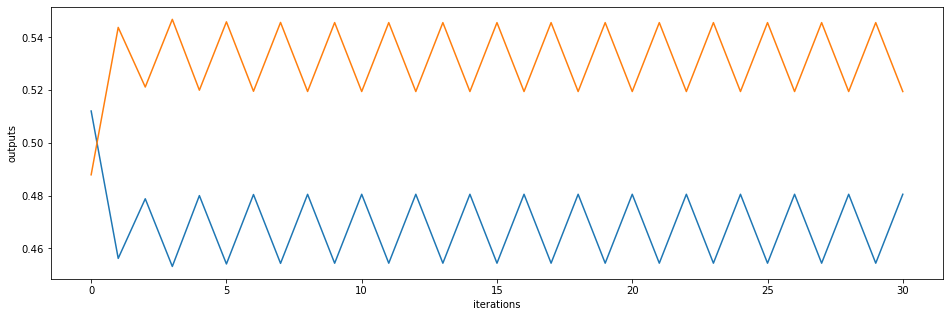

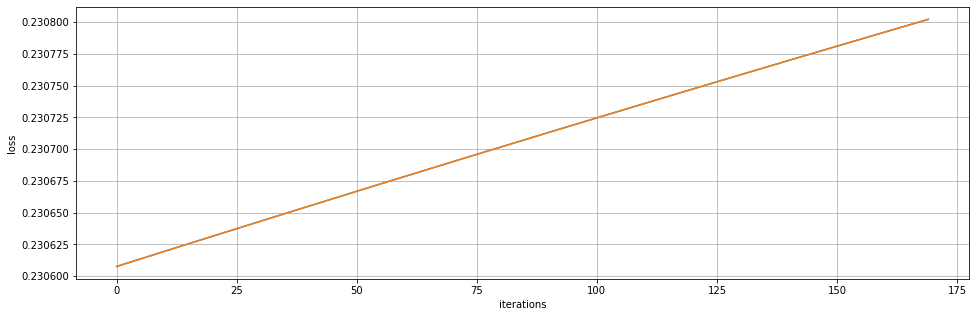

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 391
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41627707]
 [ 0.49616698]]
gradient[[-0.02918668]
 [ 0.05921169]
 [ 0.01137387]
 [-0.02059619]]
gradient[[ 0.4991023 ]
 [-0.54326984]]
gradient[[ 0.01701329]
 [-0.03390527]
 [-0.00581969]
 [ 0.01113206]]
gradient[[-0.4107204 ]
 [ 0.49561331]]
gradient[[-0.03121329]
 [ 0.06277499]
 [ 0.0115853 ]
 [-0.02223623]]
gradient[[ 0.49920132]
 [-0.54076569]]
gradient[[ 0.01601883]
 [-0.03189083]
 [-0.00544231]
 [ 0.01046254]]
gradient[[-0.41242777]
 [ 0.49578781]]
gradient[[-0.03065652]
 [ 0.06166659]
 [ 0.01138653]
 [-0.02179942]]
gradient[[ 0.49923379]
 [-0.5399124 ]]
gradient[[ 0.0156765 ]
 [-0.03121346]
 [-0.00533048]
 [ 0.01022881]]
gradient[[-0.4128

 [ 0.49584032]]
gradient[[-0.03049782]
 [ 0.06131807]
 [ 0.01131596]
 [-0.02167585]]
gradient[[ 0.49924012]
 [-0.53974395]]
gradient[[ 0.01561476]
 [-0.03107414]
 [-0.00530327]
 [ 0.01018811]]
gradient[[-0.41294892]
 [ 0.4958403 ]]
gradient[[-0.03049815]
 [ 0.06131796]
 [ 0.01131572]
 [-0.02167616]]
gradient[[ 0.49924006]
 [-0.53974545]]
gradient[[ 0.01561562]
 [-0.03107505]
 [-0.00530321]
 [ 0.01018878]]
gradient[[-0.41294865]
 [ 0.49584027]]
gradient[[-0.03049813]
 [ 0.06131824]
 [ 0.01131586]
 [-0.02167613]]
gradient[[ 0.49924004]
 [-0.53974605]]
gradient[[ 0.01561596]
 [-0.03107543]
 [-0.0053032 ]
 [ 0.01018904]]
gradient[[-0.41294829]
 [ 0.49584023]]
gradient[[-0.0304987 ]
 [ 0.06131802]
 [ 0.01131544]
 [-0.02167667]]
gradient[[ 0.49924006]
 [-0.53974565]]
gradient[[ 0.01561571]
 [-0.0310752 ]
 [-0.00530323]
 [ 0.01018885]]
gradient[[-0.41294814]
 [ 0.49584022]]
gradient[[-0.03049884]
 [ 0.06131801]
 [ 0.01131537]
 [-0.0216768 ]]
gradient[[ 0.49924003]
 [-0.53974629]]
gradient[[ 0

 [-0.02183162]]
gradient[[ 0.4992309 ]
 [-0.53998908]]
gradient[[ 0.01571923]
 [-0.03126118]
 [-0.00532879]
 [ 0.01026187]]
gradient[[-0.41280754]
 [ 0.49582609]]
gradient[[-0.03055524]
 [ 0.06139765]
 [ 0.01132069]
 [-0.02172395]]
gradient[[ 0.49923684]
 [-0.53983141]]
gradient[[ 0.01565603]
 [-0.03113649]
 [-0.00530851]
 [ 0.01021844]]
gradient[[-0.41289977]
 [ 0.49583536]]
gradient[[-0.03052574]
 [ 0.06133772]
 [ 0.01130962]
 [-0.02170054]]
gradient[[ 0.49923818]
 [-0.53979563]]
gradient[[ 0.01564162]
 [-0.03110833]
 [-0.00530398]
 [ 0.01020849]]
gradient[[-0.41292274]
 [ 0.49583767]]
gradient[[-0.03051842]
 [ 0.06132283]
 [ 0.01130684]
 [-0.02169471]]
gradient[[ 0.4992385 ]
 [-0.53978719]]
gradient[[ 0.01563834]
 [-0.03110159]
 [-0.00530281]
 [ 0.01020624]]
gradient[[-0.41292846]
 [ 0.49583824]]
gradient[[-0.03051683]
 [ 0.0613189 ]
 [ 0.01130592]
 [-0.02169349]]
gradient[[ 0.49923853]
 [-0.53978642]]
gradient[[ 0.0156383 ]
 [-0.0311007 ]
 [-0.00530246]
 [ 0.01020629]]
gradient[[-0

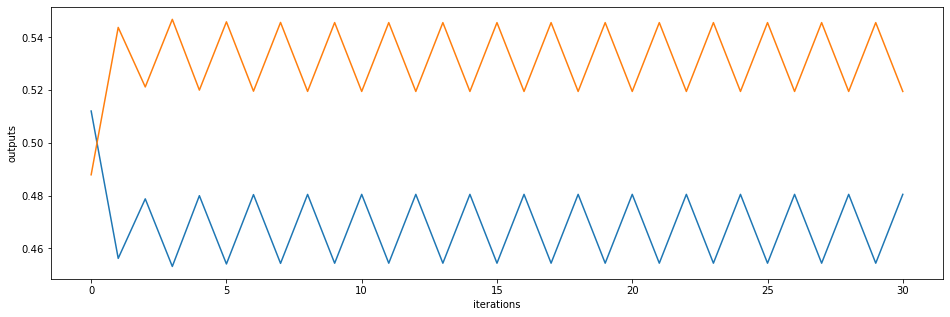

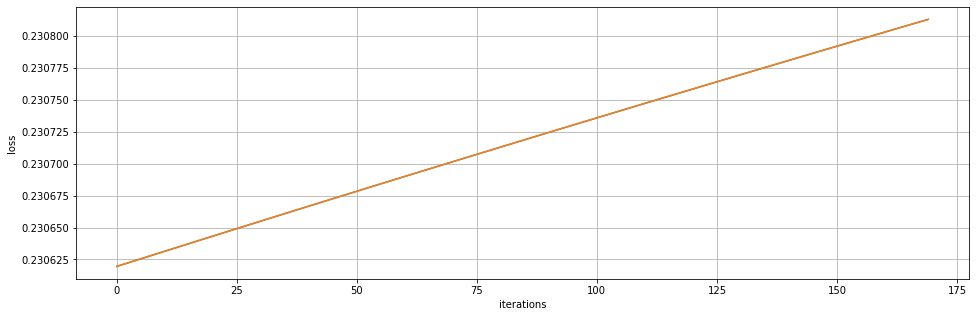

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 401
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41625002]
 [ 0.49616438]]
gradient[[-0.02921563]
 [ 0.05920827]
 [ 0.01135685]
 [-0.02062336]]
gradient[[ 0.49909884]
 [-0.54335485]]
gradient[[ 0.01706167]
 [-0.03395717]
 [-0.00581695]
 [ 0.01116989]]
gradient[[-0.41068148]
 [ 0.49560929]]
gradient[[-0.03125217]
 [ 0.06277313]
 [ 0.01156316]
 [-0.02227262]]
gradient[[ 0.49919803]
 [-0.54085111]]
gradient[[ 0.01606675]
 [-0.03194366]
 [-0.00544012]
 [ 0.01049974]]
gradient[[-0.41238882]
 [ 0.49578387]]
gradient[[-0.03069486]
 [ 0.06166552]
 [ 0.01136503]
 [-0.02183519]]
gradient[[ 0.49923058]
 [-0.53999759]]
gradient[[ 0.01572397]
 [-0.03126647]
 [-0.0053286 ]
 [ 0.01026554]]
gradient[[-0.4128

gradient[[-0.41291023]
 [ 0.49583641]]
gradient[[-0.03053584]
 [ 0.06131736]
 [ 0.01129479]
 [-0.02171128]]
gradient[[ 0.49923695]
 [-0.53982841]]
gradient[[ 0.01566176]
 [-0.03112677]
 [-0.00530148]
 [ 0.01022445]]
gradient[[-0.41291017]
 [ 0.49583641]]
gradient[[-0.03053596]
 [ 0.0613173 ]
 [ 0.0112947 ]
 [-0.02171139]]
gradient[[ 0.49923693]
 [-0.53982902]]
gradient[[ 0.01566209]
 [-0.03112715]
 [-0.00530147]
 [ 0.01022471]]
gradient[[-0.41290995]
 [ 0.49583638]]
gradient[[-0.03053628]
 [ 0.06131719]
 [ 0.01129447]
 [-0.0217117 ]]
gradient[[ 0.49923687]
 [-0.53983052]]
gradient[[ 0.01566295]
 [-0.03112805]
 [-0.00530141]
 [ 0.01022538]]
gradient[[-0.41290968]
 [ 0.49583636]]
gradient[[-0.03053627]
 [ 0.06131747]
 [ 0.0112946 ]
 [-0.02171167]]
gradient[[ 0.49923685]
 [-0.53983112]]
gradient[[ 0.01566329]
 [-0.03112842]
 [-0.00530139]
 [ 0.01022564]]
gradient[[-0.41290931]
 [ 0.49583632]]
gradient[[-0.03053684]
 [ 0.06131725]
 [ 0.01129419]
 [-0.02171221]]
gradient[[ 0.49923686]
 [-0.

 [-0.54343108]]
gradient[[ 0.01710509]
 [-0.03400366]
 [-0.00581445]
 [ 0.01120385]]
gradient[[-0.41064655]
 [ 0.49560568]]
gradient[[-0.03128708]
 [ 0.06277145]
 [ 0.01154326]
 [-0.02230529]]
gradient[[ 0.49919508]
 [-0.54092769]]
gradient[[ 0.01610976]
 [-0.03199099]
 [-0.00543811]
 [ 0.01053314]]
gradient[[-0.41235386]
 [ 0.49578034]]
gradient[[-0.03072929]
 [ 0.06166454]
 [ 0.01134572]
 [-0.02186732]]
gradient[[ 0.49922769]
 [-0.54007396]]
gradient[[ 0.01576658]
 [-0.03131395]
 [-0.00532688]
 [ 0.01029852]]
gradient[[-0.41276868]
 [ 0.49582219]]
gradient[[-0.03059336]
 [ 0.06139677]
 [ 0.0112994 ]
 [-0.02175948]]
gradient[[ 0.49923364]
 [-0.53991629]]
gradient[[ 0.0157033 ]
 [-0.03118933]
 [-0.00530666]
 [ 0.01025501]]
gradient[[-0.41286088]
 [ 0.49583146]]
gradient[[-0.03056384]
 [ 0.06133691]
 [ 0.01128837]
 [-0.02173605]]
gradient[[ 0.49923499]
 [-0.53988052]]
gradient[[ 0.01568889]
 [-0.0311612 ]
 [-0.00530216]
 [ 0.01024504]]
gradient[[-0.41288383]
 [ 0.49583376]]
gradient[[-0

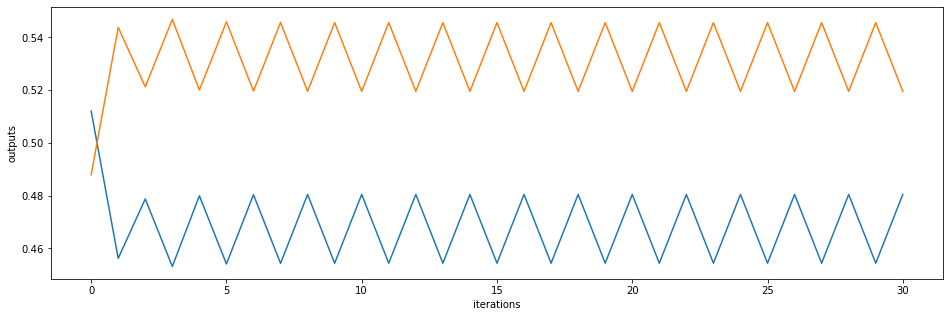

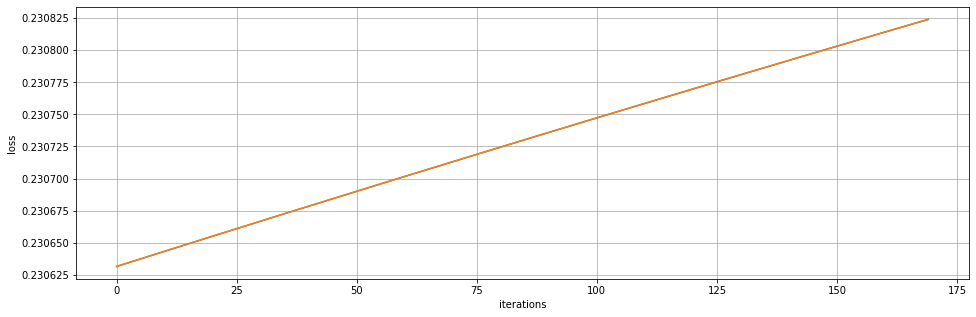

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 411
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41622304]
 [ 0.49616179]]
gradient[[-0.02924449]
 [ 0.05920487]
 [ 0.01133989]
 [-0.02065046]]
gradient[[ 0.49909539]
 [-0.54343953]]
gradient[[ 0.01710991]
 [-0.03400881]
 [-0.00581417]
 [ 0.01120761]]
gradient[[-0.41064267]
 [ 0.49560528]]
gradient[[-0.03129095]
 [ 0.06277126]
 [ 0.01154105]
 [-0.02230892]]
gradient[[ 0.49919475]
 [-0.54093619]]
gradient[[ 0.01611454]
 [-0.03199624]
 [-0.00543789]
 [ 0.01053685]]
gradient[[-0.41234998]
 [ 0.49577994]]
gradient[[-0.03073311]
 [ 0.06166443]
 [ 0.01134357]
 [-0.02187088]]
gradient[[ 0.49922737]
 [-0.54008243]]
gradient[[ 0.0157713 ]
 [-0.03131921]
 [-0.00532669]
 [ 0.01030218]]
gradient[[-0.4127

gradient[[-0.41287137]
 [ 0.49583251]]
gradient[[-0.03057389]
 [ 0.06131657]
 [ 0.01127358]
 [-0.02174674]]
gradient[[ 0.49923376]
 [-0.53991314]]
gradient[[ 0.01570895]
 [-0.03117951]
 [-0.00529964]
 [ 0.01026095]]
gradient[[-0.41287131]
 [ 0.4958325 ]]
gradient[[-0.03057401]
 [ 0.06131651]
 [ 0.01127349]
 [-0.02174685]]
gradient[[ 0.49923374]
 [-0.53991375]]
gradient[[ 0.01570929]
 [-0.03117989]
 [-0.00529963]
 [ 0.01026121]]
gradient[[-0.41287109]
 [ 0.49583248]]
gradient[[-0.03057433]
 [ 0.06131639]
 [ 0.01127326]
 [-0.02174716]]
gradient[[ 0.49923368]
 [-0.53991524]]
gradient[[ 0.01571015]
 [-0.03118079]
 [-0.00529957]
 [ 0.01026188]]
gradient[[-0.41287082]
 [ 0.49583245]]
gradient[[-0.03057432]
 [ 0.06131668]
 [ 0.01127339]
 [-0.02174713]]
gradient[[ 0.49923366]
 [-0.53991584]]
gradient[[ 0.01571048]
 [-0.03118116]
 [-0.00529955]
 [ 0.01026214]]
gradient[[-0.41287045]
 [ 0.49583242]]
gradient[[-0.03057488]
 [ 0.06131645]
 [ 0.01127298]
 [-0.02174767]]
gradient[[ 0.49923367]
 [-0.

 [ 0.49560167]]
gradient[[-0.03132578]
 [ 0.06276955]
 [ 0.0115212 ]
 [-0.02234151]]
gradient[[ 0.49919181]
 [-0.54101246]]
gradient[[ 0.01615742]
 [-0.03204332]
 [-0.00543586]
 [ 0.01057016]]
gradient[[-0.41231513]
 [ 0.49577642]]
gradient[[-0.03076745]
 [ 0.06166343]
 [ 0.01132429]
 [-0.02190293]]
gradient[[ 0.49922449]
 [-0.5401585 ]]
gradient[[ 0.01581378]
 [-0.03136645]
 [-0.00532493]
 [ 0.01033507]]
gradient[[-0.41272994]
 [ 0.49581829]]
gradient[[-0.03063138]
 [ 0.06139586]
 [ 0.01127815]
 [-0.02179493]]
gradient[[ 0.49923045]
 [-0.54000083]]
gradient[[ 0.01575044]
 [-0.03124189]
 [-0.00530478]
 [ 0.01029148]]
gradient[[-0.4128221 ]
 [ 0.49582756]]
gradient[[-0.03060184]
 [ 0.06133607]
 [ 0.01126716]
 [-0.02177147]]
gradient[[ 0.4992318 ]
 [-0.53996508]]
gradient[[ 0.01573602]
 [-0.0312138 ]
 [-0.00530029]
 [ 0.0102815 ]]
gradient[[-0.41284503]
 [ 0.49582986]]
gradient[[-0.03059452]
 [ 0.06132122]
 [ 0.0112644 ]
 [-0.02176564]]
gradient[[ 0.49923212]
 [-0.53995665]]
gradient[[ 0

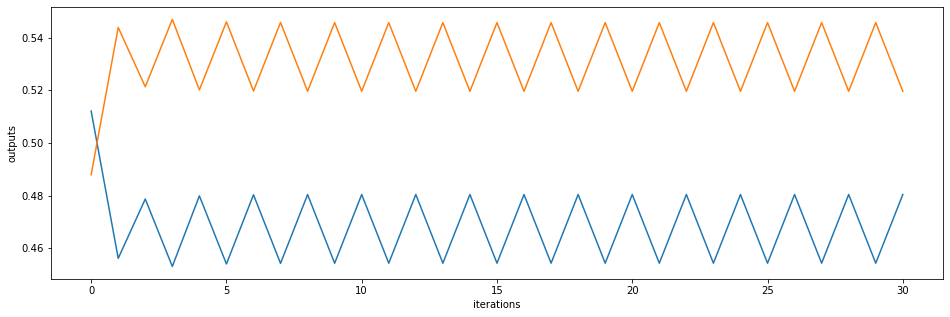

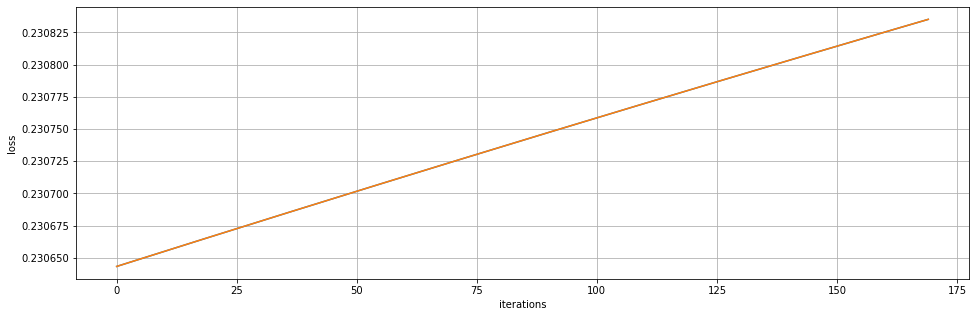

BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB
---------------
epoch 421
gradient[[ 0.49970757]
 [-0.47610836]]
gradient[[-0.01072073]
 [ 0.02147695]
 [ 0.00371823]
 [-0.00299201]]
gradient[[-0.41619614]
 [ 0.49615921]]
gradient[[-0.02927328]
 [ 0.05920147]
 [ 0.01132296]
 [-0.02067748]]
gradient[[ 0.49909195]
 [-0.54352386]]
gradient[[ 0.01715801]
 [-0.03406019]
 [-0.00581136]
 [ 0.01124524]]
gradient[[-0.41060399]
 [ 0.49560127]]
gradient[[-0.03132964]
 [ 0.06276936]
 [ 0.01151899]
 [-0.02234513]]
gradient[[ 0.49919148]
 [-0.54102091]]
gradient[[ 0.01616218]
 [-0.03204854]
 [-0.00543563]
 [ 0.01057385]]
gradient[[-0.41231126]
 [ 0.49577603]]
gradient[[-0.03077127]
 [ 0.06166331]
 [ 0.01132215]
 [-0.02190649]]
gradient[[ 0.49922417]
 [-0.54016694]]
gradient[[ 0.01581849]
 [-0.03137168]
 [-0.00532474]
 [ 0.01033872]]
gradient[[-0.4127

 [-0.02178223]]
gradient[[ 0.49923056]
 [-0.53999813]]
gradient[[ 0.01575634]
 [-0.03123236]
 [-0.00529775]
 [ 0.01029762]]
gradient[[-0.41283234]
 [ 0.49582859]]
gradient[[-0.03061229]
 [ 0.06131558]
 [ 0.01125208]
 [-0.02178254]]
gradient[[ 0.4992305 ]
 [-0.53999962]]
gradient[[ 0.0157572 ]
 [-0.03123326]
 [-0.00529769]
 [ 0.01029828]]
gradient[[-0.41283207]
 [ 0.49582856]]
gradient[[-0.03061228]
 [ 0.06131586]
 [ 0.01125221]
 [-0.02178251]]
gradient[[ 0.49923048]
 [-0.54000021]]
gradient[[ 0.01575753]
 [-0.03123362]
 [-0.00529767]
 [ 0.01029854]]
gradient[[-0.41283171]
 [ 0.49582852]]
gradient[[-0.03061284]
 [ 0.06131563]
 [ 0.01125181]
 [-0.02178305]]
gradient[[ 0.49923049]
 [-0.53999982]]
gradient[[ 0.01575728]
 [-0.0312334 ]
 [-0.00529771]
 [ 0.01029835]]
gradient[[-0.41283157]
 [ 0.49582851]]
gradient[[-0.03061298]
 [ 0.06131563]
 [ 0.01125173]
 [-0.02178318]]
gradient[[ 0.49923047]
 [-0.54000045]]
gradient[[ 0.01575763]
 [-0.0312338 ]
 [-0.0052977 ]
 [ 0.01029861]]
gradient[[-0

KeyboardInterrupt: 

In [142]:
epochs = 14000
batch = 2
early_stop = 500
loss = 0
prevLoss = 999
losses = []

for e in range(0, epochs+1):
    network.clear_memory()
    loss = 0
    outputs = []
    print("---------------")
    print("epoch " + str(e))
    network.learning_rate /= 1.00025
    for i in range(0, len(input_data)-1):
        output = network.forward_pass(input_data[i])
        outputs.append(output)
        loss += network.backpropagation_through_time(input_data, input_data[i+1], 10)
  
        if e%10 == 0 and i%101 == 0:
            print("---------------")
            print("epoch " + str(e))
            print("learning rate: " + str(network.learning_rate))
            print("sample " + str(i))
            print("output: \n" + str(output))
            print("target: \n" + str(input_data[i+1]))
    
    if e%10 == 0:        
        print("-----------------")
        print("average loss: ")
        print(str(loss/len(input_data))) 
        plt.plot(np.squeeze(outputs))
        plt.ylabel('outputs')
        plt.xlabel('iterations')
        plt.show()
        
        plt.plot(np.squeeze(losses))
        plt.ylabel('loss')
        plt.xlabel('iterations')
        plt.grid()
        plt.show()
        network.predict(input_data)
        
        
    prevLoss = loss
    if e > 10:
        losses.append(loss/len(input_data))
    if e > 180:
        del losses[0]
    
    
print("------------training finished successfully!------------")
        

In [ ]:
print(str(network.layers[-1].weights_H))

In [ ]:
print(str(network.layers[-2].weights_X))

In [ ]:
print(str(network.layers[-2].H))